# Tenth iteration model-Testing 
Objetivo.Mix Under-over sampling. New columns + without ouliers+ 200k more customers 

In [1]:
%autosave 240

Autosaving every 240 seconds


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from seaborn import kdeplot
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from mpl_toolkits.axes_grid.inset_locator import inset_axes
'''need to install first folium :conda install -c conda-forge folium'''
import folium  
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.tree.export import export_text
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score
# from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn import tree
# feature selection
import statsmodels.api as sm
# Balance
'''conda install -c conda-forge imbalanced-learn'''
from collections import Counter
from imblearn.over_sampling import SMOTENC
from sklearn.datasets import make_classification
from imblearn.datasets import make_imbalance

from sklearn.linear_model import LogisticRegression
from sklearn import model_selection,metrics

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,auc,confusion_matrix,classification_report, f1_score

from numpy import mean, arange, argmax
from sklearn.model_selection import RepeatedStratifiedKFold

'''conda install -c anaconda py-xgboost'''
from xgboost import XGBClassifier


# librerias que voy a probar

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline


%matplotlib inline


C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  if __name__ == '__main__':
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be impor

# Data preparation

### a. Download raw data

In [3]:
# I downloaded the info from SAS. 
# I chuncksized it to upload it. 

# For automation purpose i am going to look for the files path

pd.set_option('display.max_columns',50)

'''os.path.abspath  The path module suitable for 
the operating system Python is running on, and therefore usable 
for local paths.Return a normalized absolutized version of the pathname path
https://docs.python.org/2/library/os.path.html''' 
'''Original dataframe called Raw_data_TFM.CSV'''

mother_file_path = os.path.abspath("Raw_data_TFM.CSV") 

mother_file = pd.read_csv(mother_file_path,sep=';',chunksize =200000,low_memory=False)

# i read the file 

file = mother_file
''' call the file outside the loop'''
all_chunks =pd.DataFrame()

for i,chunk in enumerate(file):
    print(i,len(all_chunks))
    all_chunks = all_chunks.append(chunk)
    all_chunks.drop_duplicates(inplace =True)

# Record it

all_chunks.to_csv('Total_clients_ini.csv',sep= ';',index =False)


Total_clients_ini= pd.read_csv('Total_clients_ini.csv',sep=';',squeeze=True)

# filter non residents to avoid noise. 

total_clients_file_ini = Total_clients_ini[(Total_clients_ini['resi_country']== 'ES') &
                                           (Total_clients_ini['codseg']!= 'BC')]
# Drop features not relevant for this study
 
total_clients_file_ini.drop(['branch','codine','nat_country', 'resi_country','country',
                                                     'cod1','cod2',], axis=1,inplace =True)
total_clients_file_ini.shape

0 0
1 200000


C:\Users\N58645\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\N58645\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(395937, 44)

In [4]:
'''sample() is an inbuilt function of random module in Python that returns 
a particular length list of items chosen from the sequence i.e. list, tuple,
string or set. Used for random sampling without replacement.
https://www.geeksforgeeks.org/python-random-sample-function/'''

total_clients_file_ini.sample(5)

gender  age  studies work_type marital_status codseg  cpper cprovper  \
94038       H   79        3         J              O     PR  11150       12   
194302      V   75        1         P              S     PI  44600       46   
14423       V   47        3         A              C     PR  28022        9   
281100      H   56        5         A              O     PI  41700       28   
362720      V   43        1         A              O     PR   8830       28   

        clocaper autonper population_cmun  disporent_cmun  num_cred_cards_0m  \
94038        208       10        169498.0         21338.0                0.0   
194302       214       13       3182981.0         29400.0                0.0   
14423         42        7           32535         20547.0                0.0   
281100        91        7            1165         17823.0                0.0   
362720         2        4           11265         17832.0                0.0   

        aveg_amount_cred_card_0m  num_current_acc_0m  \
94038                        0.0                 1.0   
194302                       0.0                 1.0   
14423                        0.0                 1.0   
281100                       0.0                 1.0   
362720                       0.0                 1.0   

       aveg_amount_current_acc_0m  num_invest_funds_0m  \
94038                       14030                  0.0   
194302                    26410.4                  0.0   
14423                           0                  0.0   
281100                    46510.6                  3.0   
362720                     788.46                  0.0   

        aveg_amount_invest_funds_0m mortgage  num_stocks_0m  \
94038                          0.00        S            1.0   
194302                         0.00        N            4.0   
14423                          0.00        N            0.0   
281100                     73028.77        N            1.0   
362720                         0.00        S            0.0   

       aveg_amount_stocks_0m  acc_0m mobile_0m pc_0m tablet_0m  \
94038               23,83453     NaN       NaN   NaN       NaN   
194302           306611,6348     8.0       0.0   1.0       0.0   
14423                      0     0.0         0     0         0   
281100            5450,07358     7.0         1     0         0   
362720                     0    30.0         1     0         0   

        national_transfers_0m  transfers_0m  app_par_0m  web_par_0m  \
94038                     NaN           NaN         NaN         NaN   
194302                    5.0           0.0         0.0         4.0   
14423                     0.0           0.0         0.0         0.0   
281100                    0.0           0.0         7.0         0.0   
362720                    0.0           0.0        28.0         2.0   

       amount_cards_0m amount_trfr_0m amount_salarypenr_0m amount_rec_0m  \
94038                0      745,12832            881,98644     213,91511   
194302               0     1310,39168            506,00968     197,31367   
14423                0     1933,96128           2559,16428     489,63627   
281100               0        1192,48              1577,98             0   
362720       1001,7936      1843,1472            2438,9922     225,52468   

       amount_total_cards_0m  num_trfr_0m  num_trfe_0m  num_rec_0m  \
94038                      0          3.0          0.0         4.0   
194302                     0          2.0          7.0         3.0   
14423                      0          2.0          1.0        15.0   
281100                     0          1.0          0.0         0.0   
362720             1381,2768          1.0          0.0         5.0   

        num_card_postpone_payment_3t4t_delta  \
94038                                    0.0   
194302                                   0.0   
14423                                    0.0   
281100                                   0.0   
362720                                   0.0

In [5]:
# place the dependent feature as first column
newdf = total_clients_file_ini[total_clients_file_ini.columns[0:-1]]
newdf_contrata = total_clients_file_ini[total_clients_file_ini.columns[-1:]]
total_clients_file_ini = pd.concat([newdf_contrata, newdf], axis = 1)
total_clients_file_ini.sample(5)

got_loan gender  age  studies work_type marital_status codseg  cpper  \
250            0      V   28        4         O              C     PR  29010   
284658         0      V   63        2         A              S     PR  38670   
135595         0      H   43        1         A              C     PR  41013   
247220         0      V   78        1         J              S     PR  28850   
49609          0      V   68        3         A              O     PR  28670   

       cprovper  clocaper autonper population_cmun  disporent_cmun  \
250          36       280       10            9596         19224.0   
284658       28       426        9         25574.0         22081.0   
135595        8       351       10           41568         18961.0   
247220       33        89       13           83767         25551.0   
49609        26        22        1           68859         20188.0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
250                   0.0                      0.00                 1.0   
284658                2.0                    108.08                 1.0   
135595                1.0                    -63.51                 1.0   
247220                2.0                     14.97                 1.0   
49609                 0.0                      0.00                 1.0   

       aveg_amount_current_acc_0m  num_invest_funds_0m  \
250                           -78                  0.0   
284658                    47664.6                  0.0   
135595                    17975.5                  0.0   
247220                    37327.4                  0.0   
49609                      108.03                  0.0   

        aveg_amount_invest_funds_0m mortgage  num_stocks_0m  \
250                             0.0        N            0.0   
284658                          0.0        N            1.0   
135595                          0.0        S            0.0   
247220                          0.0        N            1.0   
49609                           0.0        N            0.0   

       aveg_amount_stocks_0m  acc_0m           mobile_0m                pc_0m  \
250                        0    15.0                   1                    0   
284658               3,41174     7.0  0.8571428571428571  0.14285714285714285   
135595                     0     4.0                 0,5                  0,5   
247220               3,41174     0.0                   0                    0   
49609                      0    12.0                0,75                 0,25   

       tablet_0m  national_transfers_0m  transfers_0m  app_par_0m  web_par_0m  \
250            0                    0.0           0.0        14.0         1.0   
284658       0.0                    3.0           0.0         4.0         3.0   
135595         0                    0.0           1.0         2.0         2.0   
247220         0                    0.0           0.0         0.0         0.0   
49609          0                    0.0           0.0         7.0         5.0   

       amount_cards_0m amount_trfr_0m amount_salarypenr_0m amount_rec_0m  \
250          167,54693      421,94304            558,34704             0   
284658           76,24     2075,32352           2746,22552      61,25049   
135595       603,17276     2958,05568           3595,04368     362,73166   
247220       124,16637      1975,3872            2613,9822     334,42261   
49609                0       892,5504            1181,0904     963,66784   

       amount_total_cards_0m  num_trfr_0m  num_trfe_0m  num_rec_0m  \
250                231,01434          1.0          0.0         0.0   
284658                105,12          1.0          5.0         2.0   
135595             831,65688          6.0          4.0         4.0   
247220             171,20106          1.0          0.0         9.0   
49609                      0          1.0          0.0        12.0   

        num_card_postpone_payment_3t4t_delta  \
250                        

In [6]:
# Filter and print number of instances with feature got loan value =1 and with got loan =0 
print('Total clientes with loan: ',total_clients_file_ini[total_clients_file_ini.got_loan ==1].shape)
print('Total clientes without loan: ', total_clients_file_ini[total_clients_file_ini.got_loan ==0].shape)

Total clientes with loan:  (7005, 44)
Total clientes without loan:  (388932, 44)


In [7]:
'''column labels of the DataFrame 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html'''

total_clients_file_ini.columns

Index(['got_loan', 'gender', 'age', 'studies', 'work_type', 'marital_status',
       'codseg', 'cpper', 'cprovper', 'clocaper', 'autonper',
       'population_cmun', 'disporent_cmun', 'num_cred_cards_0m',
       'aveg_amount_cred_card_0m', 'num_current_acc_0m',
       'aveg_amount_current_acc_0m', 'num_invest_funds_0m',
       'aveg_amount_invest_funds_0m', 'mortgage', 'num_stocks_0m',
       'aveg_amount_stocks_0m', 'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m',
       'national_transfers_0m', 'transfers_0m', 'app_par_0m', 'web_par_0m',
       'amount_cards_0m', 'amount_trfr_0m', 'amount_salarypenr_0m',
       'amount_rec_0m', 'amount_total_cards_0m', 'num_trfr_0m', 'num_trfe_0m',
       'num_rec_0m', 'num_card_postpone_payment_3t4t_delta',
       'aved_amount_postpone_payment_3t4t_delta', 'previous_loans',
       'months_since_loan', 'car_years', 'House_years'],
      dtype='object')

In [8]:
'''This method prints information about a DataFrame including the index
dtype and columns, non-null values and memory usage.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html''' 

total_clients_file_ini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 44 columns):
got_loan                                   395937 non-null int64
gender                                     395937 non-null object
age                                        395937 non-null int64
studies                                    395937 non-null int64
work_type                                  395937 non-null object
marital_status                             395937 non-null object
codseg                                     395937 non-null object
cpper                                      393708 non-null object
cprovper                                   395937 non-null object
clocaper                                   395937 non-null int64
autonper                                   393855 non-null object
population_cmun                            395937 non-null object
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                 

In [9]:
# find number of NaN in each column

total_clients_file_ini.isnull().sum()

got_loan                                        0
gender                                          0
age                                             0
studies                                         0
work_type                                       0
marital_status                                  0
codseg                                          0
cpper                                        2229
cprovper                                        0
clocaper                                        0
autonper                                     2082
population_cmun                                 0
disporent_cmun                                  0
num_cred_cards_0m                             506
aveg_amount_cred_card_0m                        0
num_current_acc_0m                            506
aveg_amount_current_acc_0m                      0
num_invest_funds_0m                           506
aveg_amount_invest_funds_0m                     0
mortgage                                      114


In [10]:
# check for duplicates.
'''Return boolean Series denoting duplicate rows
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html'''

duplicateRowsDF = total_clients_file_ini[total_clients_file_ini.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)


Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [got_loan, gender, age, studies, work_type, marital_status, codseg, cpper, cprovper, clocaper, autonper, population_cmun, disporent_cmun, num_cred_cards_0m, aveg_amount_cred_card_0m, num_current_acc_0m, aveg_amount_current_acc_0m, num_invest_funds_0m, aveg_amount_invest_funds_0m, mortgage, num_stocks_0m, aveg_amount_stocks_0m, acc_0m, mobile_0m, pc_0m, tablet_0m, national_transfers_0m, transfers_0m, app_par_0m, web_par_0m, amount_cards_0m, amount_trfr_0m, amount_salarypenr_0m, amount_rec_0m, amount_total_cards_0m, num_trfr_0m, num_trfe_0m, num_rec_0m, num_card_postpone_payment_3t4t_delta, aved_amount_postpone_payment_3t4t_delta, previous_loans, months_since_loan, car_years, House_years]
Index: []


### b. Categorical features preparation 

In [11]:
# 1.Create a Dataframe "categorical_file" only with categorical features.

colsToDrop = ['age', 
       'clocaper', 'autonper',
       'population_cmun', 'disporent_cmun', 'num_cred_cards_0m',
       'aveg_amount_cred_card_0m', 'num_current_acc_0m',
       'aveg_amount_current_acc_0m', 'num_invest_funds_0m',
       'aveg_amount_invest_funds_0m', 'num_stocks_0m',
       'aveg_amount_stocks_0m', 'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m',
       'national_transfers_0m', 'transfers_0m', 'app_par_0m', 'web_par_0m',
       'amount_cards_0m', 'amount_trfr_0m', 'amount_salarypenr_0m',
       'amount_rec_0m', 'amount_total_cards_0m', 'num_trfr_0m', 'num_trfe_0m',
       'num_rec_0m', 'num_card_postpone_payment_3t4t_delta',
       'aved_amount_postpone_payment_3t4t_delta', 
       'months_since_loan', 'car_years', 'House_years']

categorical_file = total_clients_file_ini.drop(colsToDrop, axis=1)
'''shape is a tuple that gives you an indication of the number of dimensions'''
categorical_file.shape

(395937, 10)

In [12]:
categorical_file.sample(5)

got_loan gender  studies work_type marital_status codseg  cpper  \
16334          0      V        3         O              O     PR  28052   
21073          0      H        3         O              C     PR  31500   
358005         0      V        2         A              O     PI  46026   
81279          0      V        3         A              D     PR  28025   
371496         0      H        3         A              O     PR  50300   

       cprovper mortgage  previous_loans  
16334        30        N               0  
21073        47        N               0  
358005       29        N               0  
81279        38        S               0  
371496       28        N               0

In [13]:
'''transform categorical features '''

# 2. Fill NaN accordingly in preparation to encode them

categorical_file[['mortgage']].fillna('N', inplace = True)
categorical_file[['cpper','cprovper']].fillna('11111', inplace = True)


# 3. Change all categorical variables into dummies 

'''In order to work properlly first you have to change feature 'studies' dtype to object'''

categorical_file['studies'] = categorical_file['studies'].astype('O')

categorical_file_mod_dummies= pd.get_dummies(categorical_file[['gender','studies',
                                                               'work_type','marital_status',
                                                               'codseg','mortgage']])
categorical_file_mod = pd.concat([categorical_file[['got_loan','cpper','cprovper',
                                                    'previous_loans']], categorical_file_mod_dummies], axis=1)

# 4. Replace special values from some features

'''replace() is an inbuilt function in Python programming language that 
returns a copy of the string where all occurrences of a substring is replaced 
with another substring'''

categorical_file_mod['cpper'].replace('********', value='11111',inplace=True)
categorical_file_mod['cpper'].replace('KS', value='11111',inplace=True)
categorical_file_mod['cpper'].replace('dic-00', value='11111',inplace=True)
categorical_file_mod['cpper'].fillna(0, inplace=True)

categorical_file_mod['cprovper'].replace('**', value='11111',inplace=True)
categorical_file_mod[['cpper','cprovper']].fillna( '11111', inplace = True) 
categorical_file_mod.head(5)

C:\Users\N58645\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


got_loan  cpper cprovper  previous_loans  gender_H  gender_V  studies_1  \
0         0  17455        4               0         1         0          0   
1         0   3640       39               0         0         1          1   
2         0  11540       41               0         0         1          1   
3         0  28022    11111               0         0         1          0   
4         0  28232       33               0         0         1          0   

   studies_2  studies_3  studies_4  studies_5  studies_6  work_type_A  \
0          1          0          0          0          0            1   
1          0          0          0          0          0            0   
2          0          0          0          0          0            1   
3          1          0          0          0          0            1   
4          0          1          0          0          0            0   

   work_type_J  work_type_O  work_type_P  marital_status_C  marital_status_D  \
0            0            0            0                 0                 0   
1            0            0            1                 1                 0   
2            0            0            0                 1                 0   
3            0            0            0                 0                 1   
4            0            0            1                 0                 0   

   marital_status_O  marital_status_S  marital_status_V  codseg_CN  codseg_PB  \
0                 0                 1                 0          0          0   
1                 0                 0                 0          1          0   
2                 0                 0                 0          0          0   
3                 0                 0                 0          0          0   
4                 0                 0                 1          1          0   

   codseg_PI  codseg_PR  mortgage_N  mortgage_S  
0          0          1           1           0  
1          0          0           1           0  
2          0          1           1           0  
3          0          1           1           0  
4          0          0           1           0

### c. Numerical features preparation

In [14]:
# 1. Recup  the features dropped previouslly. Create a dataframe and check its shape
usecols = colsToDrop.copy()
numerical_file = pd.DataFrame(total_clients_file_ini, columns = usecols)
numerical_file.shape

(395937, 34)

In [15]:
numerical_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 34 columns):
age                                        395937 non-null int64
clocaper                                   395937 non-null int64
autonper                                   393855 non-null object
population_cmun                            395937 non-null object
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                          395431 non-null float64
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395431 non-null float64
aveg_amount_current_acc_0m                 395937 non-null object
num_invest_funds_0m                        395431 non-null float64
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395431 non-null float64
aveg_amount_stocks_0m                      395937 non-null object
acc_0m                    

In [16]:
# 2. Replace decimal with commas by dots for all columns with 'amount' as part of the name

commas= numerical_file.loc[:,numerical_file.columns.str.contains("amount")]

for value in commas: 
    numerical_file.replace(',', '.',regex=True,inplace =True)
    numerical_file[value].to_frame()
    

# 3. Replace commas by dots for the rest of necessary features

commas2 = ['mobile_0m','pc_0m','population_cmun','tablet_0m']

for values in commas2:
    numerical_file[values].replace(',', '.',regex=True,inplace =True)
    numerical_file[value].to_frame()

# 4. Replace special values from some columns (change to 0). 

numerical_file['autonper'].replace('**', value='00',inplace=True)

# 5. Some columns have nan. i am going to replace it by 0.

change_nan = usecols.copy()

for value in change_nan:
    numerical_file[value].fillna('0' , inplace = True) 

# 6. Change dtype object to float

obj_cols_nf = numerical_file.select_dtypes('object').columns
numerical_file[obj_cols_nf] = numerical_file[obj_cols_nf].astype(float)


numerical_file.shape


(395937, 34)

In [17]:
numerical_file.sample(5)

age  clocaper  autonper  population_cmun  disporent_cmun  \
85473    68        25       0.0              0.0             0.0   
67332    52       432      13.0        3182981.0         29400.0   
268501   45       178      15.0         197138.0         21844.0   
55545    79       289      11.0              0.0             0.0   
55566    60       176       1.0          34733.0         18640.0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
85473                 0.0                      0.00                 1.0   
67332                 0.0                      0.00                 1.0   
268501                0.0                      0.00                 1.0   
55545                 0.0                      0.00                 1.0   
55566                 2.0                   -192.36                 1.0   

        aveg_amount_current_acc_0m  num_invest_funds_0m  \
85473                     13379.38                  0.0   
67332                        12.84                  0.0   
268501                      429.25                  0.0   
55545                      1118.30                  0.0   
55566                      1118.83                  0.0   

        aveg_amount_invest_funds_0m  num_stocks_0m  aveg_amount_stocks_0m  \
85473                           0.0            0.0                0.00000   
67332                           0.0            0.0                0.00000   
268501                          0.0            0.0                0.00000   
55545                           0.0            0.0                0.00000   
55566                           0.0            1.0                3.41174   

        acc_0m  mobile_0m  pc_0m  tablet_0m  national_transfers_0m  \
85473      5.0        1.0    0.0        0.0                    0.0   
67332      3.0        1.0    0.0        0.0                    0.0   
268501     8.0        1.0    0.0        0.0                    0.0   
55545      0.0        0.0    0.0        0.0                    0.0   
55566     17.0        1.0    0.0        0.0                    0.0   

        transfers_0m  app_par_0m  web_par_0m  amount_cards_0m  amount_trfr_0m  \
85473            0.0         4.0         1.0        264.48609         0.00000   
67332            0.0         2.0         1.0        382.03864       232.00000   
268501           0.0         8.0         0.0        144.88459         0.00000   
55545            0.0         0.0         0.0          0.00000         0.00000   
55566            0.0        16.0         1.0        661.83944      1059.10784   

        amount_salarypenr_0m  amount_rec_0m  amount_total_cards_0m  \
85473                0.00000       24.42830              364.67442   
67332                0.00000      418.50008              526.75632   
268501               0.00000      193.71887              199.76742   
55545                0.00000       32.31235                0.00000   
55566             1401.49184      210.79417              912.54672   

        num_trfr_0m  num_trfe_0m  num_rec_0m  \
85473           0.0          0.0         1.0   
67332           1.0          0.0         3.0   
268501          0.0          1.0         3.0   
55545           0.0          0.0         1.0   
55566           2.0          0.0         4.0   

        num_card_postpone_payment_3t4t_delta  \
85473                                    0.0   
67332                                    0.0   
268501                                   0.0   
55545                                    0.0   
55566                                    0.0   

        aved_amount_postpone_payment_3t4t_delta  months_since_loan  car_years  \
85473                                      0.00                0.0          1   
67332                                     71.65                0.0          4   
268501                                     0.00                0.0          6   
55545                                      0.00                0.0          1   
55566             

In [18]:
numerical_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 34 columns):
age                                        395937 non-null int64
clocaper                                   395937 non-null int64
autonper                                   395937 non-null float64
population_cmun                            395937 non-null float64
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                          395937 non-null float64
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395937 non-null float64
aveg_amount_current_acc_0m                 395937 non-null float64
num_invest_funds_0m                        395937 non-null float64
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395937 non-null float64
aveg_amount_stocks_0m                      395937 non-null float64
acc_0m                

### d.Merge categ and numerical files

In [19]:
# 1. Merge both files dropping feature 'got loan' from one of them

total_clients_mod = pd.concat([numerical_file,categorical_file_mod],axis =1)
col_name='got_loan'
'''Use POP to remove the item at the given position in the list, and return it. Avoid 
feature duplication '''
first_col = total_clients_mod.pop(col_name)
total_clients_mod.insert(0, col_name, first_col)
total_clients_mod.shape

(395937, 61)

In [20]:
total_clients_mod.sample(5)

got_loan  age  clocaper  autonper  population_cmun  disporent_cmun  \
291980         0   64       359      13.0         206589.0         19853.0   
200265         0   53     90067      13.0        3182981.0         29400.0   
209878         0   41       430       0.0              0.0             0.0   
61708          0   38       102      11.0           9274.0         16215.0   
334890         0   52       818      16.0          27408.0         15057.0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
291980                0.0                      0.00                 1.0   
200265                0.0                      0.00                 1.0   
209878                2.0                     32.13                 1.0   
61708                 0.0                      0.00                 1.0   
334890                2.0                      4.50                 1.0   

        aveg_amount_current_acc_0m  num_invest_funds_0m  \
291980                      -50.02                  0.0   
200265                    27476.46                  0.0   
209878                     2927.70                  1.0   
61708                      -116.80                  0.0   
334890                     6588.84                  0.0   

        aveg_amount_invest_funds_0m  num_stocks_0m  aveg_amount_stocks_0m  \
291980                         0.00            0.0                    0.0   
200265                         0.00            0.0                    0.0   
209878                     23291.39            0.0                    0.0   
61708                          0.00            0.0                    0.0   
334890                         0.00            0.0                    0.0   

        acc_0m  mobile_0m  pc_0m  tablet_0m  national_transfers_0m  \
291980     0.0      0.000  0.000        0.0                    0.0   
200265     0.0      0.000  0.000        0.0                    0.0   
209878    40.0      0.975  0.025        0.0                    0.0   
61708     13.0      1.000  0.000        0.0                    0.0   
334890     8.0      0.875  0.125        0.0                    0.0   

        transfers_0m  app_par_0m  web_par_0m  amount_cards_0m  amount_trfr_0m  \
291980           0.0         0.0         0.0          8.00520      1590.07232   
200265           0.0         0.0         0.0       1164.44211       918.99840   
209878           3.0        32.0         6.0        729.36902      1409.63200   
61708            0.0        12.0         1.0        104.12478       846.31744   
334890           0.0         6.0         2.0         64.71823      1392.00000   

        amount_salarypenr_0m  ...  cprovper  previous_loans  gender_H  \
291980            1858.50432  ...        41               0         0   
200265            1216.08840  ...        10               0         1   
209878               0.00000  ...         6               0         0   
61708                0.00000  ...        40               0         1   
334890            1842.00000  ...         7               0         0   

        gender_V  studies_1  studies_2  studies_3  studies_4  studies_5  \
291980         1          0          1          0          0          0   
200265         0          0          1          0          0          0   
209878         1          1          0          0          0          0   
61708          0          1          0          0          0          0   
334890         1          0          1          0          0          0   

        studies_6 work_type_A work_type_J  work_type_O  work_type_P  \
291980          0           1           0            0            0   
200265          0           1           0            0            0   
209878          0           1           0            0            0   
61708           0           0           0            0            1   
334890          0           1           0            0            0   

        marital_status_C  marital_status_D  m

In [21]:
total_clients_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 61 columns):
got_loan                                   395937 non-null int64
age                                        395937 non-null int64
clocaper                                   395937 non-null int64
autonper                                   395937 non-null float64
population_cmun                            395937 non-null float64
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                          395937 non-null float64
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395937 non-null float64
aveg_amount_current_acc_0m                 395937 non-null float64
num_invest_funds_0m                        395937 non-null float64
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395937 non-null float64
aveg_amount_stocks_0m   

In [22]:
# 2. Two columns are object. Transform to float 
obj_cols = total_clients_mod.select_dtypes('object').columns
total_clients_mod[obj_cols] = total_clients_mod[obj_cols].astype(float)

# 3. Changing all columns types to numerics and downcasting it. 
columns = total_clients_mod.columns

for cols in columns:
    if total_clients_mod[cols].dtype == 'float64' or total_clients_mod[cols].dtype == 'int64':
        total_clients_mod[cols] = pd.to_numeric(total_clients_mod[cols],
                                                downcast='unsigned')
    else:
        total_clients_mod[cols] = pd.to_numeric(total_clients_mod[cols],
                                                downcast='unsigned')

total_clients_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 61 columns):
got_loan                                   395937 non-null uint8
age                                        395937 non-null uint8
clocaper                                   395937 non-null uint32
autonper                                   395937 non-null uint8
population_cmun                            395937 non-null float64
disporent_cmun                             395937 non-null uint16
num_cred_cards_0m                          395937 non-null uint8
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395937 non-null uint8
aveg_amount_current_acc_0m                 395937 non-null float64
num_invest_funds_0m                        395937 non-null uint8
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395937 non-null uint8
aveg_amount_stocks_0m             

In [23]:
total_clients_mod

got_loan  age  clocaper  autonper  population_cmun  disporent_cmun  \
0              0   34        25         1         689434.0           22822   
1              0   45       623         1         114238.0           21062   
2              0   67       236         9        1620809.0           28514   
3              0   40     90366         8          15225.0           18629   
4              0   47       301         1          23222.0           17569   
...          ...  ...       ...       ...              ...             ...   
399995         0   53       159        10          23178.0           28339   
399996         0   89       818        10         787808.0           23532   
399997         0   41         0        13        3182981.0           29400   
399998         0   65      1046        17          14756.0           20470   
399999         0   40       121         0              0.0               0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
0                       0                      0.00                   1   
1                       2                      0.00                   1   
2                       0                      0.00                   1   
3                       2                    194.15                   1   
4                       0                      0.00                   1   
...                   ...                       ...                 ...   
399995                  0                      0.00                   1   
399996                  0                      0.00                   1   
399997                  2                    225.25                   3   
399998                  0                      0.00                   2   
399999                  2                     18.20                   3   

        aveg_amount_current_acc_0m  num_invest_funds_0m  \
0                          -171.00                    0   
1                          -265.00                    0   
2                           -31.00                    0   
3                          -275.00                    0   
4                          -178.00                    0   
...                            ...                  ...   
399995                    99990.87                    0   
399996                    99991.55                    0   
399997                    99994.29                    0   
399998                    99995.86                    0   
399999                    99996.18                    0   

        aveg_amount_invest_funds_0m  num_stocks_0m  aveg_amount_stocks_0m  \
0                               0.0              0                0.00000   
1                               0.0              0                0.00000   
2                               0.0              0                0.00000   
3                               0.0              1                6.80442   
4                               0.0              0                0.00000   
...                             ...            ...                    ...   
399995                          0.0              1               17.03011   
399996                          0.0              0                0.00000   
399997                          0.0              0                0.00000   
399998                          0.0              4            18810.80003   
399999                          0.0              2             1326.81425   

        acc_0m  mobile_0m     pc_0m  tablet_0m  national_transfers_0m  \
0            1   1.000000  0.000000        0.0                      0   
1           19   1.000000  0.000000        0.0                      0   
2           15   1.000000  0.000000        0.0                      0   
3           13   1.000000  0.000000        0.0                      0   
4           15   1.000000  0.000000        0.0                      0   
...        ...        ...       ...        ...                    ...   
399995      10   1.000000

In [24]:


# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['age'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)
# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['previous_loans'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['months_since_loan'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['car_years'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['acc_0m'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# plt.show()

In [25]:
# 5. Basics Dataframe statistics 

'''Sets the value of all rows'''

pd.set_option('display.max_rows', 61)

'''Descriptive statistics include those that summarize the central tendency,
dispersion and shape of a dataset’s distribution, excluding NaN values.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html'''

total_clients_mod.describe(include = 'all').T  

count          mean           std  \
got_loan                                 395937.0  1.769221e-02  1.318303e-01   
age                                      395937.0  5.838590e+01  1.682447e+01   
clocaper                                 395937.0  9.880059e+03  2.740418e+04   
autonper                                 395937.0  8.300778e+00  4.688692e+00   
population_cmun                          395937.0  4.891081e+05  9.764763e+05   
disporent_cmun                           395937.0  2.074890e+04  6.720090e+03   
num_cred_cards_0m                        395937.0  6.247181e-01  9.495152e-01   
aveg_amount_cred_card_0m                 395937.0  8.720881e+01  3.938115e+02   
num_current_acc_0m                       395937.0  1.221363e+00  6.015375e-01   
aveg_amount_current_acc_0m               395937.0  9.227327e+11  2.494677e+13   
num_invest_funds_0m                      395937.0  3.040332e-01  2.106719e+00   
aveg_amount_invest_funds_0m              395937.0  8.565462e+03  1.058702e+05   
num_stocks_0m                            395937.0  5.530930e-01  8.664018e-01   
aveg_amount_stocks_0m                    395937.0  4.165671e+03  5.357564e+04   
acc_0m                                   395937.0  1.153242e+01  2.000174e+01   
mobile_0m                                395937.0  4.623766e-01  4.755847e-01   
pc_0m                                    395937.0  1.423018e-01  3.174859e-01   
tablet_0m                                395937.0  1.715290e-02  1.133043e-01   
national_transfers_0m                    395937.0  3.337576e-01  1.148071e+00   
transfers_0m                             395937.0  2.711568e-01  1.478929e+00   
app_par_0m                               395937.0  8.566891e+00  1.743999e+01   
web_par_0m                               395937.0  2.432786e+00  6.553807e+00   
amount_cards_0m                          395937.0  4.139103e+02  7.052698e+02   
amount_trfr_0m                           395937.0  2.328705e+03  1.365362e+04   
amount_salarypenr_0m                     395937.0  1.390575e+03  1.884804e+03   
amount_rec_0m                            395937.0  6.065999e+02  3.523550e+03   
amount_total_cards_0m                    395937.0  5.707011e+02  9.724287e+02   
num_trfr_0m                              395937.0  2.423130e+00  3.561101e+00   
num_trfe_0m                              395937.0  1.361368e+00  4.412108e+00   
num_rec_0m                               395937.0  5.059487e+00  5.252605e+00   
num_card_postpone_payment_3t4t_delta     395937.0 -3.359120e-04  1.836713e-01   
aved_amount_postpone_payment_3t4t_delta  395937.0 -4.868544e+00  3.639893e+02   
months_since_loan                        395937.0  2.117597e+00  1.220800e+01   
car_years                                395937.0  5.903262e+00  3.574645e+00   
House_years                              395937.0  2.011049e+01  1.554141e+01   
cpper                                    395937.0  2.805660e+04  3.009649e+05   
cprovper                                 395937.0  2.540058e+02  1.571939e+03   
previous_loans                           395937.0  3.820810e-02  1.916985e-01   
gender_H                                 395937.0  4.152454e-01  4.927649e-01   
gender_V                                 395937.0  5.847546e-01  4.927649e-01   
studies_1                                395937.0  2.183757e-01  4.131442e-01   
studies_2                                395937.0  3.254988e-01  4.685615e-01   
studies_3                                395937.0  2.281676e-01  4.196518e-01   
studies_4                                395937.0  1.664406e-02  1.279339e-01   
studies_5                                395937.0  1.506603e-01  3.577179e-01   
studies_6                                395937.0  6.065359e-02  2.386941e-01   
work_type_A                              395937.0  4.999861e-01  5.000006e-01   
work_type_J                              395937.0  2.579299e-01  4.374958e-01   
work_type_O                              395937.0  1.115076e-01  3.147601e-

# Visualization 

### a.Categorical features visualization

In [26]:
# 1. Different feature treatment for visualization.

categorical_file_ndum = categorical_file[['got_loan','gender','studies','work_type','marital_status','codseg','mortgage','previous_loans']].copy() 
categorical_file_ndum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 8 columns):
got_loan          395937 non-null int64
gender            395937 non-null object
studies           395937 non-null object
work_type         395937 non-null object
marital_status    395937 non-null object
codseg            395937 non-null object
mortgage          395823 non-null object
previous_loans    395937 non-null int64
dtypes: int64(2), object(6)
memory usage: 27.2+ MB


In [27]:
# 2. Categorical features preparation for visualization

'''change all feature dtype to object'''
categorical_file_ndum=categorical_file_ndum.astype(str)

# 3. Change all but score categorical variables into dummies

''' columns to factorice. This process leaves only one column per category(LabelEncoder)'''

col_d = ['gender','studies','work_type','marital_status','codseg','mortgage',
         'previous_loans']
lb_make = LabelEncoder()

''' loop depending on the factorization process required.Label encoding here keeps a column 
labeling the categorical values as numbers'''
for value in col_d:
    try:
        categorical_file_ndum[value + '_dum']=lb_make.fit_transform(categorical_file_ndum[(value)])
        categorical_file_ndum[value + '_dum'].to_frame()
        categorical_file_ndum.drop([value], axis=1,inplace =True)
        pass

    except ValueError:  
        '''some varibles have to be converted from object to str first''' 
        categorical_file_ndum[value + '_dum'] = str(categorical_file_ndum[value])
        categorical_file_ndum[value + '_dum']=lb_make.fit_transform(categorical_file_ndum[str(value)])
        categorical_file_ndum[value + '_dum'].to_frame()
        categorical_file_ndum.drop([value], axis=1,inplace =True)
        pass

# 4. Merge all new columns into one DF

df2 = categorical_file_ndum

categorical_file_new = {col_d[0] +'_dum':df2[col_d[0] +'_dum'],
                        col_d[1] +'_dum':df2[col_d[1] +'_dum'],
                        col_d[2] +'_dum':df2[col_d[2] +'_dum'],
                        col_d[3] +'_dum':df2[col_d[3] +'_dum'],
                        col_d[4] +'_dum':df2[col_d[4] +'_dum'],
                        col_d[5] +'_dum':df2[col_d[5] +'_dum'],
                        col_d[6] +'_dum':df2[col_d[6] +'_dum']}  

categorical_file_new = pd.DataFrame(categorical_file_new, columns = [col_d[0] +'_dum',col_d[1] +'_dum',
                                                                     col_d[2] +'_dum',col_d[3] +'_dum',
                                                                     col_d[4] +'_dum',col_d[5] +'_dum',
                                                                     col_d[6] +'_dum'])
categorical_file_new.sample(5)
  

gender_dum  studies_dum  work_type_dum  marital_status_dum  \
51125            0            1              1                   3   
93751            1            1              0                   0   
171462           1            0              0                   3   
105658           1            4              1                   0   
30738            0            1              0                   0   

        codseg_dum  mortgage_dum  previous_loans_dum  
51125            2             0                   0  
93751            3             1                   0  
171462           3             0                   0  
105658           2             0                   0  
30738            3             0                   0

In [28]:
# 5. Add dependent feature
categorical_file_final_graph = pd.concat([total_clients_mod.got_loan,categorical_file_new],axis=1, sort=False)
categorical_file_final_graph.sample(5)

got_loan  gender_dum  studies_dum  work_type_dum  marital_status_dum  \
6385           0           1            4              3                   3   
215515         0           1            0              0                   0   
142196         0           1            0              3                   1   
298121         0           1            3              3                   3   
15816          0           1            1              0                   3   

        codseg_dum  mortgage_dum  previous_loans_dum  
6385             0             0                   0  
215515           3             0                   0  
142196           1             0                   0  
298121           0             0                   0  
15816            3             0                   0

In [29]:
# 6. The following code aims to match the categorical values with the given encoding.
values=['gender_dum','studies_dum','work_type_dum','marital_status_dum','codseg_dum','mortgage_dum','previous_loans_dum']
column_count = []
for col in values:
    n= categorical_file_final_graph[col].value_counts()
    column_count.append(n)
print(column_count)

[1    231526
0    164411
Name: gender_dum, dtype: int64, 1    128877
2     90340
0     86463
4     59652
5     24015
3      6590
Name: studies_dum, dtype: int64, 0    197963
1    102124
3     51700
2     44150
Name: work_type_dum, dtype: int64, 0    152021
3    136584
2     73401
4     19793
1     14138
Name: marital_status_dum, dtype: int64, 3    282934
2     59941
0     47565
1      5497
Name: codseg_dum, dtype: int64, 0    337754
1     58069
2       114
Name: mortgage_dum, dtype: int64, 0    380809
1     15128
Name: previous_loans_dum, dtype: int64]


In [30]:
# 7. Original categorical feature values. Count instances
values=['gender','studies','work_type','marital_status','codseg','mortgage','previous_loans']
column_count = []
for col in values:
    n= total_clients_file_ini[col].value_counts()
    column_count.append(n)
print(column_count)

[V    231526
H    164411
Name: gender, dtype: int64, 2    128877
3     90340
1     86463
5     59652
6     24015
4      6590
Name: studies, dtype: int64, A    197963
J    102124
P     51700
O     44150
Name: work_type, dtype: int64, C    152021
S    136584
O     73401
V     19793
D     14138
Name: marital_status, dtype: int64, PR    282934
PI     59941
CN     47565
PB      5497
Name: codseg, dtype: int64, N    337754
S     58069
Name: mortgage, dtype: int64, 0    380809
1     15128
Name: previous_loans, dtype: int64]


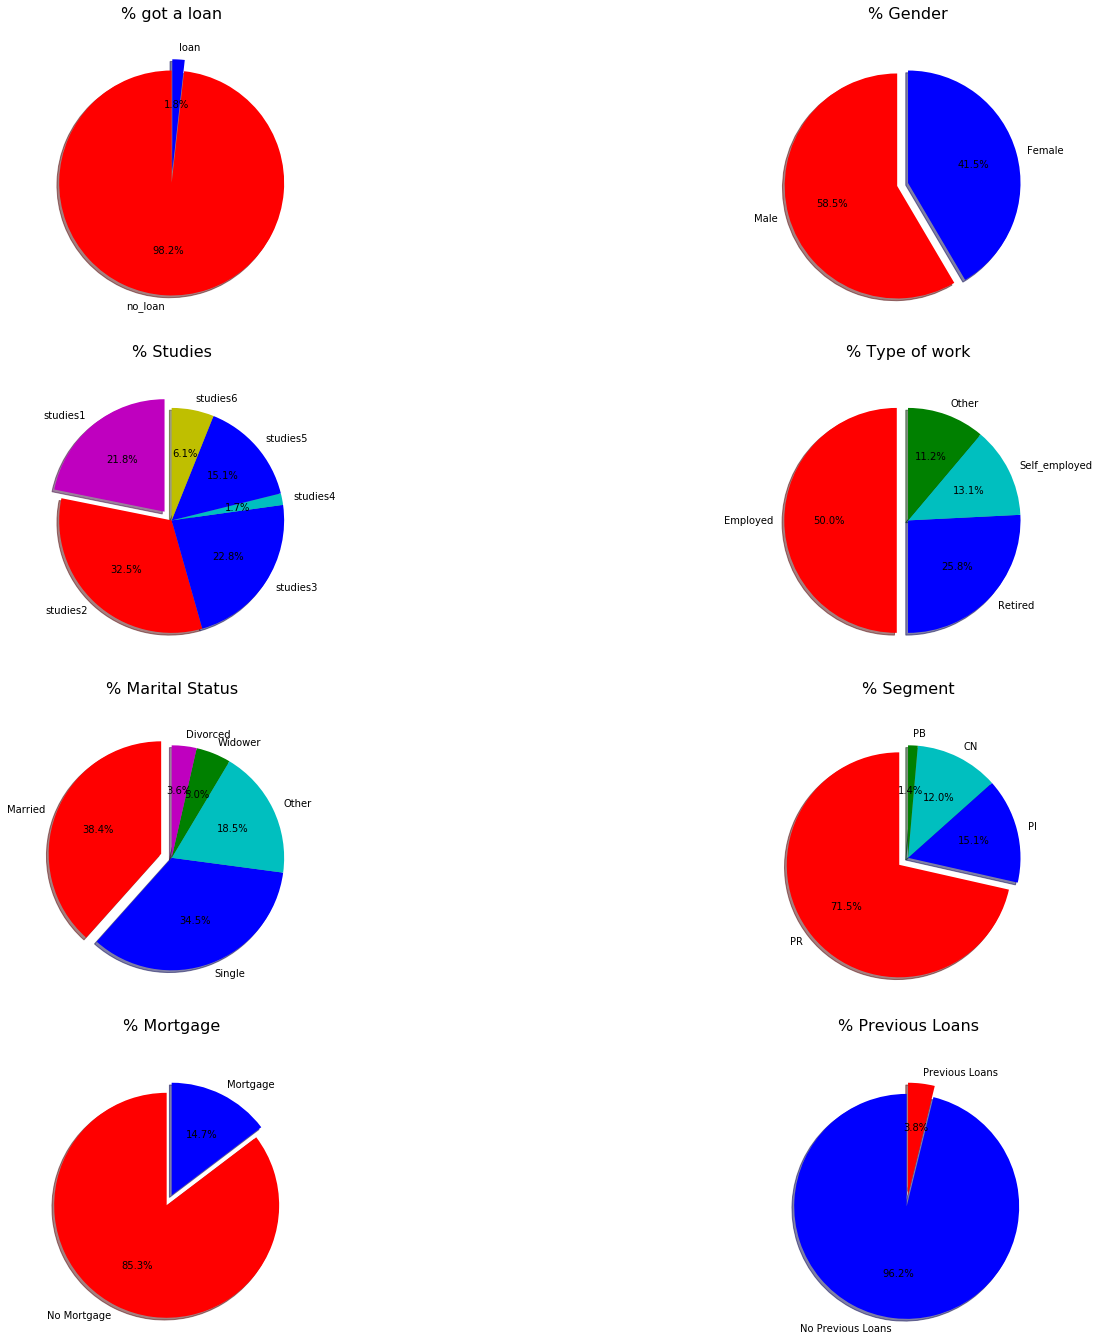

In [31]:
# 8. Plot all the categorical features without differenciating loan or not loan

#slices-count each score(pie plot)

df = categorical_file_final_graph.copy() 
compare_col_graph= 'got_loan'
plt.figure(figsize=(10,30))
'''values taking from the previous encoding results'''
val1,val2 = 0,1

''' count number clients with or without loan'''
no_loan = df.loc[df[compare_col_graph] == val1].count()
loan = df.loc[df[compare_col_graph] == val2].count()

plt.subplot(5, 2, 1)
title1 = '% got a loan\n'
plt.title(title1,fontsize = 16)
slices = [pd.Series(no_loan)[0],pd.Series(loan)[0]]
activities = ['no_loan','loan']
cols = ['r', 'b']
# plot

'''startangle :Angle from where the pie partitions start. In this case perpendicular to the tittle'''
'''shade: shade on the graph'''
'''explode: outstand some of the pie parts'''
'''autopct:include the percentage'''
plt.pie (slices,
        labels = activities,
        colors = cols,
        startangle = 90,  
        shadow = True,     
        explode = (0,0.1),  
        autopct = '%1.1f%%')  

# pie with gender

plt.subplot(5, 2, 2)
plt.subplots_adjust(right = 2)
title2 = '% Gender\n'
val1,val2 = 1,0

plt.title(title2,fontsize = 16)
compare_col_graph_gender= 'gender_dum'

male = df.loc[df[compare_col_graph_gender] == val1].count()
female = df.loc[df[compare_col_graph_gender] == val2].count() 

slices_gender = [pd.Series(male)[0],pd.Series(female)[0]]
activities_gender = ['Male','Female']
cols_gender = ['r','b']


plt.pie (slices_gender,
        labels = activities_gender,
        colors = cols_gender,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0),
        autopct = '%1.1f%%')

# pie with studies

plt.subplot(5, 2, 3)
# plt.subplots_adjust(right = 2.2)
title3 = '% Studies\n'
val1,val2,val3,val4,val5,val6 = 0,1,2,3,4,5
plt.title(title3,fontsize = 16)
compare_col_graph_work= 'studies_dum'

studies1 = df.loc[df[compare_col_graph_work] == val1].count()
studies2 = df.loc[df[compare_col_graph_work] == val2].count() 
studies3 = df.loc[df[compare_col_graph_work] == val3].count()
studies4 = df.loc[df[compare_col_graph_work] == val4].count() 
studies5 = df.loc[df[compare_col_graph_work] == val5].count() 
studies6 = df.loc[df[compare_col_graph_work] == val6].count()


slices_work = [pd.Series(studies1)[0],pd.Series(studies2)[0],pd.Series(studies3)[0],pd.Series(studies4)[0]
               ,pd.Series(studies5)[0],pd.Series(studies6)[0]]
activities_work = ['studies1','studies2','studies3','studies4','studies5','studies6']
cols_work = ['m', 'r', 'b','c','b','y']



plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0,0,0), 
        autopct = '%1.1f%%')  

# pie with type of work

plt.subplot(5, 2, 4)
plt.subplots_adjust(right = 2.2)
title4 = '% Type of work\n'
val1,val2,val3,val4 = 0,1,3,2
plt.title(title4,fontsize = 16)
compare_col_graph_work= 'work_type_dum'

employed = df.loc[df[compare_col_graph_work] == val1].count()
retired = df.loc[df[compare_col_graph_work] == val2].count() 
self_employed = df.loc[df[compare_col_graph_work] == val3].count()
other = df.loc[df[compare_col_graph_work] == val4].count() 

slices_work = [pd.Series(employed)[0],pd.Series(retired)[0],pd.Series(self_employed)[0],pd.Series(other)[0]]
activities_work = ['Employed','Retired','Self_employed','Other']
cols_work = ['r', 'b', 'c','g']



plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0), 
        autopct = '%1.1f%%')  

# pie with marital status

plt.subplot(5, 2, 5)
# plt.subplots_adjust(right = 2.2)
title5 = '% Marital Status\n'
val1,val2,val3,val4,val5 = 0,3,2,4,1
plt.title(title5,fontsize = 16)
compare_col_graph_work= 'marital_status_dum'

married = df.loc[df[compare_col_graph_work] == val1].count()
single = df.loc[df[compare_col_graph_work] == val2].count() 
other= df.loc[df[compare_col_graph_work] == val3].count()
widower = df.loc[df[compare_col_graph_work] == val4].count() 
divorced = df.loc[df[compare_col_graph_work] == val5].count()

slices_work = [pd.Series(married)[0],pd.Series(single)[0],pd.Series(other)[0],pd.Series(widower)[0],pd.Series(divorced)[0]]
activities_work = ['Married','Single','Other','Widower','Divorced']
cols_work = ['r', 'b', 'c','g','m']



plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0,0), 
        autopct = '%1.1f%%') 


# pie with segment

plt.subplot(5, 2, 6)
# plt.subplots_adjust(right = 2.2)
title6 = '% Segment\n'
val1,val2,val3,val4 = 3,2,0,1
plt.title(title6,fontsize = 16)
compare_col_graph_work= 'codseg_dum'

PR = df.loc[df[compare_col_graph_work] == val1].count()
PI = df.loc[df[compare_col_graph_work] == val2].count() 
CN = df.loc[df[compare_col_graph_work] == val3].count()
PB = df.loc[df[compare_col_graph_work] == val4].count() 

slices_work = [pd.Series(PR)[0],pd.Series(PI)[0],pd.Series(CN)[0],pd.Series(PB)[0]]
activities_work = ['PR','PI','CN','PB']
cols_work = ['r', 'b', 'c','g']

plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0), 
        autopct = '%1.1f%%') 

# pie with mortgage

plt.subplot(5, 2, 7)
plt.subplots_adjust(right = 2)
title7 = '% Mortgage\n'
val1,val2 = 0,1

plt.title(title7,fontsize = 16)
compare_col_graph_mortg= 'mortgage_dum'

no_mortg = df.loc[df[compare_col_graph_mortg] == val1].count()
mortg = df.loc[df[compare_col_graph_mortg] == val2].count() 

slices_mortg = [pd.Series(no_mortg)[0],pd.Series(mortg)[0]]
activities_mortg = ['No Mortgage','Mortgage']
cols_mortg = ['r','b']


plt.pie (slices_mortg,
        labels = activities_mortg,
        colors = cols_mortg,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0),
        autopct = '%1.1f%%')

# pie with previous loans

plt.subplot(5, 2, 8)
plt.subplots_adjust(right = 2)
title8 = '% Previous Loans\n'
val1,val2 = 0,1

plt.title(title8,fontsize = 16)
compare_col_graph_prevloans= 'previous_loans_dum'
no_prev_loans = df.loc[df[compare_col_graph_prevloans] == val1].count()
prev_loans = df.loc[df[compare_col_graph_prevloans] == val2].count() 

slices_prevloans = [pd.Series(no_prev_loans)[0],pd.Series(prev_loans)[0]]
activities_prevloans = ['No Previous Loans','Previous Loans']
cols_prevloans = ['b','r']


plt.pie (slices_prevloans,
        labels = activities_prevloans,
        colors = cols_prevloans,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0),
        autopct = '%1.1f%%')


plt.show()

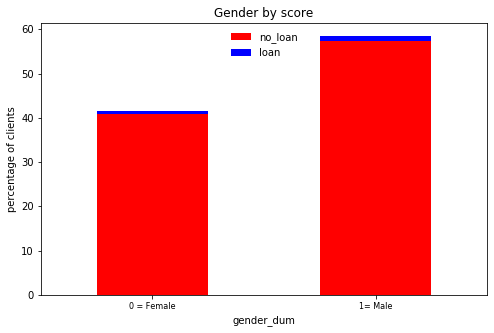

got_loan        0     1
gender_dum             
female      40.84  0.68
male        57.39  1.08


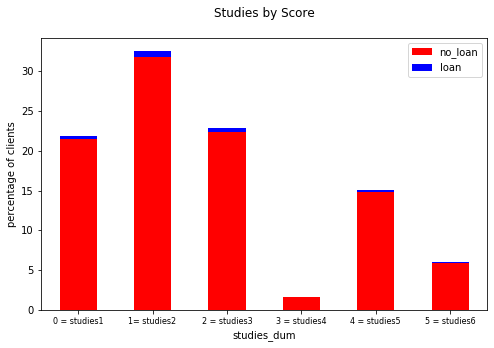

got_loan         0     1
studies_dum             
studies1     21.52  0.31
studies2     31.85  0.70
studies3     22.41  0.40
studies4      1.65  0.02
studies5     14.84  0.22
studies6      5.95  0.11


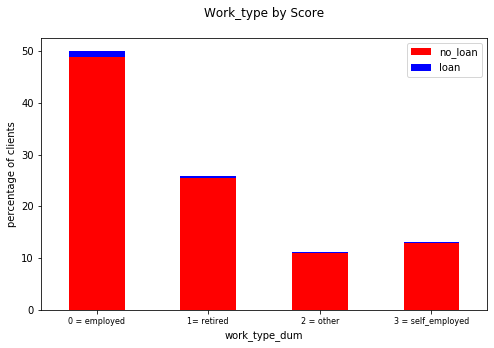

got_loan           0     1
work_type_dum             
employed       48.89  1.11
retired        25.50  0.29
other          11.01  0.14
self_employed  12.82  0.23


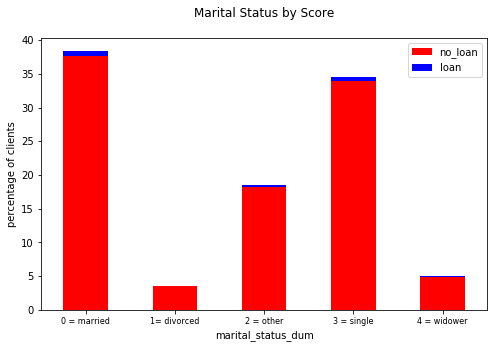

got_loan                0     1
marital_status_dum             
married             37.73  0.66
divorced             3.51  0.06
other               18.20  0.34
single              33.89  0.61
widower              4.91  0.09


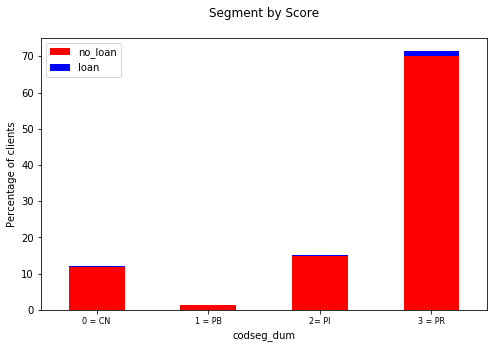

got_loan        0     1
codseg_dum             
CN          11.77  0.24
PB           1.38  0.01
PI          14.99  0.15
PR          70.09  1.37


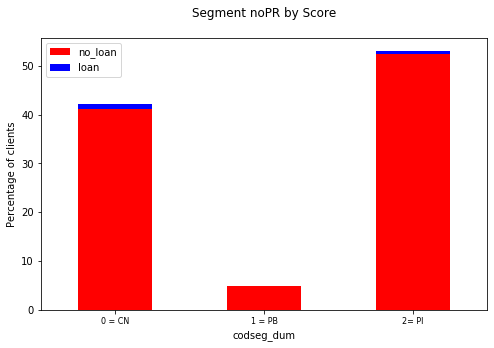

got_loan        0     1
codseg_dum             
CN          41.26  0.84
PB           4.83  0.04
PI          52.53  0.51


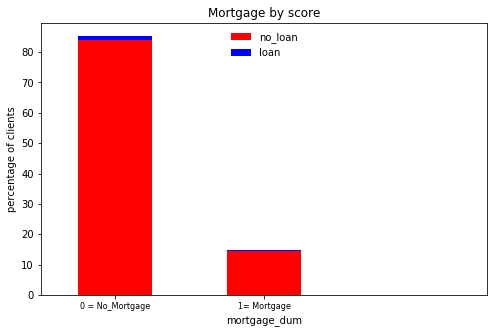

got_loan          0     1
mortgage_dum             
mortgage_no   83.86  1.45
mortgage_yes  14.35  0.32
2              0.03  0.00


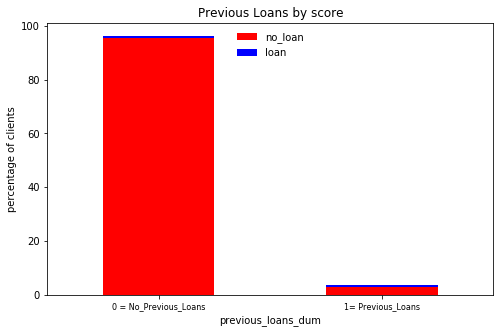

got_loan                0     1
previous_loans_dum             
previous_loans_no   95.27  0.91
previous_loans_yes   2.96  0.86


In [32]:
#  9. Same analysis done previously but differenciating with or without loan(bar plot)

# stacked graph
'''same values used'''
values_scored =  [0,1]

colors = ["r", "b"]

# gender

''' create df only with the columns i need'''
df_ge = df[['got_loan','gender_dum']]

''' group creating a new column counting the clients for each group'''
df_group_ge = df_ge.groupby(['got_loan','gender_dum'])['got_loan'].count().reset_index(name="count")
''' create percentage for each group category'''
percentage_dist_ge = 100 * df_group_ge[['count']].divide(df_group_ge[['count']].sum(), axis = 1)
''' drop the count so i keep only the percentage column'''
df_group_ge.drop(columns= 'count', inplace = True)
'''add the percentage column '''
gender_df= pd.concat([df_group_ge,percentage_dist_ge],axis = 1)

gender_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
'''transpose the df to create the stacked bar plot '''
pivot_df_ge = gender_df.pivot(index='gender_dum', columns='got_loan', values='percentage')

pivot_df_ge.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))

''' transpose to show the detail table underneath and rename the lengend '''
rename_df_ge = pivot_df_ge.rename(columns={"0": "No-Loan", "1": "Loan"},index={0 :"female",1: "male"})
'''round the values in the table under bar plot'''
rename_df_ge_r =rename_df_ge.round(2)

plt.title('Gender by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = Female','1= Male'],size = 8,rotation=0)
'''rename the legend and plot it in the center'''
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_ge_r)

# studies

df_st = df[['got_loan','studies_dum']]
df_group_st = df_st.groupby(['got_loan','studies_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_st = 100 * df_group_st[['count']].divide(df_group_st[['count']].sum(), axis = 1)
df_group_st.drop(columns= 'count', inplace = True)

st_df= pd.concat([df_group_st,percentage_dist_st],axis = 1)

st_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_st =st_df.pivot(index='studies_dum', columns='got_loan', values='percentage')

pivot_df_st.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_st = pivot_df_st.rename(columns={"0": "No-Loan", "1": "Loan"},
                                  index={0 :"studies1", 1: "studies2",2:"studies3",3:"studies4",4:"studies5",5:"studies6"})
                                                
rename_df_st_r =rename_df_st.round(2)

plt.title('Studies by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(6), ['0 = studies1','1= studies2', '2 = studies3', '3 = studies4','4 = studies5','5 = studies6'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_st_r)


# type of work

df_wt = df[['got_loan','work_type_dum']]
df_group_wt = df_wt.groupby(['got_loan','work_type_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_tiptrab = 100 * df_group_wt[['count']].divide(df_group_wt[['count']].sum(), axis = 1)
df_group_wt.drop(columns= 'count', inplace = True)

tiptraba_df= pd.concat([df_group_wt,percentage_dist_tiptrab],axis = 1)

tiptraba_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_wt = tiptraba_df.pivot(index='work_type_dum', columns='got_loan', values='percentage')

pivot_df_wt.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_wt = pivot_df_wt.rename(columns={"0": "No-Loan", "1": "Loan"},
                                  index={0 :"employed", 1: "retired",2:"other",3:"self_employed"})
                                                
rename_df_wt_r =rename_df_wt.round(2)

plt.title('Work_type by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(4), ['0 = employed','1= retired', '2 = other', '3 = self_employed'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_wt_r)

# marital status

df_ms = df[['got_loan','marital_status_dum']]
df_group_ms = df_ms.groupby(['got_loan','marital_status_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_ms = 100 * df_group_ms[['count']].divide(df_group_ms[['count']].sum(), axis = 1)
df_group_ms.drop(columns= 'count', inplace = True)

ms_df= pd.concat([df_group_ms,percentage_dist_ms],axis = 1)

ms_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_ms = ms_df.pivot(index='marital_status_dum', columns='got_loan', values='percentage')

pivot_df_ms.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_ms = pivot_df_ms.rename(columns={"0": "No-Loan", "1": "Loan"},
                                  index={0 :"married", 1: "divorced",2:"other",3:"single",4:"widower"})
                                                
rename_df_ms_r =rename_df_ms.round(2)

plt.title('Marital Status by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(5), ['0 = married','1= divorced', '2 = other', '3 = single', '4 = widower'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_ms_r)

# codseg_dum

df_seg = df[['got_loan','codseg_dum']]
df_group_seg = df_seg.groupby(['got_loan','codseg_dum'])['got_loan'].count().reset_index(name="count")
percentage_dist_seg = 100 * df_group_seg[['count']].divide(df_group_seg[['count']].sum(), axis = 1)
df_group_seg.drop(columns= 'count', inplace = True)
codseg_df= pd.concat([df_group_seg,percentage_dist_seg],axis = 1)

codseg_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg = codseg_df.pivot(index='codseg_dum', columns='got_loan', values='percentage')
pivot_df_seg.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg = pivot_df_seg.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0: "CN", 1: "PB", 2: "PI",3 : "PR"})
rename_df_seg_r =rename_df_seg.round(2)
plt.title('Segment by Score\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(4), ['0 = CN','1 = PB','2= PI','3 = PR'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_r)



# Segmento sin PR

df_seg_npr = df_seg.loc[df_seg['codseg_dum'] != 3]
df_group_seg_npr = df_seg_npr.groupby(['got_loan','codseg_dum'])['got_loan'].count().reset_index(name="count")
percentage_dist_seg_npr = 100 * df_group_seg_npr[['count']].divide(df_group_seg_npr[['count']].sum(), axis = 1)
df_group_seg_npr.drop(columns= 'count', inplace = True)
codseg_nopr_df= pd.concat([df_group_seg_npr,percentage_dist_seg_npr],axis = 1)

codseg_nopr_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg_npr = codseg_nopr_df.pivot(index='codseg_dum', columns='got_loan', values='percentage')
pivot_df_seg_npr.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg_npr = pivot_df_seg_npr.rename(columns={"0": "No-Loan", "1": "Loan"},
                                            index={0: "CN", 1: "PB", 2: "PI"})
rename_df_seg_npr_r =rename_df_seg_npr.round(2)

plt.title('Segment noPR by Score\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(3), ['0 = CN','1 = PB','2= PI'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_npr_r )


#mortgage

df_mor = df[['got_loan','mortgage_dum']]
df_group_mor = df_mor.groupby(['got_loan','mortgage_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_mor = 100 * df_group_mor[['count']].divide(df_group_mor[['count']].sum(), axis = 1)
df_group_mor.drop(columns= 'count', inplace = True)

mortgage_df= pd.concat([df_group_mor,percentage_dist_mor],axis = 1)

mortgage_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_mor = mortgage_df.pivot(index='mortgage_dum', columns='got_loan', values='percentage')

pivot_df_mor.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_mor = pivot_df_mor.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0 :"mortgage_no",1: "mortgage_yes"})
rename_df_mor_r =rename_df_mor.round(2)
plt.title('Mortgage by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No_Mortgage','1= Mortgage'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_mor_r)

#previous loans

df_prevloans = df[['got_loan','previous_loans_dum']]
df_group_prevloans = df_prevloans.groupby(['got_loan','previous_loans_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_prevloans = 100 * df_group_prevloans[['count']].divide(df_group_prevloans[['count']].sum(), axis = 1)
df_group_prevloans.drop(columns= 'count', inplace = True)

prevloans_df= pd.concat([df_group_prevloans,percentage_dist_prevloans],axis = 1)

prevloans_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_prevloans = prevloans_df.pivot(index='previous_loans_dum', columns='got_loan', values='percentage')

pivot_df_prevloans.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_prevloans = pivot_df_prevloans.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0 :"previous_loans_no",1: "previous_loans_yes"})
rename_df_prevloans_r =rename_df_prevloans.round(2)
plt.title('Previous Loans by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No_Previous_Loans','1= Previous_Loans'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_prevloans_r)


C:\Users\N58645\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


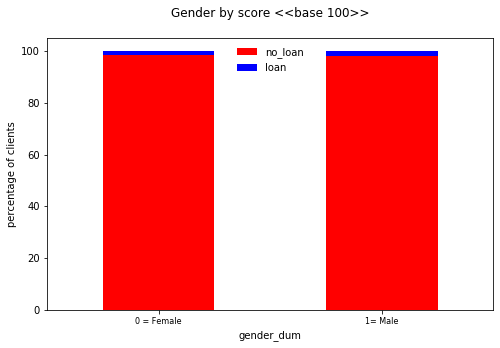

got_loan        0     1
gender_dum             
female      98.35  1.65
male        98.14  1.86


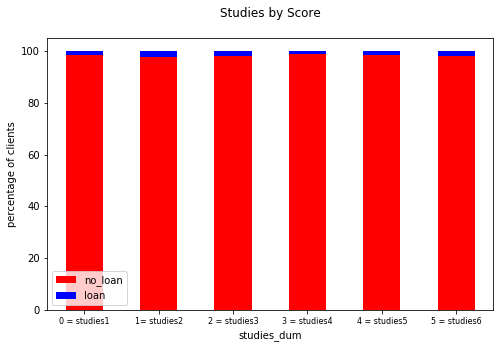

got_loan         0     1
studies_dum             
studies1     98.57  1.43
studies2     97.84  2.16
studies3     98.23  1.77
studies4     99.03  0.97
studies5     98.53  1.47
studies6     98.16  1.84


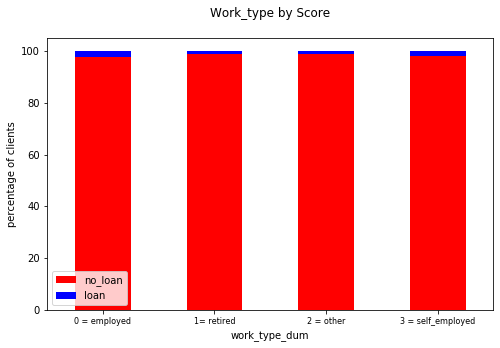

got_loan           0     1
work_type_dum             
employed       97.79  2.21
retired        98.87  1.13
other          98.75  1.25
self_employed  98.21  1.79


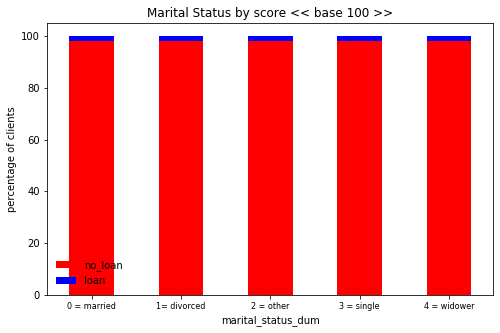

got_loan                0     1
marital_status_dum             
married             98.27  1.73
divorced            98.18  1.82
other               98.15  1.85
single              98.23  1.77
widower             98.27  1.73


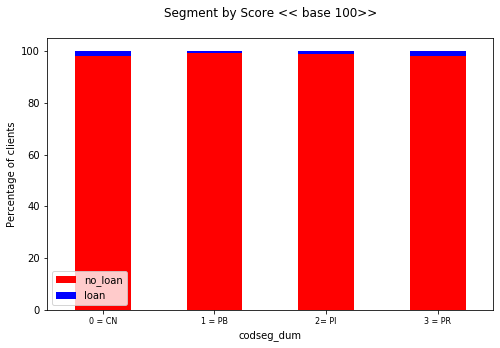

got_loan        0     1
codseg_dum             
CN          98.02  1.98
PB          99.20  0.80
PI          99.04  0.96
PR          98.08  1.92


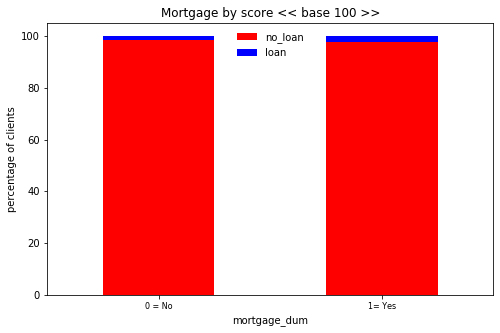

got_loan          0     1
mortgage_dum             
mortgage_no   98.30  1.70
mortgage_yes  97.81  2.19


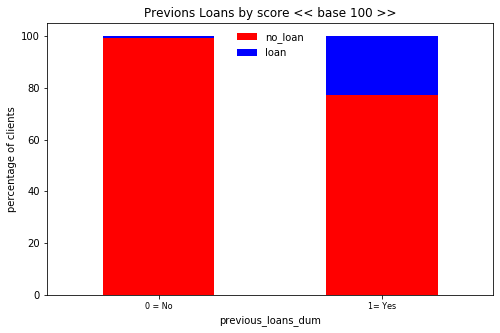

got_loan                0      1
previous_loans_dum              
Previous_Loans_no   99.06   0.94
Previous_Loans_yes  77.41  22.59


In [33]:
# 10. study to understand under which conditions the model gives a higher probability 
# of getting a loan of each group

col1= 'got_loan'
# gender base 100
''' create df only with the columns i need'''
df_gender = df[[col1,'gender_dum']]
''' group creating a new column cunting the clients for each group'''
df_group_gender = df_gender.groupby([col1,'gender_dum'])[col1].count().reset_index(name="count")
''' create percentage for each group category. In this case female and male'''
df_group_gender_0 =df_group_gender[df_group_gender['gender_dum'] == 0]
percentage_dist_gender_0 = 100 * df_group_gender_0[['count']].divide(df_group_gender_0[['count']].sum(), axis = 1)
''' drop the count so i keep only the percentage column'''
df_group_gender_0.drop(columns= 'count', inplace = True)
'''add the percentage column '''
gender_d_0= pd.concat([df_group_gender_0,percentage_dist_gender_0],axis = 1)


df_group_gender_1 =df_group_gender[df_group_gender['gender_dum'] == 1]
percentage_dist_gender_1 = 100 * df_group_gender_1[['count']].divide(df_group_gender_1[['count']].sum(), axis = 1)
df_group_gender_1.drop(columns= 'count', inplace = True)
gender_d_1= pd.concat([df_group_gender_1,percentage_dist_gender_1],axis = 1)


gender_df_base100= pd.concat([gender_d_0,gender_d_1],axis = 0)
gender_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
'''transpose the df to create the stacked bar plot '''
pivot_df_ge_base100 = gender_df_base100.pivot(index='gender_dum', columns=col1, values='percentage')

pivot_df_ge_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
''' transpose to show the detail table underneath and rename the lengend '''
rename_df_ge_base100 = pivot_df_ge_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"female",1: "male"})
'''round the values in the table underneath bar plot'''
rename_df_ge_r_base100 =rename_df_ge_base100.round(2)
plt.title('Gender by score <<base 100>>\n')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = Female','1= Male'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_ge_r_base100)

# Studies base 100

df_st = df[[col1,'studies_dum']]
df_group_st = df_st.groupby([col1,'studies_dum'])[col1].count().reset_index(name="count")

df_group_st_0 =df_group_st[df_group_st['studies_dum'] == 0]
percentage_dist_st_0 = 100 * df_group_st_0[['count']].divide(df_group_st_0[['count']].sum(), axis = 1)
df_group_st_0.drop(columns= 'count', inplace = True)
st_d_0= pd.concat([df_group_st_0,percentage_dist_st_0],axis = 1)
    
df_group_st_1 =df_group_st[df_group_st['studies_dum'] == 1]
percentage_dist_st_1 = 100 * df_group_st_1[['count']].divide(df_group_st_1[['count']].sum(), axis = 1)
df_group_st_1.drop(columns= 'count', inplace = True)
st_d_1= pd.concat([df_group_st_1,percentage_dist_st_1],axis = 1)

df_group_st_2 =df_group_st[df_group_st['studies_dum'] == 2]
percentage_dist_st_2 = 100 * df_group_st_2[['count']].divide(df_group_st_2[['count']].sum(), axis = 1)
df_group_st_2.drop(columns= 'count', inplace = True)
st_d_2= pd.concat([df_group_st_2,percentage_dist_st_2],axis = 1)

df_group_st_3=df_group_st[df_group_st['studies_dum'] == 3]
percentage_dist_st_3 = 100 * df_group_st_3[['count']].divide(df_group_st_3[['count']].sum(), axis = 1)
df_group_st_3.drop(columns= 'count', inplace = True)
st_d_3= pd.concat([df_group_st_3,percentage_dist_st_3],axis = 1)

df_group_st_4=df_group_st[df_group_st['studies_dum'] == 4]
percentage_dist_st_4 = 100 * df_group_st_4[['count']].divide(df_group_st_4[['count']].sum(), axis = 1)
df_group_st_4.drop(columns= 'count', inplace = True)
st_d_4= pd.concat([df_group_st_4,percentage_dist_st_4],axis = 1)

df_group_st_5=df_group_st[df_group_st['studies_dum'] == 5]
percentage_dist_st_5 = 100 * df_group_st_5[['count']].divide(df_group_st_5[['count']].sum(), axis = 1)
df_group_st_5.drop(columns= 'count', inplace = True)
st_d_5= pd.concat([df_group_st_5,percentage_dist_st_5],axis = 1)

st_df_base100= pd.concat([st_d_0,st_d_1,st_d_2,st_d_3,st_d_4,st_d_5],axis = 0)

st_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_st_base100 = st_df_base100.pivot(index='studies_dum', columns=col1, values='percentage')

pivot_df_st_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_st_base100 = pivot_df_st_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"studies1",1: "studies2",2:"studies3",3:"studies4",4:"studies5",5:"studies6"})
rename_df_st_r_base100 =rename_df_st_base100.round(2)
plt.title('Studies by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(6), ['0 = studies1','1= studies2', '2 = studies3', '3 = studies4', '4 = studies5', '5 = studies6'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_st_r_base100)

# type of work base 100

df_wt = df[[col1,'work_type_dum']]
df_group_wt = df_wt.groupby([col1,'work_type_dum'])[col1].count().reset_index(name="count")

df_group_wt_0 =df_group_wt[df_group_wt['work_type_dum'] == 0]
percentage_dist_wt_0 = 100 * df_group_wt_0[['count']].divide(df_group_wt_0[['count']].sum(), axis = 1)
df_group_wt_0.drop(columns= 'count', inplace = True)
wt_d_0= pd.concat([df_group_wt_0,percentage_dist_wt_0],axis = 1)
    
df_group_wt_1 =df_group_wt[df_group_wt['work_type_dum'] == 1]
percentage_dist_wt_1 = 100 * df_group_wt_1[['count']].divide(df_group_wt_1[['count']].sum(), axis = 1)
df_group_wt_1.drop(columns= 'count', inplace = True)
wt_d_1= pd.concat([df_group_wt_1,percentage_dist_wt_1],axis = 1)

df_group_wt_2 =df_group_wt[df_group_wt['work_type_dum'] == 2]
percentage_dist_wt_2 = 100 * df_group_wt_2[['count']].divide(df_group_wt_2[['count']].sum(), axis = 1)
df_group_wt_2.drop(columns= 'count', inplace = True)
wt_d_2= pd.concat([df_group_wt_2,percentage_dist_wt_2],axis = 1)

df_group_wt_3=df_group_wt[df_group_wt['work_type_dum'] == 3]
percentage_dist_wt_3 = 100 * df_group_wt_3[['count']].divide(df_group_wt_3[['count']].sum(), axis = 1)
df_group_wt_3.drop(columns= 'count', inplace = True)
wt_d_3= pd.concat([df_group_wt_3,percentage_dist_wt_3],axis = 1)

wt_df_base100= pd.concat([wt_d_0,wt_d_1,wt_d_2,wt_d_3],axis = 0)

wt_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_wt_base100 = wt_df_base100.pivot(index='work_type_dum', columns=col1, values='percentage')

pivot_df_wt_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_wt_base100 = pivot_df_wt_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"employed",1: "retired",2:"other",3:"self_employed"})
rename_df_wt_r_base100 =rename_df_wt_base100.round(2)
plt.title('Work_type by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(4), ['0 = employed','1= retired', '2 = other', '3 = self_employed'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_wt_r_base100)

# marital status base 100

df_ms = df[[col1,'marital_status_dum']]
df_group_ms = df_ms.groupby([col1,'marital_status_dum'])[col1].count().reset_index(name="count")

df_group_ms_0 =df_group_ms[df_group_ms['marital_status_dum'] == 0]
percentage_dist_ms_0 = 100 * df_group_ms_0[['count']].divide(df_group_ms_0[['count']].sum(), axis = 1)
df_group_ms_0.drop(columns= 'count', inplace = True)
ms_d_0= pd.concat([df_group_ms_0,percentage_dist_ms_0],axis = 1)

df_group_ms_1 =df_group_ms[df_group_ms['marital_status_dum'] == 1]
percentage_dist_ms_1 = 100 * df_group_ms_1[['count']].divide(df_group_ms_1[['count']].sum(), axis = 1)
df_group_ms_1.drop(columns= 'count', inplace = True)
ms_d_1= pd.concat([df_group_ms_1,percentage_dist_ms_1],axis = 1)

df_group_ms_2 =df_group_ms[df_group_ms['marital_status_dum'] == 2]
percentage_dist_ms_2 = 100 * df_group_ms_2[['count']].divide(df_group_ms_2[['count']].sum(), axis = 1)
df_group_ms_2.drop(columns= 'count', inplace = True)
ms_d_2= pd.concat([df_group_ms_2,percentage_dist_ms_2],axis = 1)

df_group_ms_3 =df_group_ms[df_group_ms['marital_status_dum'] == 3]
percentage_dist_ms_3 = 100 * df_group_ms_3[['count']].divide(df_group_ms_3[['count']].sum(), axis = 1)
df_group_ms_3.drop(columns= 'count', inplace = True)
ms_d_3= pd.concat([df_group_ms_3,percentage_dist_ms_3],axis = 1)

df_group_ms_4 =df_group_ms[df_group_ms['marital_status_dum'] == 4]
percentage_dist_ms_4 = 100 * df_group_ms_4[['count']].divide(df_group_ms_4[['count']].sum(), axis = 1)
df_group_ms_4.drop(columns= 'count', inplace = True)
ms_d_4= pd.concat([df_group_ms_4,percentage_dist_ms_4],axis = 1)


ms_df_base100= pd.concat([ms_d_0,ms_d_1,ms_d_2,ms_d_3,ms_d_4],axis = 0)

ms_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_ms_base100 = ms_df_base100.pivot(index='marital_status_dum', columns='got_loan', values='percentage')

pivot_df_ms_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_ms_base100 = pivot_df_ms_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"married", 1: "divorced",2:"other",3:"single",4:"widower"})
rename_df_ms_r_base100 =rename_df_ms_base100.round(2)
plt.title('Marital Status by score << base 100 >>')
plt.ylabel('percentage of clients')
plt.xticks (range(5), ['0 = married','1= divorced', '2 = other', '3 = single', '4 = widower'],size = 8,rotation=0)
plt.legend(labels = activities, frameon=False)
plt.show()
print(rename_df_ms_r_base100)

# codseg_dum base 100 


df_seg = df[[col1,'codseg_dum']]
df_group_seg = df_seg.groupby([col1,'codseg_dum'])[col1].count().reset_index(name="count")

df_group_seg_0 =df_group_seg[df_group_seg['codseg_dum'] == 0]
percentage_dist_seg_0 = 100 * df_group_seg_0[['count']].divide(df_group_seg_0[['count']].sum(), axis = 1)
df_group_seg_0.drop(columns= 'count', inplace = True)
seg_d_0= pd.concat([df_group_seg_0,percentage_dist_seg_0],axis = 1)
    
df_group_seg_1 =df_group_seg[df_group_seg['codseg_dum'] == 1]
percentage_dist_seg_1 = 100 * df_group_seg_1[['count']].divide(df_group_seg_1[['count']].sum(), axis = 1)
df_group_seg_1.drop(columns= 'count', inplace = True)
seg_d_1= pd.concat([df_group_seg_1,percentage_dist_seg_1],axis = 1)

df_group_seg_2 =df_group_seg[df_group_seg['codseg_dum'] == 2]
percentage_dist_seg_2 = 100 * df_group_seg_2[['count']].divide(df_group_seg_2[['count']].sum(), axis = 1)
df_group_seg_2.drop(columns= 'count', inplace = True)
seg_d_2= pd.concat([df_group_seg_2,percentage_dist_seg_2],axis = 1)

df_group_seg_3=df_group_seg[df_group_seg['codseg_dum'] == 3]
percentage_dist_seg_3 = 100 * df_group_seg_3[['count']].divide(df_group_seg_3[['count']].sum(), axis = 1)
df_group_seg_3.drop(columns= 'count', inplace = True)
seg_d_3= pd.concat([df_group_seg_3,percentage_dist_seg_3],axis = 1)

seg_df_base100= pd.concat([seg_d_0,seg_d_1,seg_d_2,seg_d_3],axis = 0)

seg_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg_base100 = seg_df_base100.pivot(index='codseg_dum', columns=col1, values='percentage')

pivot_df_seg_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg_base100 = pivot_df_seg_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"CN",1: "PB",2:"PI",3:"PR"})
rename_df_seg_r_base100 =rename_df_seg_base100.round(2)
plt.title('Segment by Score << base 100>>\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(4), ['0 = CN','1 = PB','2= PI','3 = PR'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_r_base100)



# mortgage base 100

df_mor = df[[col1,'mortgage_dum']]
df_group_mor = df_mor.groupby([col1,'mortgage_dum'])[col1].count().reset_index(name="count")

df_group_mor_0 =df_group_mor[df_group_mor['mortgage_dum'] == 0]
percentage_dist_mor_0 = 100 * df_group_mor_0[['count']].divide(df_group_mor_0[['count']].sum(), axis = 1)
df_group_mor_0.drop(columns= 'count', inplace = True)
mortgage_d_0= pd.concat([df_group_mor_0,percentage_dist_mor_0],axis = 1)

df_group_mor_1 =df_group_mor[df_group_mor['mortgage_dum'] == 1]
percentage_dist_mor_1 = 100 * df_group_mor_1[['count']].divide(df_group_mor_1[['count']].sum(), axis = 1)
df_group_mor_1.drop(columns= 'count', inplace = True)
mortgage_d_1= pd.concat([df_group_mor_1,percentage_dist_mor_1],axis = 1)

mortgage_df_base100= pd.concat([mortgage_d_0,mortgage_d_1],axis = 0)

mortgage_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_mor_base100 = mortgage_df_base100.pivot(index='mortgage_dum', columns='got_loan', values='percentage')

pivot_df_mor_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_mor_base100 = pivot_df_mor_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"mortgage_no",1: "mortgage_yes"})
rename_df_mor_r_base100 =rename_df_mor_base100.round(2)
plt.title('Mortgage by score << base 100 >>')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No','1= Yes'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_mor_r_base100)


# Previous Loans base 100

df_prevloans = df[[col1,'previous_loans_dum']]
df_group_prevloans = df_prevloans.groupby([col1,'previous_loans_dum'])[col1].count().reset_index(name="count")

df_group_prevloans_0 =df_group_prevloans[df_group_prevloans['previous_loans_dum'] == 0]
percentage_dist_prevloans_0 = 100 * df_group_prevloans_0[['count']].divide(df_group_prevloans_0[['count']].sum(), 
                                                                           axis = 1)
df_group_prevloans_0.drop(columns= 'count', inplace = True)
prevloans_d_0= pd.concat([df_group_prevloans_0,percentage_dist_prevloans_0],axis = 1)

df_group_prevloans_1 =df_group_prevloans[df_group_prevloans['previous_loans_dum'] == 1]
percentage_dist_prevloans_1 = 100 * df_group_prevloans_1[['count']].divide(df_group_prevloans_1[['count']].sum(),
                                                                           axis = 1)
df_group_prevloans_1.drop(columns= 'count', inplace = True)
prevloans_d_1= pd.concat([df_group_prevloans_1,percentage_dist_prevloans_1],axis = 1)

prevloans_df_base100= pd.concat([prevloans_d_0,prevloans_d_1],axis = 0)

prevloans_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_prevloans_base100 = prevloans_df_base100.pivot(index='previous_loans_dum', columns='got_loan',
                                                        values='percentage')

pivot_df_prevloans_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_prevloans_base100 = pivot_df_prevloans_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"Previous_Loans_no",1: "Previous_Loans_yes"})
rename_df_prevloans_r_base100 =rename_df_prevloans_base100.round(2)
plt.title('Previons Loans by score << base 100 >>')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No','1= Yes'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_prevloans_r_base100)



### b.Numerical features visualization

C:\Users\N58645\anaconda3\lib\site-packages\seaborn\distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


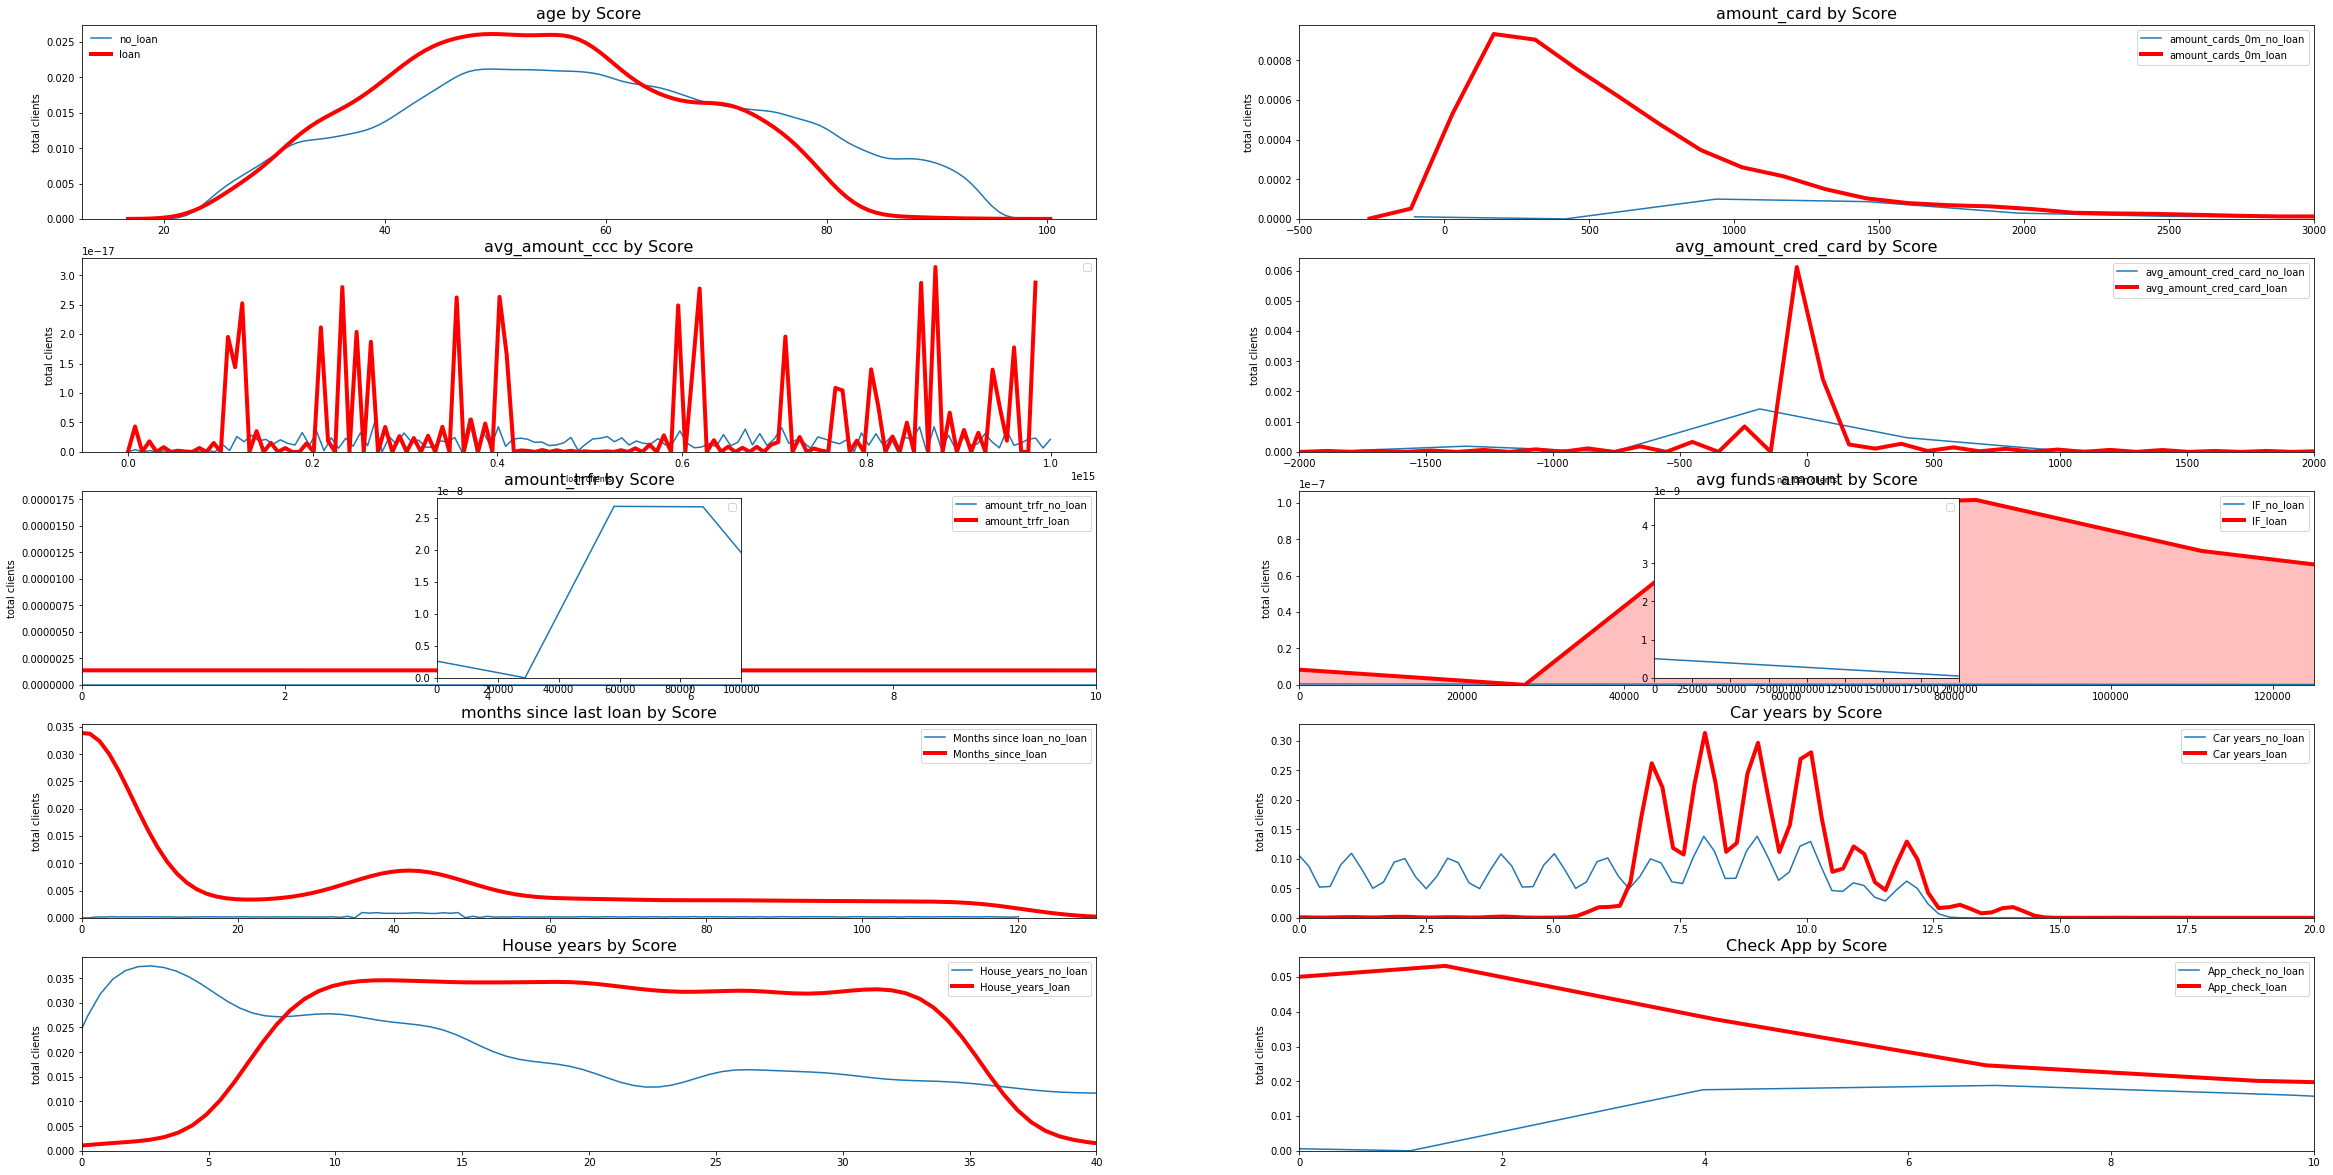

In [34]:
# 1. Using kdeplot from seaborn, plot numerical features which stand out as relevant
'''as usual make a copy of the original dataset'''
graph_df = total_clients_mod.copy()

'''define the variable we are going to use for comparison'''
compare_col_graph = 'got_loan'
'''use the values of the dependent variable'''
val1,val2 = 0,1

''' count number clients with and without loan.Record in a variable'''
no_loan_graph = graph_df.loc[graph_df[compare_col_graph] == val1]
loan_graph = graph_df.loc[graph_df[compare_col_graph] == val2]

 # 2. Initialize the figure,size. Subplot also define the number of plots and its position
plt.figure(figsize=(40,25))
plt.subplot(6, 2, 1)

# 3. Plotting feature 'age'

'''set the title and size.
Define the feature to plot together with got loan values 0 and 1.Define different color and width for got_loan=1 
Set the frame and the legend positioning. 
Name the plot '''

plt.title('age by Score',fontsize = 16)
kdeplot(no_loan_graph.age,label='no_loan',)
kdeplot(loan_graph.age,label='loan',linewidth=4,c='r')
plt.legend(loc='upper left',frameon=False)
plt.ylabel('total clients')


# 4. Plotting feature 'amount_cards_0m'

plt.subplot(6, 2, 2)

plt.title('amount_card by Score',fontsize = 16)

kdeplot(no_loan_graph.amount_cards_0m,label= 'amount_cards_0m_no_loan')
kdeplot(loan_graph.amount_cards_0m,label='amount_cards_0m_loan',linewidth=4,c='r')

plt.xlim(-500, 3000)
plt.ylabel('total clients')


# 5. Plotting feature 'avg_amount_ccc'

ax = plt.subplot(6, 2, 3)

plt.title('avg_amount_ccc by Score',fontsize = 16)

kdeplot(no_loan_graph.aveg_amount_current_acc_0m,label= 'aveg_amount_current_acc_0m_no_loan')
kdeplot(loan_graph.aveg_amount_current_acc_0m,label='iaveg_amount_current_acc_0m_loan', linewidth=4,c='r')
# plt.xlim(0, 20000)
plt.ylabel('total clients')

# plt.title('Loan clients\n',fontsize = 8)
# kdeplot(no_loan_graph.aveg_amount_current_acc_0m)
# kdeplot(loan_graph.aveg_amount_current_acc_0m, shade = True,c='r')
# plt.xlim(0, 500000)
plt.legend('')


# 6. Plotting feature 'avg_amount_cred_card_0m'

plt.subplot(6, 2, 4)

plt.title('avg_amount_cred_card by Score',fontsize = 16)

kdeplot(no_loan_graph.aveg_amount_cred_card_0m,label='avg_amount_cred_card_no_loan')
kdeplot(loan_graph.aveg_amount_cred_card_0m,label='avg_amount_cred_card_loan',linewidth=4,c='r')
plt.xlim(-2000,2000)
plt.ylabel('total clients')

# 7. Plotting feature 'amount_trfr_0m'

ax = plt.subplot(6, 2, 5)

plt.title('amount_trfr by Score',fontsize = 16)

kdeplot(no_loan_graph.amount_trfr_0m,label='amount_trfr_no_loan')
kdeplot(loan_graph.amount_trfr_0m,label='amount_trfr_loan',linewidth=4,c='r')
plt.xlim(0,10)
plt.legend(loc = 'upper right')
plt.ylabel('total clients')

inset = inset_axes(ax, 
                   width="30%", # width = 30% of parent_bbox
                   height=2.5, # height : 1 inch
                   loc=10)

plt.title('loan clients\n',fontsize = 8)
kdeplot(no_loan_graph.amount_trfr_0m)
# kdeplot(loan_graph.imp_trfr_0m,shade = True)
plt.xlim(0,100000)
plt.legend('')

# 8. Plotting feature 'aveg_amount_invest_funds_0m'

ax=plt.subplot(6, 2, 6)

plt.title('avg funds amount by Score',fontsize = 16)

kdeplot(no_loan_graph.aveg_amount_invest_funds_0m,label='IF_no_loan')
kdeplot(loan_graph.aveg_amount_invest_funds_0m,label='IF_loan',linewidth=4,shade = True,c='r')
plt.xlim(0,125000)
plt.ylabel('total clients')

inset = inset_axes(ax, 
                   width="30%", # width = 30% of parent_bbox
                   height=2.5, # height : 1 inch
                   loc=10)

plt.title('no_loan clients\n',fontsize = 8)
kdeplot(no_loan_graph.aveg_amount_invest_funds_0m)
# kdeplot(loan_graph.imp_trfr_0m,shade = True)
plt.xlim(0,200000)
plt.legend('')

# 9. Plotting feature 'Months since loan'

plt.subplot(6, 2, 7)

plt.title('months since last loan by Score',fontsize = 16)

kdeplot(no_loan_graph.months_since_loan,label='Months since loan_no_loan')
kdeplot(loan_graph.months_since_loan,label='Months_since_loan',linewidth=4,c='r')
plt.xlim(0,130)
plt.ylabel('total clients')

# 10. Plotting feature 'Car Years'
plt.subplot(6, 2, 8)

plt.title('Car years by Score',fontsize = 16)

kdeplot(no_loan_graph.car_years,label='Car years_no_loan')
kdeplot(loan_graph.car_years,label='Car years_loan',linewidth=4,c='r')
plt.xlim(0,20)
plt.ylabel('total clients')

# 11. Plotting feature 'House years'
plt.subplot(6, 2, 9)

plt.title('House years by Score',fontsize = 16)

kdeplot(no_loan_graph.House_years,label='House_years_no_loan')
kdeplot(loan_graph.House_years,label='House_years_loan',linewidth=4,c='r')
plt.xlim(0,40)
plt.ylabel('total clients')

# 12. Plotting feature 'App check'

plt.subplot(6, 2, 10)

plt.title('Check App by Score',fontsize = 16)

kdeplot(no_loan_graph.app_par_0m,label='App_check_no_loan')
kdeplot(loan_graph.app_par_0m,label='App_check_loan',linewidth=4,c='r')
plt.xlim(0,10)
plt.ylabel('total clients')

plt.show()


### GPS 

In [118]:
# 1.  Clients geolocalitation by province total and the ones who got  a loan  

# 2. Need to install first folium :conda install -c conda-forge folium
'''download the map 4 files to local folder and read de shp file '''
polygon_path = os.path.abspath("Provincias.shp")
polygon_pc = gpd.read_file(polygon_path)
polygon_pc['COD_CCAA'] = polygon_pc['COD_CCAA'].astype(int)
''' select the column from my file,change column name to use as key with previous 
file polygon_pc and group the clients by postal code'''

pc_data = total_clients_mod[['cprovper']].rename(columns={ 'cprovper' : 'COD_CCAA'})
pc_data_gp=pc_data.groupby(['COD_CCAA'])['COD_CCAA'].count().reset_index(name="clients")
pc_data_gp=pc_data_gp[pc_data_gp.COD_CCAA != 11111]


'''only with Loan'''

Loan = pd.concat([total_clients_mod[['cprovper']],categorical_file_final_graph[['got_loan']]],axis = 1)
Loan['got_loan'] = Loan['got_loan'].astype(float)
Loan_filt = Loan[Loan['got_loan']> 0]
pc_data_hs = Loan_filt[['cprovper']].rename(columns={ 'cprovper' : 'COD_CCAA'})
pc_data_gp_hs=pc_data_hs.groupby(['COD_CCAA'])['COD_CCAA'].count().reset_index(name="clients")

'''weight no loan clients by province'''
weight_l_clients = (pc_data_gp_hs.clients/pc_data_gp.clients).to_frame()
weight_l_clients_graph = pd.concat([pc_data_gp.COD_CCAA,weight_l_clients],axis =1).astype(float)

'''pass your starting coordinates to folium to create a base map.This will represent the object'''
m = folium.Map(location=[ 40.4636688, -3.7492199], zoom_start=6)

'''Choropleth is used for binding the data between Pandas DataFrames and JSON geometries.Sequential 
color schemes are built-in to the library, and can be passed to visualize different combinations'''

''' In this case the total number os customers by province with a Loan'''

data1 =folium.Choropleth(
       geo_data=polygon_pc,
       name='choropleth',
       data=pc_data_gp,
       columns=['COD_CCAA', 'clients'],
       key_on= 'feature.properties.COD_CCAA',
       fill_color='YlOrRd',
       fill_opacity=0.6,
       line_opacity=0.2,
       highlight=True,
       show=True,
       legend_name='Clients with Loan by province'
).add_to(m)

''' 2 maps will be added. This second one with the percentage of loans by province/ number of clients'''

data2 = folium.Choropleth(
        geo_data=polygon_pc,
        name='choropleth',
        data=weight_l_clients_graph,
        columns=['COD_CCAA', 'clients'],
        key_on= 'feature.properties.COD_CCAA',
        fill_color='YlGn',
        fill_opacity=0.6,
        line_opacity=0.2,
        legend_name='Weighted Clients with Loan by province '
).add_to(m)

# 3. Create a LayerControl object to be added on a folium map. 
#    It wont collapse into an icon but a simple tick will swap the map

folium.LayerControl(collapsed=False).add_to(m)

# 4. Save the info into a html file
m.save('Clients_by_province loans and no loans.html')

from IPython.display import HTML

# Global Surrogate Method

### a.Correlation between features

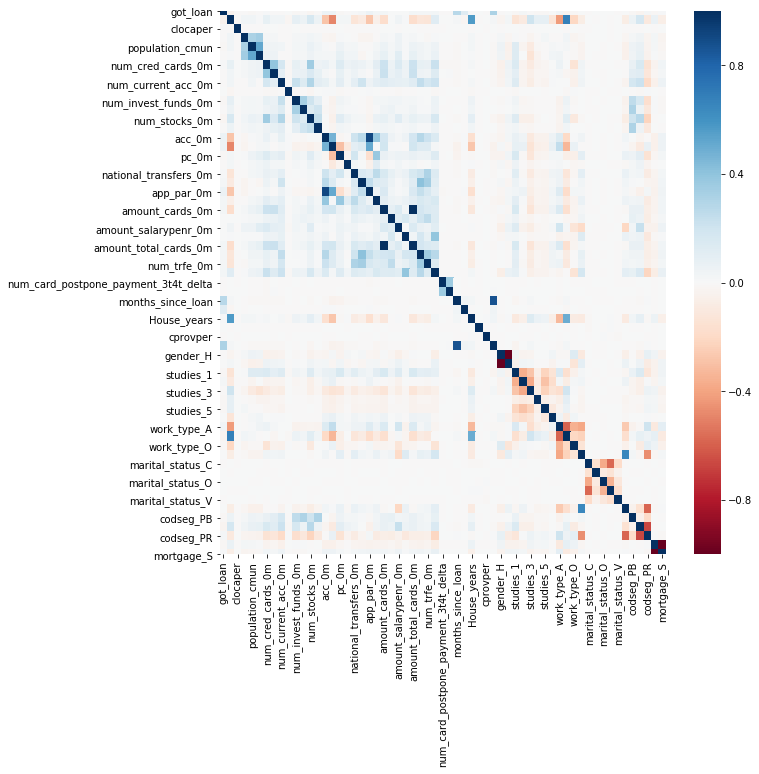

In [36]:
# Heatmap to get a quick view of the correlation between the features

'''Plot a dataframe with meaningful row and column labels 
https://seaborn.pydata.org/generated/seaborn.heatmap.html'''

plt.figure(figsize=(10,10))
sns.heatmap(total_clients_mod.corr(), cmap= 'RdBu')

In [116]:
# Top varibles correlation 

# '''List highest correlation pairs from a correlation matrix '''

# pd.set_option('display.max_rows',60)

# def get_redundant_pairs(total_clients_mod):
#     '''Get diagonal and lower triangular pairs of correlation matrix'''
#     ''' function to drop redundant pair of variables'''
#     pairs_to_drop = set()
#     cols = total_clients_mod.columns
#     for i in range(0, total_clients_mod.shape[1]):
#         for j in range(0, i+1):
#             pairs_to_drop.add((cols[i], cols[j]))
#     return pairs_to_drop

# def get_top_abs_correlations(total_clients_mod, n=5):
#     au_corr = total_clients_mod.corr().abs().unstack()
#     labels_to_drop = get_redundant_pairs(total_clients_mod)
# ​pairs_to_drop = set()    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
#     return au_corr[0:n]

# print("Top Absolute Correlations")
# print(get_top_abs_correlations(total_clients_mod, 60))# 

In [123]:
# Top varibles absolute correlation 

'''List highest absolute correlation pairs from a correlation matrix. Unstack and order to get the most 
correlated pairs '''
'''set_option, allows displaying the number of rows we require in this particular analysis'''
pd.set_option('display.max_rows',15)
print("Top absolute Correlation pairs")
correla = total_clients_mod.corr().abs().unstack().sort_values(ascending=False).drop_duplicates().round(4)
correla[:15]

Top absolute Correlation pairs


amount_total_cards_0m  amount_cards_0m      1.0000
mortgage_S             mortgage_S           1.0000
mortgage_N             mortgage_S           0.9989
acc_0m                 app_par_0m           0.9088
previous_loans         months_since_loan    0.8703
work_type_J            age                  0.6861
codseg_PI              codseg_PR            0.6683
work_type_P            codseg_CN            0.6549
work_type_A            work_type_J          0.5895
codseg_PR              codseg_CN            0.5847
marital_status_C       marital_status_S     0.5729
House_years            age                  0.5660
disporent_cmun         population_cmun      0.5182
app_par_0m             mobile_0m            0.5151
House_years            work_type_J          0.4966
dtype: float64

In [119]:
#Correlation with output variable
cor_target = abs(cor['got_loan'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

got_loan          1.000000
previous_loans    0.314747
Name: got_loan, dtype: float64

In [134]:
# #Adding constant column of ones, mandatory for sm.OLS model.Backward Elimination
# total_clients_mod_fs = total_clients_mod.copy()

# X_fs = total_clients_mod_fs.loc[:, total_clients_mod_fs.columns != 'got_loan']
# y_fs = total_clients_mod_fs.loc[:, total_clients_mod_fs.columns == 'got_loan']

# import statsmodels.api as sm

# X_1 = sm.add_constant(X_fs)
# #Fitting sm.OLS model
# model = sm.OLS(y_fs,X_1).fit()
# pd.set_option('display.max_rows',15)
# sh = model.pvalues.round(4).sort_values(ascending=False)
# sh[:15]

num_card_postpone_payment_3t4t_delta    0.9149
aveg_amount_stocks_0m                   0.8311
cpper                                   0.8216
amount_trfr_0m                          0.6972
codseg_PR                               0.6935
num_trfe_0m                             0.5812
aveg_amount_invest_funds_0m             0.5006
num_current_acc_0m                      0.4761
clocaper                                0.3686
marital_status_D                        0.3594
autonper                                0.2243
aveg_amount_current_acc_0m              0.2082
studies_4                               0.2060
national_transfers_0m                   0.1854
num_invest_funds_0m                     0.1800
dtype: float64

In [271]:
#Backward Elimination
#Adding constant column of ones, mandatory for sm.OLS model.Backward Elimination with pvalues 
total_clients_mod_fs = total_clients_mod.copy()

''' split dependent feature from the dataset'''
X_fs = total_clients_mod_fs.loc[:, total_clients_mod_fs.columns != 'got_loan']
y_fs = total_clients_mod_fs.loc[:, total_clients_mod_fs.columns == 'got_loan']

''' create iteration. drop features with pvalue higher than 0.05'''
cols = list(X_fs.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_fs[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_fs,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_ = cols
print(selected_features_)
print('the final number of features is :', len(selected_features_))

C:\Users\N58645\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['age', 'population_cmun', 'num_cred_cards_0m', 'aveg_amount_cred_card_0m', 'num_stocks_0m', 'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m', 'app_par_0m', 'web_par_0m', 'amount_cards_0m', 'amount_rec_0m', 'amount_total_cards_0m', 'num_rec_0m', 'aved_amount_postpone_payment_3t4t_delta', 'months_since_loan', 'car_years', 'House_years', 'cprovper', 'previous_loans', 'gender_H', 'gender_V', 'studies_1', 'studies_2', 'studies_3', 'work_type_A', 'work_type_J', 'work_type_O', 'work_type_P', 'codseg_PB', 'codseg_PI', 'mortgage_N']
the final number of features are : 33


In [147]:
# Featurea selection to include in the model

features_to_model = ['got_loan',
                     'age', 
                     'population_cmun',
                     'num_cred_cards_0m', 'aveg_amount_cred_card_0m', 'amount_cards_0m', 'amount_total_cards_0m', 
                     'num_stocks_0m',
                     'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m', 'app_par_0m', 'web_par_0m', 
                     'amount_rec_0m', 'num_rec_0m', 
                     'aved_amount_postpone_payment_3t4t_delta', 
                     'months_since_loan', 
                     'car_years', 
                     'House_years', 
                     'cprovper', 
                     'previous_loans',
                     'gender_V',
                     'studies_1', 'studies_2', 'studies_3',
                     'work_type_A', 'work_type_J', 'work_type_O', 'work_type_P',
                     'codseg_PB', 'codseg_PI', 'mortgage_N']

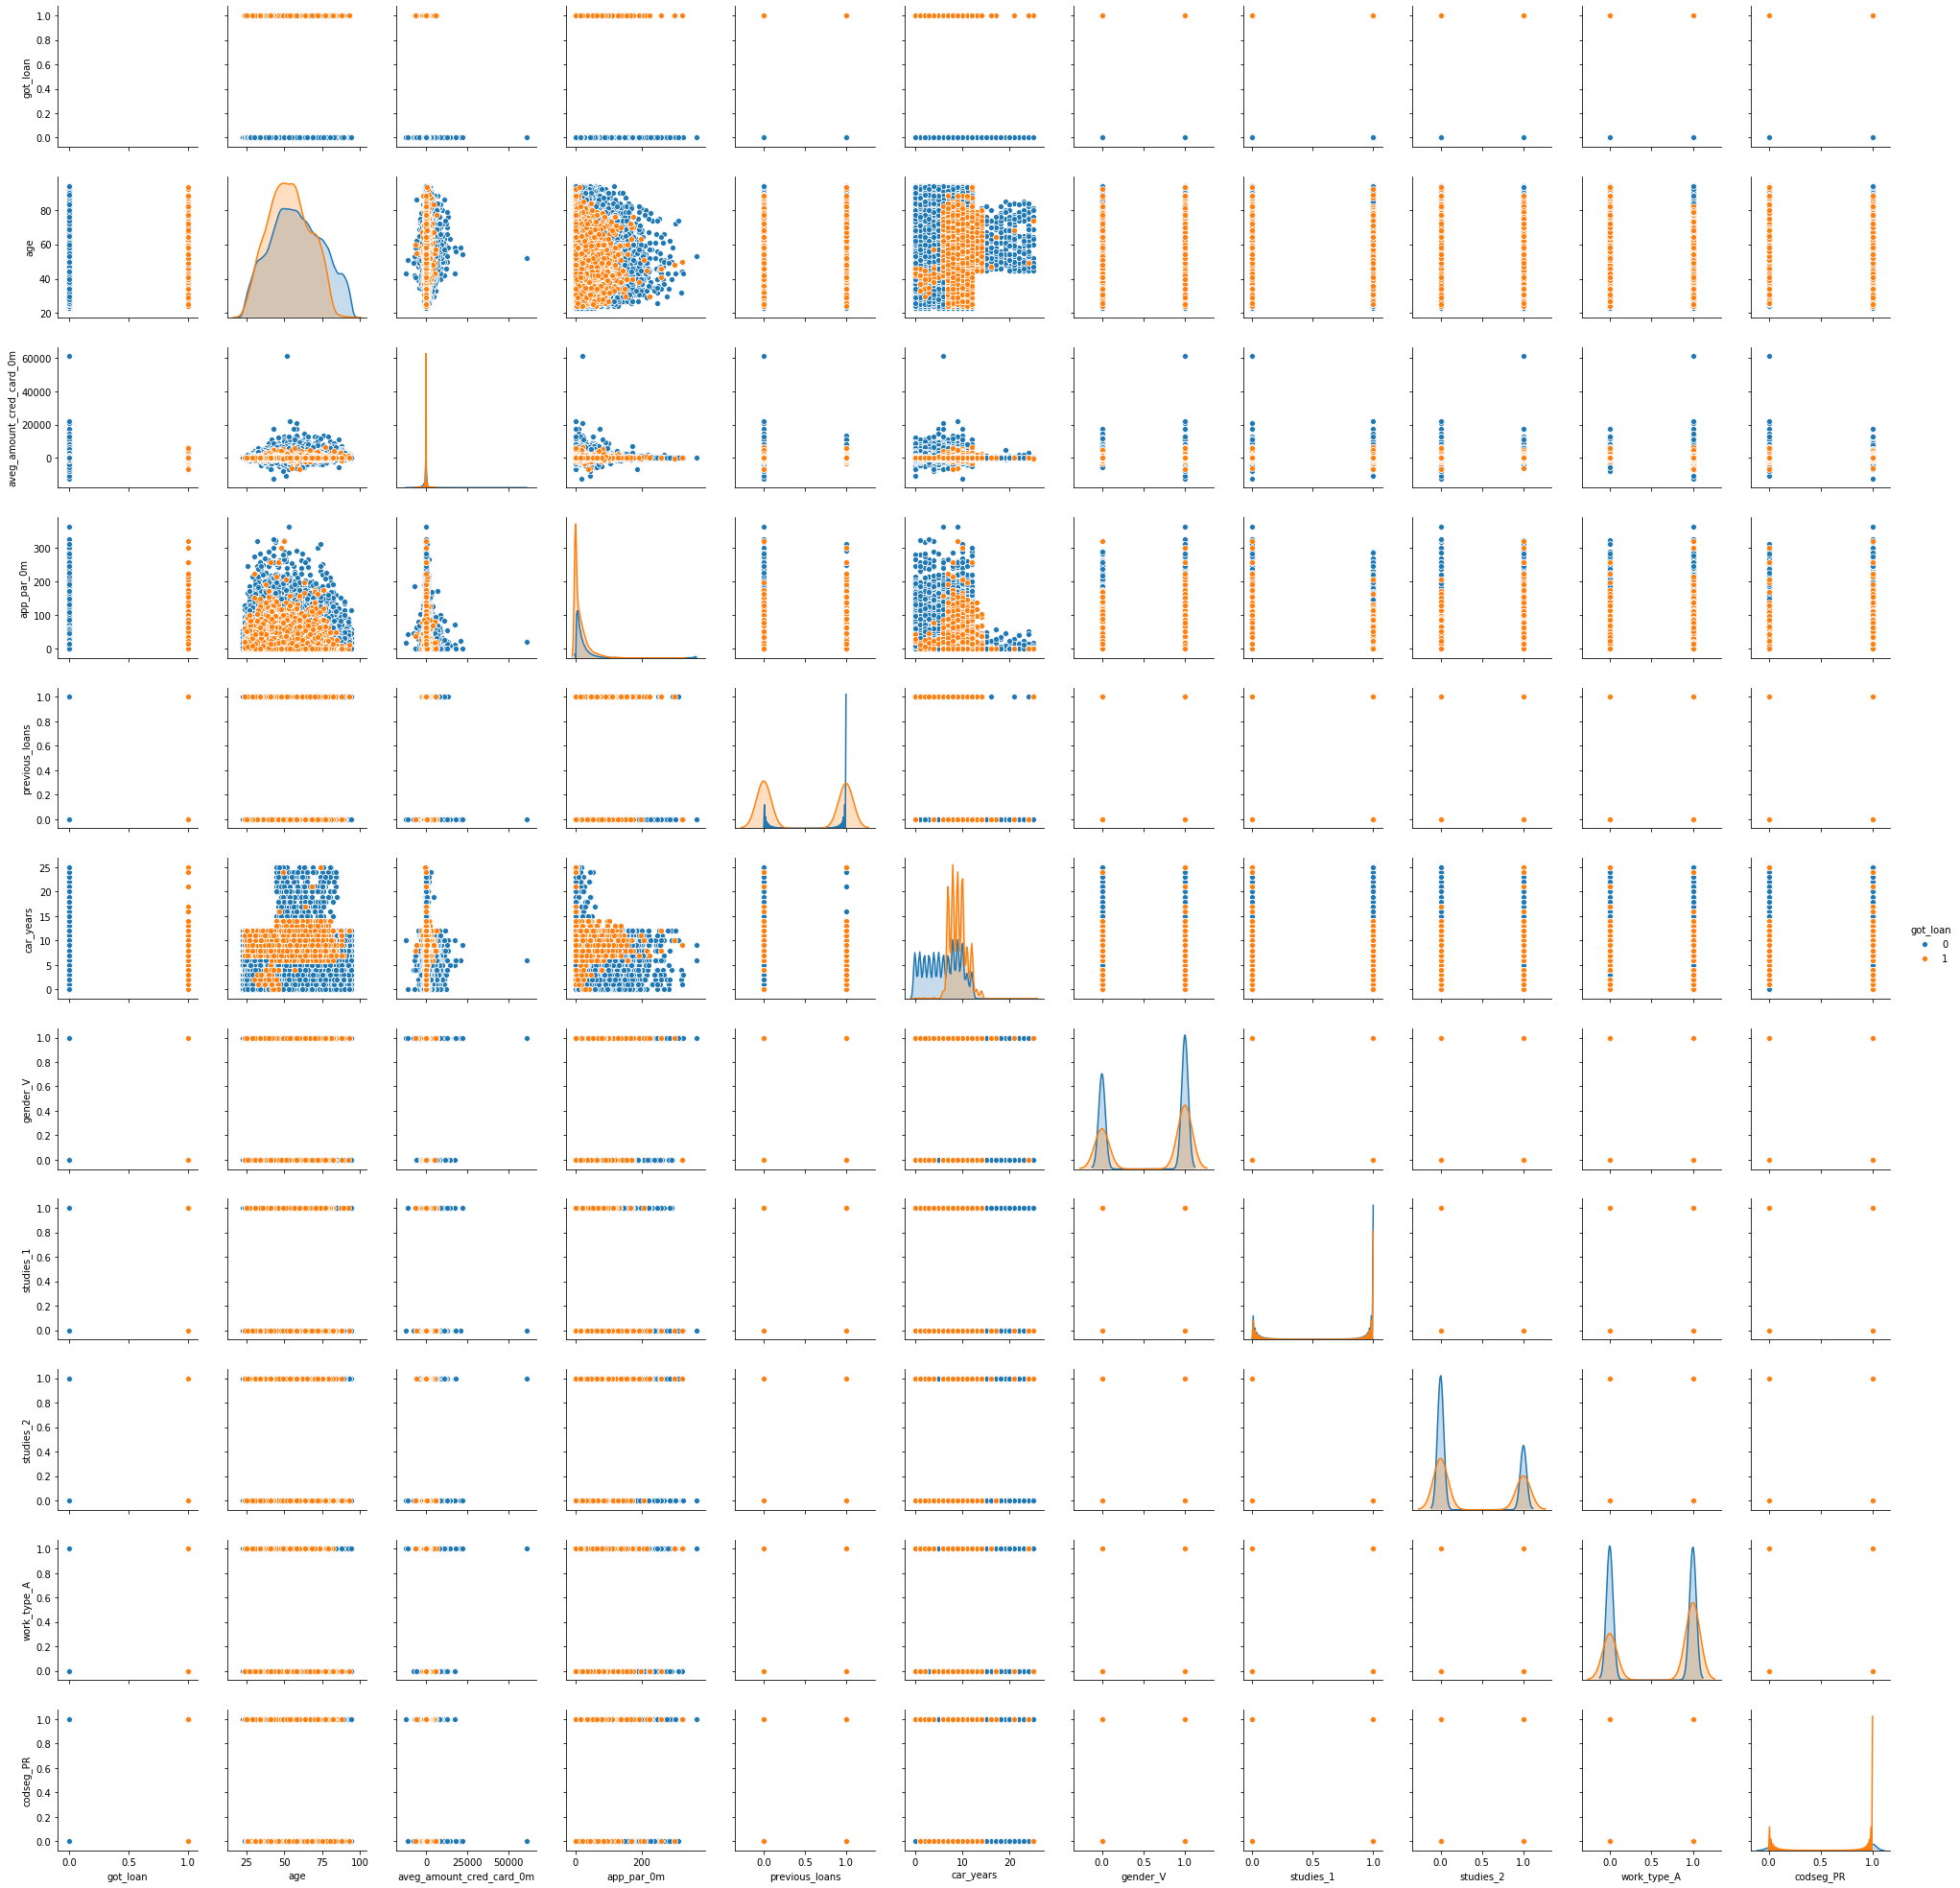

In [137]:
# Basic pairplot correlogram 

''' plot some of the features selected for the model'''

mini_total_clients_mod = total_clients_mod[['got_loan',
                                           'age',
                                           'aveg_amount_cred_card_0m',
                                           'app_par_0m', 
                                           'previous_loans',
                                           'car_years',
                                           'gender_V',
                                           'studies_1', 'studies_2', 
                                           'work_type_A', 
                                           'codseg_PR']]
sns.pairplot(mini_total_clients_mod, hue = 'got_loan') 



In [138]:
# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=[features_to_model], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)
# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['previous_loans'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['months_since_loan'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['car_years'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# red_square = dict(markerfacecolor='r', marker='s')
# boxplot = total_clients_mod.boxplot(column=['acc_0m'], by='got_loan',
#                      flierprops= red_square, whis=0.45)
# type(boxplot)

# plt.show()

### Outliers

In [272]:
# https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32
# IQR does not work for outliers in this dataset due to the high data dispersion
''' Use features not factorized previously'''

col = ['age', 
       'population_cmun',
       'num_cred_cards_0m', 'aveg_amount_cred_card_0m', 'amount_cards_0m', 'amount_total_cards_0m', 
       'num_stocks_0m',
       'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m', 'app_par_0m', 'web_par_0m', 
       'amount_rec_0m', 'num_rec_0m', 
       'aved_amount_postpone_payment_3t4t_delta', 
       'months_since_loan', 
       'car_years', 
       'House_years', 
       'cprovper']
'''Define Quantile 1 and 3
3 times the IQR above or bellow the Q1 or Q3 accodingly is considered a definitive outlier
Create a dataset with the instances with outliers in any feature'''

Q1 = total_clients_mod[col].quantile(0.25)
Q3 = total_clients_mod[col].quantile(0.75)
IQR = Q3 - Q1
total_clients_mod_out = total_clients_mod[col][~((total_clients_mod[col] < (Q1 - 3 * IQR)) |
                                            (total_clients_mod[col] > (Q3 + 3 * IQR))).any(axis=1)]
drop_outl = total_clients_mod_out.dropna()
drop_outl.append(drop_outl)
drop_outl
# Drop columns included in the outliers´ review  dataset
for c in col:
    n = total_clients_mod.drop(col, axis = 1)
# Concat both dataset to get all the columns back without outliers
total_clients_mod_new_IQR = pd.merge(n,drop_outl,left_index=True, right_index=True)

print('Dataset with outliers',total_clients_mod.shape)
print('Dataset without outliers',total_clients_mod_new_IQR.shape)

Dataset with outliers (395937, 61)
Dataset without outliers (163467, 61)


In [144]:
# check for outliers with Zscore

'''We find the z score for each of the data point in the dataset and if the z score 
is greater than 3 than we can classify that point as an outlier. Any point outside of
3 standard deviations would be an outlier'''

col = ['age', 
       'population_cmun',
       'num_cred_cards_0m', 'aveg_amount_cred_card_0m', 'amount_cards_0m', 'amount_total_cards_0m', 
       'num_stocks_0m',
       'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m', 'app_par_0m', 'web_par_0m', 
       'amount_rec_0m', 'num_rec_0m', 
       'aved_amount_postpone_payment_3t4t_delta', 
       'months_since_loan', 
       'car_years', 
       'House_years', 
       'cprovper']

final = total_clients_mod[col][~(np.abs(total_clients_mod[col]-total_clients_mod[col].mean()) > (3*total_clients_mod[col].std()))]
drop_outliers = final.dropna()
drop_outliers.append(drop_outliers)
# Drop columns included in the outliers´ review  dataset
for c in col:
    n = total_clients_mod.drop(col, axis = 1)
#concat both dataset to get all the columns back without outliers
total_clients_mod_new_Zscore = pd.merge(n,drop_outliers,left_index=True, right_index=True)

print('Dataset with outliers',total_clients_mod.shape)
print('Dataset without outliers',total_clients_mod_new_Zscore.shape)

Dataset with outliers (395937, 61)
Dataset without outliers (367434, 61)


###  b. Normalized

In [149]:
# normalize data. 

total_clients_mod_ =total_clients_mod[features_to_model].copy()

'''apply list comprenhension only to the features we will be using for the models.This normalized is column-wise
and min-max normalization. Could also be used mean & std normalization method with Pandas'''

total_clients_mod_norm = total_clients_mod_[features_to_model].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

total_clients_mod_

got_loan  age  population_cmun  num_cred_cards_0m  \
0              0   34         689434.0                  0   
1              0   45         114238.0                  2   
2              0   67        1620809.0                  0   
3              0   40          15225.0                  2   
4              0   47          23222.0                  0   
...          ...  ...              ...                ...   
399995         0   53          23178.0                  0   
399996         0   89         787808.0                  0   
399997         0   41        3182981.0                  2   
399998         0   65          14756.0                  0   
399999         0   40              0.0                  2   

        aveg_amount_cred_card_0m  amount_cards_0m  amount_total_cards_0m  \
0                           0.00         71.85620               99.07560   
1                           0.00          0.00000                0.00000   
2                           0.00        309.63923              426.93174   
3                         194.15        100.24607              138.21966   
4                           0.00         38.21530               52.69140   
...                          ...              ...                    ...   
399995                      0.00          0.00000                0.00000   
399996                      0.00         14.29500               19.71000   
399997                    225.25       3792.08230             5228.53740   
399998                      0.00          0.00000                0.00000   
399999                     18.20       1338.21213             1845.13194   

        num_stocks_0m  acc_0m  mobile_0m     pc_0m  tablet_0m  app_par_0m  \
0                   0       1   1.000000  0.000000        0.0           1   
1                   0      19   1.000000  0.000000        0.0          19   
2                   0      15   1.000000  0.000000        0.0          14   
3                   1      13   1.000000  0.000000        0.0          11   
4                   0      15   1.000000  0.000000        0.0          15   
...               ...     ...        ...       ...        ...         ...   
399995              1      10   1.000000  0.000000        0.0          10   
399996              0       0   0.000000  0.000000        0.0           0   
399997              0      10   1.000000  0.000000        0.0           9   
399998              4       0   0.000000  0.000000        0.0           0   
399999              2      18   0.777778  0.222222        0.0          14   

        web_par_0m  amount_rec_0m  num_rec_0m  \
0                0       21.95279           1   
1                0      309.81457           3   
2                1     1075.44978           8   
3                2        0.00000           0   
4                0     2730.82250           4   
...            ...            ...         ...   
399995           0       49.31412           1   
399996           0      131.89648           5   
399997           1      489.71797           4   
399998           0     2876.40373          15   
399999           4      675.46292           7   

        aved_amount_postpone_payment_3t4t_delta  months_since_loan  car_years  \
0                                          0.00                  0         12   
1                                          0.00                  0          2   
2                                        -98.33                  0          3   
3                                          0.00                  0         12   
4                                          0.00                  0          5   
...                                         ...                ...        ...   
399995                                    83.49                  0          0   
399996                                     0.00                  0          2   
399997                                     0.00                  0          2   
399998                                

In [150]:
# final features for the model

# non normalized

# total_clients_mod_f = total_clients_mod_new_Zscore.copy()
total_clients_mod_f = total_clients_mod_.copy()

# normalized
total_clients_mod_fn = total_clients_mod_norm.copy()

print('non normalized:', total_clients_mod_f.shape)
print('normalized:', total_clients_mod_fn.shape)
print('non normalized 1:', total_clients_mod_f[total_clients_mod_f.got_loan == 1].shape)
print('non normalized 0:', total_clients_mod_f[total_clients_mod_f.got_loan == 0].shape)
print('normalized 1:', total_clients_mod_fn[total_clients_mod_fn.got_loan == 1].shape)
print('normalized 0:', total_clients_mod_fn[total_clients_mod_fn.got_loan == 0].shape)


non normalized: (395937, 33)
normalized: (395937, 33)
non normalized 1: (7005, 33)
non normalized 0: (388932, 33)
normalized 1: (7005, 33)
normalized 0: (388932, 33)


### c. Split Train Test Validation


In [273]:
# datasets to model 90%
# non normalized
total_clients_mod_f90 =total_clients_mod_f.sample(frac=0.9, replace=False, random_state=42)
# normalized
total_clients_mod_f90n =total_clients_mod_fn.sample(frac=0.9, replace=False, random_state=42)


# validation dataset 10%

# non normalized
total_clients_mod_f10 = total_clients_mod_f[~total_clients_mod_f.index.isin(total_clients_mod_f90.index)]

# normalized
total_clients_mod_f10n =total_clients_mod_fn[~total_clients_mod_fn.index.isin(total_clients_mod_f90n.index)]

print('90% of clients')
print('non normalized 1:', total_clients_mod_f90[total_clients_mod_f90.got_loan == 1].shape)
print('non normalized 0:', total_clients_mod_f90[total_clients_mod_f90.got_loan == 0].shape)
print('normalized 1:', total_clients_mod_f90n[total_clients_mod_f90n.got_loan == 1].shape)
print('normalized 0:', total_clients_mod_f90n[total_clients_mod_f90n.got_loan == 0].shape)
print('10% of clients')
print('non normalized val 1', total_clients_mod_f10[total_clients_mod_f10.got_loan == 1].shape)
print('non normalized val 0:', total_clients_mod_f10[total_clients_mod_f10.got_loan == 0].shape)
print('normalized val 1:', total_clients_mod_f10n[total_clients_mod_f10n.got_loan == 1].shape)
print('normalized val 0:', total_clients_mod_f10n[total_clients_mod_f10n.got_loan == 0].shape)

90% of clients
non normalized 1: (6292, 33)
non normalized 0: (350051, 33)
normalized 1: (6292, 33)
normalized 0: (350051, 33)
10% of clients
non normalized val 1 (713, 33)
non normalized val 0: (38881, 33)
normalized val 1: (713, 33)
normalized val 0: (38881, 33)


### non normalized

In [274]:
### non normalized

# Define the features and the target
X = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns != 'got_loan']
y = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns == 'got_loan']

# Split the dataset into train and test sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
print('X:' , X.shape)
print('X_train:' , X_train.shape)
print('X_test:',  X_test.shape)
print('y_train:' , y_train.shape)
print('y_test:' ,y_test.shape)
print('nº of 1 ',y_test[y_test.got_loan ==1].shape)
print('nº of 0 ', y_test[y_test.got_loan ==0].shape)

X: (356343, 32)
X_train: (267257, 32)
X_test: (89086, 32)
y_train: (267257, 1)
y_test: (89086, 1)
nº of 1  (1540, 1)
nº of 0  (87546, 1)


### normalized

In [275]:
# normalized
# Define the features and the target
X_n = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns != 'got_loan']
y_n = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns == 'got_loan']

# Split the dataset into train and test sklearn
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=.25, random_state=42)

print('X_train_n:' , X_train_n.shape)
print('X_test_n:',  X_test_n.shape)
print('y_train_n:' , y_train_n.shape)
print('y_test_n:' ,y_test_n.shape)
print(y_test_n.got_loan.value_counts())

X_train_n: (267257, 32)
X_test_n: (89086, 32)
y_train_n: (267257, 1)
y_test_n: (89086, 1)
0.0    87546
1.0     1540
Name: got_loan, dtype: int64


## Split Train Test Validation balanced

### non normalized

In [276]:
Xb = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns != 'got_loan']
yb = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns == 'got_loan']
print(Xb.count())

age                         356343
population_cmun             356343
num_cred_cards_0m           356343
aveg_amount_cred_card_0m    356343
amount_cards_0m             356343
                             ...  
work_type_O                 356343
work_type_P                 356343
codseg_PB                   356343
codseg_PI                   356343
mortgage_N                  356343
Length: 32, dtype: int64


In [277]:
# # non normalized balanced
# #Synthetic Minority Oversampling Technique(SMOTENC )
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# # define oversampling strategy
# over = RandomOverSampler(sampling_strategy='minority',ratio = 0.2, random_state= 42)
# # fit and apply the transform
# Xb_resampled, yb_resampled = over.fit_resample(Xb, yb)
# # define undersampling strategy
# under = RandomUnderSampler(sampling_strategy='majority',random_state= 42)
# # fit and apply the transform
# Xb_resampled, yb_resampled = under.fit_resample(Xb_resampled, yb_resampled)

# print('Dataset after resampling:') 
# print('Xb_resampled shape', Xb_resampled.shape)
# print('yb_resampled shape', yb_resampled.shape)
# yvals, counts = np.unique(yb_resampled, return_counts=True)
# print('number of 1 and 0:',counts)


In [278]:
# # non normalized balanced
# # undersampling   Synthetic Minority Oversampling Technique(SMOTENC )
# '''Undersampling to balance dataset 1/4'''
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.datasets import make_classification
# from collections import Counter

# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy=0.35)
# Xb_resampled, yb_resampled = undersample.fit_resample(Xb, yb)
# # Xb_resampled = pd.DataFrame(Xb_resampled,columns=[Xb.columns])      
# # yb_resampled = pd.DataFrame(yb_resampled,columns=[yb.columns])
# # summarize class distribution
# # print(Counter(yb_resampled))
# # print('Dataset after resampling:') 
# # print(sorted(Counter(yb_resampled).items())) 
# print('Dataset after resampling:') 
# # print(sorted(Counter(yb_resampled).items())) 
# print('Xb_resampled shape', Xb_resampled.shape)
# print('yb_resampled shape', yb_resampled.shape)
# yvals, counts = np.unique(yb_resampled, return_counts=True)
# print('number of 1 and 0:',counts)

In [279]:
# oversampling   Synthetic Minority Oversampling Technique(SMOTENC )

smote_nc = SMOTENC(categorical_features=[0],sampling_strategy=0.4, random_state=42) 
Xb_resampled, yb_resampled = smote_nc.fit_resample(Xb, yb) 


print('Dataset after resampling:') 
print('Xb_resampled shape', Xb_resampled.shape)
print('yb_resampled shape', yb_resampled.shape)
yvals, counts = np.unique(yb_resampled, return_counts=True)
print('number of 0 and 1:',counts)

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dataset after resampling:
Xb_resampled shape (490071, 32)
yb_resampled shape (490071,)
number of 0 and 1: [350051 140020]


In [280]:
# Split the dataset into train and test sklearn- dataset balanced
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb_resampled, yb_resampled, test_size=.25, random_state=42)

print('X_train_b:' , X_train_b.shape)
print('X_test_b:',  X_test_b.shape)
print('y_train_b:' , y_train_b.shape)
print('y_test_b:' ,y_test_b.shape)
# number of ceros and ones rebalanced

#ceros
yb_resampled_count0 = filter(lambda x: x == 0, yb_resampled)
i =0
for x in yb_resampled_count0:
    i +=1
print ('number of ceros yb_resampled:', i)
#ones 
yb_resampled_count1 = filter(lambda x: x == 1, yb_resampled)
i =0
for x in yb_resampled_count1:
    i +=1
print ('number of ones yb_resampled:', i)


X_train_b: (367553, 32)
X_test_b: (122518, 32)
y_train_b: (367553,)
y_test_b: (122518,)
number of ceros yb_resampled: 350051
number of ones yb_resampled: 140020


### normalized

In [281]:
# normalized
# Define the features and the target
Xnb = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns != 'got_loan']
ynb = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns == 'got_loan']

print(Xnb.count())

age                         356343
population_cmun             356343
num_cred_cards_0m           356343
aveg_amount_cred_card_0m    356343
amount_cards_0m             356343
                             ...  
work_type_O                 356343
work_type_P                 356343
codseg_PB                   356343
codseg_PI                   356343
mortgage_N                  356343
Length: 32, dtype: int64


In [282]:
# # normalized balanced
# # under-over sampling   
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# # define oversampling strategy
# over = RandomOverSampler(sampling_strategy='minority',ratio = 0.2,random_state= 42)
# # fit and apply the transform
# Xnb_resampled, ynb_resampled = over.fit_resample(Xnb, ynb)
# # define undersampling strategy
# under = RandomUnderSampler(sampling_strategy='majority',random_state= 42)
# # fit and apply the transform
# Xnb_resampled, ynb_resampled = under.fit_resample(Xnb_resampled, ynb_resampled)

# print('Dataset after resampling:') 
# print('Xb_resampled shape', Xnb_resampled.shape)
# print('yb_resampled shape', ynb_resampled.shape)
# yvals, counts = np.unique(ynb_resampled, return_counts=True)
# print('number of 1 and 0:',counts)


In [283]:
# # normalized balanced
# # undersampling   Synthetic Minority Oversampling Technique(SMOTENC )
# '''Undersampling to balance dataset 1/4'''
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.datasets import make_classification
# from collections import Counter

# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy=0.35)
# Xnb_resampled, ynb_resampled = undersample.fit_resample(Xnb, ynb)
# # Xb_resampled = pd.DataFrame(Xb_resampled,columns=[Xb.columns])      
# # yb_resampled = pd.DataFrame(yb_resampled,columns=[yb.columns])
# # summarize class distribution
# # print(Counter(ynb_resampled))
# # print('Dataset after resampling:') 
# # print(sorted(Counter(ynb_resampled).items())) 
# print('Dataset after resampling:') 
# # print(sorted(Counter(yb_resampled).items())) 
# print('Xb_resampled shape', Xnb_resampled.shape)
# print('yb_resampled shape', ynb_resampled.shape)
# yvals, counts = np.unique(ynb_resampled, return_counts=True)
# print('number of 1 and 0:',counts)

In [284]:
#### oversampling   Synthetic Minority Oversampling Technique(SMOTENC )

smote_nc = SMOTENC(categorical_features=[0],sampling_strategy=0.4, random_state=42) 
Xnb_resampled, ynb_resampled = smote_nc.fit_resample(Xnb, ynb) 

print('Dataset after resampling:') 
# print(sorted(Counter(yb_resampled).items())) 
print('Xnb_resampled shape', Xnb_resampled.shape)
print('ynb_resampled shape', ynb_resampled.shape)
yvals, counts = np.unique(ynb_resampled, return_counts=True)
print('number of 0 and 1:',counts)

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dataset after resampling:
Xnb_resampled shape (490071, 32)
ynb_resampled shape (490071,)
number of 0 and 1: [350051 140020]


In [285]:
# normalized balanced
# Split the dataset into train and test sklearn
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(Xnb_resampled, ynb_resampled, test_size=.25, random_state=42)

print('X_train_nb:' , X_train_nb.shape)
print('X_test_nb:',  X_test_nb.shape)
print('y_train_nb:' , y_train_nb.shape)
print('y_test_nb:' ,y_test_nb.shape)
# number of ceros and ones rebalanced

#ceros
ynb_resampled_count0 = filter(lambda x: x == 0, ynb_resampled)
i =0
for x in ynb_resampled_count0:
    i +=1
print ('number of ceros ynb_resampled:', i)
#ones 
ynb_resampled_count1 = filter(lambda x: x == 1, ynb_resampled)
i =0
for x in ynb_resampled_count1:
    i +=1
print ('number of ones ynb_resampled:', i)

X_train_nb: (367553, 32)
X_test_nb: (122518, 32)
y_train_nb: (367553,)
y_test_nb: (122518,)
number of ceros ynb_resampled: 350051
number of ones ynb_resampled: 140020


## validation dataset

In [286]:
### non normalized

X_val = total_clients_mod_f10.loc[:, total_clients_mod_f10.columns != 'got_loan']
y_val = total_clients_mod_f10.loc[:, total_clients_mod_f10.columns == 'got_loan']

y_val['got_loan'].value_counts()

0    38881
1      713
Name: got_loan, dtype: int64

In [287]:
# normalized

X_val_n = total_clients_mod_f10n.loc[:, total_clients_mod_f10n.columns != 'got_loan']
y_val_n = total_clients_mod_f10n.loc[:, total_clients_mod_f10n.columns == 'got_loan']

y_val_n['got_loan'].value_counts()

0.0    38881
1.0      713
Name: got_loan, dtype: int64

### Visualization unbalanced and balanced dataset

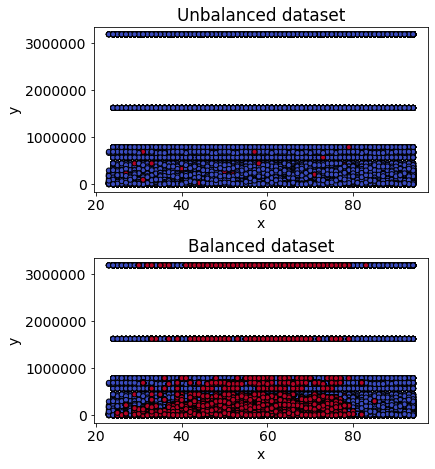

In [363]:
# visualization unbalanced

''' convert to an array with numpy'''
X_arr = X.copy()
X_arr = X_arr.to_numpy(dtype='float')
y_arr = y.copy()
y_arr = y_arr.to_numpy(dtype='uint8')
y_arr_list = []
for sublist in y_arr:
    for item in sublist:
        y_arr_list.append(item)

'''plot both dataset'''
# plt.figure(figsize=(30,15))

plt.subplot(2, 1, 1)

plt.title('Unbalanced dataset')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-10000,20000)
plt.scatter(X_arr[:, 0], X_arr[:, 1], marker='o', c=y_arr_list,
           s=25, edgecolor='k', cmap=plt.cm.coolwarm)

# visualization balanced
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace = 0.4,top = 1.5)
plt.title('Balanced dataset')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-10000,20000)
plt.scatter(Xb_resampled[:, 0],Xb_resampled[:, 1],  marker='o', c=yb_resampled,
           s=25, edgecolor='k', cmap=plt.cm.coolwarm)
plt.show()

### d.Models´ approach

### d.1 Logistic Regression

#### d.1.1 non normalized dataset

In [289]:
# non normalized 

model_logreg = LogisticRegression()
model_logreg.fit(X_train,y_train)

model_logreg_predict = model_logreg.predict(X_test)

#Evaluating Performance
model_logreg_cv_score = cross_val_score(model_logreg, X, y, cv=5)

print(model_logreg_cv_score)

# print confusion matrix models


'''logistic regresion'''
print("logistic regresion")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, model_logreg_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, model_logreg_predict))
print('\n')
print("=== All AUC Scores ===")
print(model_logreg_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - logistic regresion: ", model_logreg_cv_score.mean())
print('\n')


C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exampl

[0.98146459 0.98171716 0.98181538 0.98136611 0.98024359]
logistic regresion


=== Confusion Matrix ===
[[87456    90]
 [ 1538     2]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     87546
           1       0.02      0.00      0.00      1540

    accuracy                           0.98     89086
   macro avg       0.50      0.50      0.50     89086
weighted avg       0.97      0.98      0.97     89086



=== All AUC Scores ===
[0.98146459 0.98171716 0.98181538 0.98136611 0.98024359]


=== Mean AUC Score ===
Mean AUC Score - logistic regresion:  0.9813213644353047




#### d.1.2 non normalized dataset-balanced

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logistic regresion


=== Confusion Matrix ===
[[85479  2075]
 [31339  3625]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.73      0.98      0.84     87554
           1       0.64      0.10      0.18     34964

    accuracy                           0.73    122518
   macro avg       0.68      0.54      0.51    122518
weighted avg       0.70      0.73      0.65    122518

=== accuracy_score ===
0.7272727272727273
=== roc_curve ===
0.6500980425548453


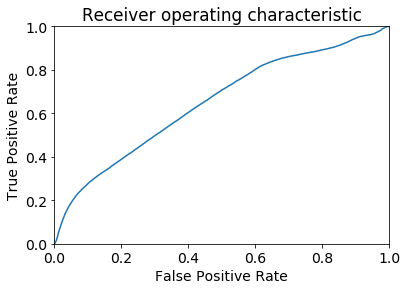

In [290]:


model_logreg_b = LogisticRegression()
model_logreg_b.fit(X_train_b,y_train_b)
# Predict values using the random forest classifier model
y_pred_b = model_logreg_b.predict(X_test_b)

print("logistic regresion")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b,y_pred_b))
print("=== classification_report ===")
print(classification_report(y_test_b,y_pred_b))
print("=== accuracy_score ===")
print(accuracy_score(y_test_b,y_pred_b))

# roc_auc_score
y_pred_b2 = model_logreg_b.predict_proba(X_test_b)
y_pred_b2 = [p[1] for p in y_pred_b2]
# print(roc_auc_score(y_test_b,y_pred_b2))

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

logistic regresion non normalized balanced validation


=== Confusion Matrix ===
[[37980   901]
 [  588   125]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     38881
           1       0.12      0.18      0.14       713

    accuracy                           0.96     39594
   macro avg       0.55      0.58      0.56     39594
weighted avg       0.97      0.96      0.97     39594

=== accuracy_score ===
0.9623932919129161
=== roc_curve ===
0.6645546253207678


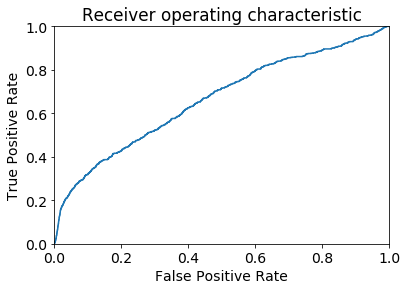

In [291]:

#validation
y_pred_b_val = model_logreg_b.predict(X_val)

print("logistic regresion non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val))

# roc_auc_score
y_pred_b_val2 = model_logreg_b.predict_proba(X_val)
y_pred_b_val2 = [p[1] for p in y_pred_b_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_b_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_b_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


#### d.1.3 normalized dataset

In [292]:


''' avoid warnings'''
# with warnings.catch_warnings():
#     ignore all caught warnings
#     warnings.filterwarnings("ignore")

# create model 

model_logreg_n = LogisticRegression()
model_logreg_n.fit(X_train_n,y_train_n)

model_logreg_predict_n = model_logreg_n.predict(X_test_n)

#Evaluating Performance
model_logreg_cv_score_n = cross_val_score(model_logreg_n, X_n, y_n, cv=5)

print(model_logreg_cv_score_n)

# print confusion matrix 


'''logistic regresion'''
print("logistic regresion")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_n, model_logreg_predict_n))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_n, model_logreg_predict_n))
print('\n')
print("=== All AUC Scores ===")
print(model_logreg_cv_score_n)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - logistic regresion: ", model_logreg_cv_score_n.mean())
print('\n')


C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exampl

[0.9842007  0.98441117 0.9846918  0.9843408  0.98474771]
logistic regresion


=== Confusion Matrix ===
[[87399   147]
 [ 1198   342]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     87546
         1.0       0.70      0.22      0.34      1540

    accuracy                           0.98     89086
   macro avg       0.84      0.61      0.66     89086
weighted avg       0.98      0.98      0.98     89086



=== All AUC Scores ===
[0.9842007  0.98441117 0.9846918  0.9843408  0.98474771]


=== Mean AUC Score ===
Mean AUC Score - logistic regresion:  0.9844784382789458




##### d.1.3.1 normalized dataset-balanced

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[82132  5422]
 [14608 20356]]
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     87554
         1.0       0.79      0.58      0.67     34964

    accuracy                           0.84    122518
   macro avg       0.82      0.76      0.78    122518
weighted avg       0.83      0.84      0.83    122518

0.8365138183777078
=== roc_curve ===
0.8994398189985131


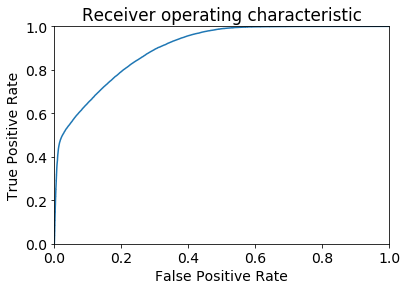

In [293]:

model_logreg_nb = LogisticRegression()

model_logreg_nb.fit(X_train_nb,y_train_nb)
# Predict values using the random forest classifier model
y_pred_logreg_nb = model_logreg_nb.predict(X_test_nb)

print(confusion_matrix(y_test_nb,y_pred_logreg_nb))
print(classification_report(y_test_nb,y_pred_logreg_nb))
print(accuracy_score(y_test_nb,y_pred_logreg_nb))

# roc_auc_score
y_pred_logreg_nb2 = model_logreg_nb.predict_proba(X_test_nb)
y_pred_logreg_nb2 = [p[1] for p in y_pred_logreg_nb2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_logreg_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_logreg_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

logistic regresion normalized balanced validation


=== Confusion Matrix ===
[[36445  2436]
 [  323   390]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     38881
         1.0       0.14      0.55      0.22       713

    accuracy                           0.93     39594
   macro avg       0.56      0.74      0.59     39594
weighted avg       0.98      0.93      0.95     39594

=== accuracy_score ===
0.9303177249078143
=== roc_curve ===
0.8824540431617992


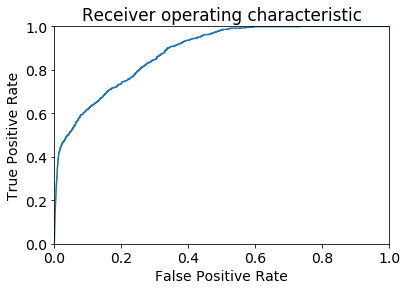

In [294]:
#validation
y_pred_b_logreg_val_n = model_logreg_nb.predict(X_val_n)

print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_n,y_pred_b_logreg_val_n))
print("=== classification_report ===")
print(classification_report(y_val_n,y_pred_b_logreg_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val_n,y_pred_b_logreg_val_n))

# roc_auc_score validation dataset
y_pred_b_logreg_val_n2 = model_logreg_nb.predict_proba(X_val_n)
y_pred_b_logreg_val_n2 = [p[1] for p in y_pred_b_logreg_val_n2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_n,y_pred_b_logreg_val_n2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_n,y_pred_b_logreg_val_n2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [295]:
# # feature importance of the random forest model
# import sklearn.linear_model as lm
# logreg = lm.LogisticRegression()
# logreg .fit(X_train_nb,y_train_nb)
# feature_importance = pd.DataFrame()
# feature_importance['variable'] = Xnb.columns # no lo hago con resample ver si es correcto
# feature_importance['importance'] = logreg.feature_importances_

# # feature_importance values in descending order
# feature_importance.sort_values(by='importance', ascending=False).head(20)

### d.2 Decision Tree Classifier

### d.2.1 non normalized dataset

In [296]:
# To find the best combination of hyper-parameters using Randomized Search 

# el que el max depth sea muy elevado no significa que va a llegar a eso. Esa cifra será el máximo.

param_dist = {'max_depth': np.arange(2,16,2),
              'min_samples_split': np.arange(2,16,2)}

n_iter_search = 20

# creo la instancia
clfrs = RandomizedSearchCV(tree.DecisionTreeClassifier(), 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
# ahora lo entreno
clfrs.fit(X, y)


clfrs.best_params_, clfrs.best_score_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.7min finished


({'min_samples_split': 8, 'max_depth': 6}, -0.013186732511724902)

In [364]:
# Training a Decision Tree Model 

dt_clients_file_num = DecisionTreeClassifier(min_samples_split=8,max_depth = 6, random_state=42)

# fitting the decision tree model on the training set
dt_clients_file_num.fit(X_train, y_train)

# Prediction & Evaluation 

y_predict_dt = dt_clients_file_num.predict(X_test)


print(confusion_matrix(y_test,y_predict_dt))
print(classification_report(y_test,y_predict_dt))
print(accuracy_score(y_test,y_predict_dt))



[[87300   246]
 [  936   604]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     87546
           1       0.71      0.39      0.51      1540

    accuracy                           0.99     89086
   macro avg       0.85      0.69      0.75     89086
weighted avg       0.98      0.99      0.98     89086

0.9867319219630469


In [365]:
# Training a Decision Tree Model 

dt_clients_file_num = DecisionTreeClassifier(min_samples_split=8,max_depth = 6, random_state=42,
                                             class_weight="balanced")

# fitting the decision tree model on the training set
dt_clients_file_num.fit(X_train, y_train)

# Prediction & Evaluation 

y_predict_dt = dt_clients_file_num.predict(X_test)


print(confusion_matrix(y_test,y_predict_dt))
print(classification_report(y_test,y_predict_dt))
print(accuracy_score(y_test,y_predict_dt))



[[71699 15847]
 [   76  1464]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87546
           1       0.08      0.95      0.16      1540

    accuracy                           0.82     89086
   macro avg       0.54      0.88      0.53     89086
weighted avg       0.98      0.82      0.89     89086

0.8212626001840918


### d.2.2 non normalized dataset-balanced

[[82159  5395]
 [ 2166 32798]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     87554
           1       0.86      0.94      0.90     34964

    accuracy                           0.94    122518
   macro avg       0.92      0.94      0.93    122518
weighted avg       0.94      0.94      0.94    122518

0.9382866191090289
=== roc_curve ===
0.9864964601759805


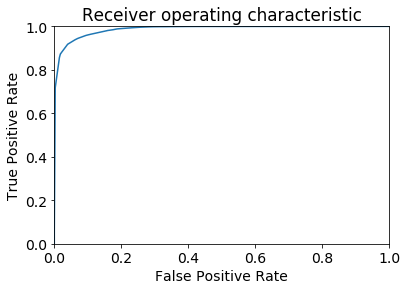

In [299]:
dt_clients_file_num_b = DecisionTreeClassifier(min_samples_split=14,max_depth = 8, random_state=42,
                                               class_weight="balanced")
dt_clients_file_num_b.fit(X_train_b,y_train_b)
# Predict values using the random forest classifier model
y_pred_dt_b = dt_clients_file_num_b.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_dt_b))
print(classification_report(y_test_b,y_pred_dt_b))
print(accuracy_score(y_test_b,y_pred_dt_b))

# roc_auc_score 
y_pred_dt_b2 = dt_clients_file_num_b.predict_proba(X_test_b)
y_pred_dt_b2 = [p[1] for p in y_pred_dt_b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_dt_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_dt_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


[[82159  5395]
 [ 2166 32798]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     87554
           1       0.86      0.94      0.90     34964

    accuracy                           0.94    122518
   macro avg       0.92      0.94      0.93    122518
weighted avg       0.94      0.94      0.94    122518

0.9382866191090289
=== roc_curve ===
0.9864964601759805


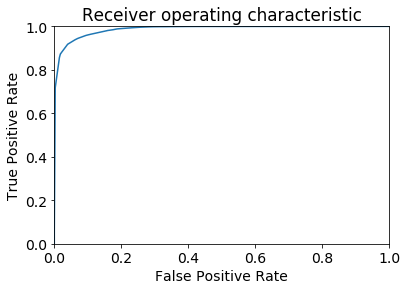

In [300]:
dt_clients_file_num_b = DecisionTreeClassifier(min_samples_split=14,max_depth = 8, random_state=10,
                                              class_weight="balanced")

dt_clients_file_num_b.fit(X_train_b,y_train_b)
# Predict values using the random forest classifier model
y_pred_dt_b = dt_clients_file_num_b.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_dt_b))
print(classification_report(y_test_b,y_pred_dt_b))
print(accuracy_score(y_test_b,y_pred_dt_b))

# roc_auc_score 
y_pred_dt_b2 = dt_clients_file_num_b.predict_proba(X_test_b)
y_pred_dt_b2 = [p[1] for p in y_pred_dt_b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_dt_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_dt_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


decision tree classifier non normalized balanced validation


=== Confusion Matrix ===
[[36485  2396]
 [  265   448]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     38881
           1       0.16      0.63      0.25       713

    accuracy                           0.93     39594
   macro avg       0.58      0.78      0.61     39594
weighted avg       0.98      0.93      0.95     39594

=== accuracy_score ===
0.9327928474011213
=== roc_curve ===
0.9370042254654608


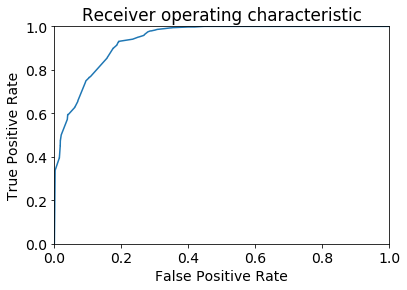

In [301]:

#validation
y_pred_dt_b_val = dt_clients_file_num_b.predict(X_val)

print("decision tree classifier non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_dt_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_dt_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_dt_b_val))

# roc auc  validation dataset

y_pred_dt_b_val2 = dt_clients_file_num_b.predict_proba(X_val)
y_pred_dt_b_val2 = [p[1] for p in y_pred_dt_b_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_dt_b_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_dt_b_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


### d.2.3 normalized dataset

In [302]:
# Training a Decision Tree Model 

dt_clients_file_num_n = DecisionTreeClassifier(min_samples_split=14,max_depth = 8, random_state=42,
                                              class_weight="balanced")

# fitting the decision tree model on the training set
dt_clients_file_num_n.fit(X_train_n, y_train_n)

# prediction &  evaliation

y_predict_dt_n = dt_clients_file_num_n.predict(X_test_n)

print(confusion_matrix(y_test_n,y_predict_dt_n))
print(classification_report(y_test_n,y_predict_dt_n))
print(accuracy_score(y_test_n,y_predict_dt_n))


[[72311 15235]
 [   86  1454]]
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.90     87546
         1.0       0.09      0.94      0.16      1540

    accuracy                           0.83     89086
   macro avg       0.54      0.89      0.53     89086
weighted avg       0.98      0.83      0.89     89086

0.8280201153941136


### d.2.4 normalized dataset-balanced

[[75803 11751]
 [ 1333 33631]]
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     87554
         1.0       0.74      0.96      0.84     34964

    accuracy                           0.89    122518
   macro avg       0.86      0.91      0.88    122518
weighted avg       0.91      0.89      0.90    122518

0.8932075286896619
0.9138303790249236
=== roc_curve ===
0.9757619786038618


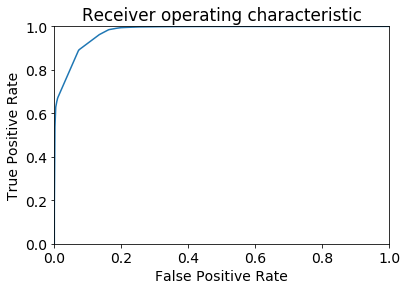

In [303]:
# Training a Decision Tree Model 

dt_clients_file_num_nb = DecisionTreeClassifier(min_samples_split=14,max_depth = 8, random_state=10,
                                               class_weight="balanced")

# fitting the decision tree model on the training set
dt_clients_file_num_nb.fit(X_train_nb,y_train_nb)
# Predict values using the random forest classifier model
y_pred_dt_nb = dt_clients_file_num_nb.predict(X_test_nb)

# Evaluation 
print(confusion_matrix(y_test_nb,y_pred_dt_nb))
print(classification_report(y_test_nb,y_pred_dt_nb))
print(accuracy_score(y_test_nb,y_pred_dt_nb))
print(roc_auc_score(y_test_nb,y_pred_dt_nb))

# roc auc  test dataset

y_pred_dt_nb2 = dt_clients_file_num_nb.predict_proba(X_test_nb)
y_pred_dt_nb2 = [p[1] for p in y_pred_dt_nb2 ]

print("=== roc_curve ===")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_dt_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_dt_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

logistic regresion normalized balanced validation


=== Confusion Matrix ===
[[33693  5188]
 [  112   601]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     38881
         1.0       0.10      0.84      0.18       713

    accuracy                           0.87     39594
   macro avg       0.55      0.85      0.56     39594
weighted avg       0.98      0.87      0.91     39594

=== accuracy_score ===
0.8661413345456382
=== roc_curve ===
0.9442490812311728


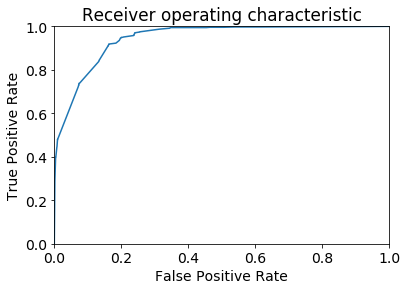

In [304]:
#validation
y_pred_b_val_nb = dt_clients_file_num_nb.predict(X_val_n)


print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_n,y_pred_b_val_nb))
print("=== classification_report ===")
print(classification_report(y_val_n,y_pred_b_val_nb))
print("=== accuracy_score ===")
print(accuracy_score(y_val_n,y_pred_b_val_nb))

# roc auc  validation dataset

y_pred_b_val_nb2 = dt_clients_file_num_nb.predict_proba(X_val_n)
y_pred_b_val_nb2 = [p[1] for p in y_pred_b_val_nb2 ]

print("=== roc_curve ===")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_n,y_pred_b_val_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_n,y_pred_b_val_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [305]:
# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = X.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = dt_clients_file_num_nb.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

variable  importance
17          car_years    0.474007
18        House_years    0.180352
16  months_since_loan    0.169335
0                 age    0.093087
6       num_stocks_0m    0.033522
..                ...         ...
24          studies_3    0.000250
12         web_par_0m    0.000217
31         mortgage_N    0.000150
30          codseg_PI    0.000145
19           cprovper    0.000111

[20 rows x 2 columns]

In [306]:
# # plot, tree branches, weights 

# plt.figure(figsize=(40,10))
# dt_clients_file_num_plot = tree.plot_tree(dt_clients_file_num_b,fontsize=12,feature_names=list(Xb_resampled.columns),filled=True,node_ids=True,proportion=True, rotate=True,precision=3)

# r = export_text(dt_clients_file_num_b , feature_names=list(Xb_resampled.columns))
# print(r)

# plt.suptitle("Decision surface of a decision tree using paired features")
# plt.legend(loc='lower right', borderpad=0, handletextpad=0)
# plt.autoscale(enable=True, axis='X')
# plt.autoscale(enable=True, axis='y')

# plt.show()



### d.3 Random forest classifier

In [307]:
from sklearn.model_selection import GridSearchCV

In [308]:
# tunning the 
# from sklearn.ensemble import RandomForestClassifier

# # from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV

# random_classifier = RandomForestClassifier()

# parameters = { 'max_features':np.arange(0,3),'n_estimators':[500],'min_samples_leaf': [10,50,100,200,500]}

# random_grid = GridSearchCV(random_classifier, parameters, cv = 5)

# random_grid.fit(X_train,y_train)
# grid_search.best_params_

C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


[[87372   174]
 [  983   557]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     87546
           1       0.76      0.36      0.49      1540

    accuracy                           0.99     89086
   macro avg       0.88      0.68      0.74     89086
weighted avg       0.98      0.99      0.98     89086

0.9870125496711043
=== roc_curve ===
0.9378676063730208


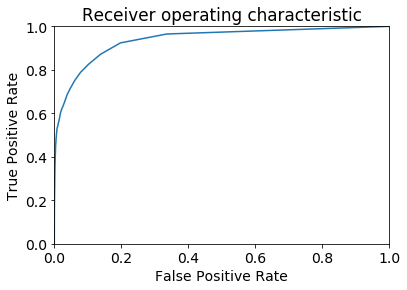

In [371]:

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train,y_train)

# Predict values using the random forest classifier model
y_pred_rf = rf_classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
print(accuracy_score(y_test,y_pred_rf))

# roc auc  
y_pred_rf_2 = rf_classifier.predict_proba(X_test)
y_pred_rf_2 = [p[1] for p in y_pred_rf_2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test,y_pred_rf_2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test,y_pred_rf_2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


#### d.3.1 RF non normalized

In [309]:

# # rfclassifier = RandomForestClassifier(n_estimators = 100,criterion = 'gini',random_state = 42,
# #                                       max_depth = None,min_samples_leaf=8)
# random_grid.fit(X_train,y_train)
# # fitting the rf model on the training set
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# # evaluate model
# scores = cross_val_score(random_grid, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# # summarize performance
# print('Mean ROC AUC: %.3f' % mean(scores))

# # Predict values using the random forest classifier model
# y_pred_rf = random_grid.predict(X_test)

# print(confusion_matrix(y_test,y_pred_rf))
# print(classification_report(y_test,y_pred_rf))
# print(accuracy_score(y_test,y_pred_rf))


### d.3.2 RF non normalized-balanced

Mean ROC AUC: 0.998
[[87296   258]
 [ 1100 33864]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     87554
           1       0.99      0.97      0.98     34964

    accuracy                           0.99    122518
   macro avg       0.99      0.98      0.99    122518
weighted avg       0.99      0.99      0.99    122518

0.9889159143962519
=== roc_curve ===
0.9979614151575803


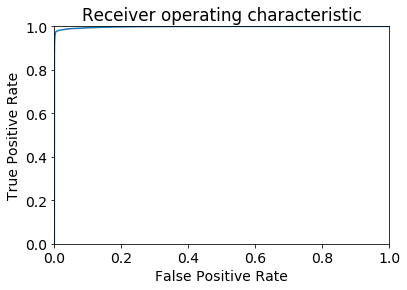

In [310]:
# balanced 
rfclassifier_b = RandomForestClassifier(n_estimators = 100,criterion = 'gini',random_state = 42, 
                                        max_depth = None,min_samples_leaf=8)
rfclassifier_b.fit(X_train_b,y_train_b)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_b = cross_val_score(rfclassifier_b, Xb_resampled, yb_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_b))

# Predict values using the random forest classifier model
y_pred_rf_b = rfclassifier_b.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_rf_b))
print(classification_report(y_test_b,y_pred_rf_b))
print(accuracy_score(y_test_b,y_pred_rf_b))

# roc auc  
y_pred_rf_b2 = rfclassifier_b.predict_proba(X_test_b)
y_pred_rf_b2 = [p[1] for p in y_pred_rf_b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_rf_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_rf_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


Random Forest classifier non normalized balanced validation


=== Confusion Matrix ===
[[38788    93]
 [  455   258]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     38881
           1       0.74      0.36      0.48       713

    accuracy                           0.99     39594
   macro avg       0.86      0.68      0.74     39594
weighted avg       0.98      0.99      0.98     39594

=== accuracy_score ===
0.9861595191190584
=== roc_curve ===
0.9474814961161206


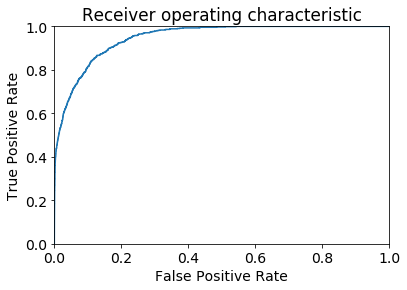

In [311]:

#validation
y_pred_rf_b_val = rfclassifier_b.predict(X_val)

print("Random Forest classifier non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_rf_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_rf_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_rf_b_val))

# roc auc  validation dataset

y_pred_rf_b_val2 = rfclassifier_b.predict_proba(X_val)
y_pred_rf_b_val2 = [p[1] for p in y_pred_rf_b_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_rf_b_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_rf_b_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


### d.3.3 RF normalized

In [312]:

rfclassifier_n = RandomForestClassifier(n_estimators = 100,criterion = 'gini',random_state = 42, 
                                        max_depth = None,min_samples_leaf=8)

rfclassifier_n.fit(X_train_n,y_train_n)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_n = cross_val_score(rfclassifier_n, X_n, y_n, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_n))

# Predict values using the random forest classifier model
y_pred_rf_n = rfclassifier_n.predict(X_test_n)

print(confusion_matrix(y_test_n,y_pred_rf_n))
print(classification_report(y_test_n,y_pred_rf_n))
print(accuracy_score(y_test_n,y_pred_rf_n))


C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Mean ROC AUC: 0.956
[[87376   170]
 [ 1010   530]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     87546
         1.0       0.76      0.34      0.47      1540

    accuracy                           0.99     89086
   macro avg       0.87      0.67      0.73     89086
weighted avg       0.98      0.99      0.98     89086

0.9867543721796915


### d.3.4 RF normalized- balanced¶

Mean ROC AUC: 0.998
[[86844   710]
 [ 1233 33731]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     87554
         1.0       0.98      0.96      0.97     34964

    accuracy                           0.98    122518
   macro avg       0.98      0.98      0.98    122518
weighted avg       0.98      0.98      0.98    122518

0.9841411057966992
=== roc_curve ===
0.6531236558297902


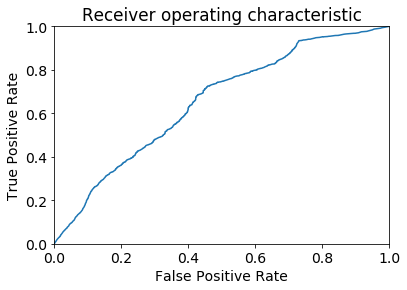

In [313]:
# balanced
rfclassifier_nb = RandomForestClassifier(n_estimators = 100,criterion = 'gini',random_state = 42, 
                                        max_depth = None,min_samples_leaf=8)
rfclassifier_nb.fit(X_train_nb,y_train_nb)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_nb = cross_val_score(rfclassifier_nb, Xnb_resampled, ynb_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_nb))

# Predict values using the random forest classifier model
y_pred_rf_nb = rfclassifier_nb.predict(X_test_nb)

print(confusion_matrix(y_test_nb,y_pred_rf_nb))
print(classification_report(y_test_nb,y_pred_rf_nb))
print(accuracy_score(y_test_nb,y_pred_rf_nb))

# roc auc  validation dataset

y_pred_rf_nb2 = rfclassifier_b.predict_proba(X_test_nb)
y_pred_rf_nb2 = [p[1] for p in y_pred_rf_nb2]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_rf_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_rf_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [314]:
# search thresholds for imbalanced classification
 
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs > threshold).astype('int')

y_pred_rf_nb = rfclassifier_nb.predict_proba(X_test_nb)[:,1]
# define thresholds
thresholds = arange(0, 0.70, 0.1)
# evaluate each threshold
scores = [f1_score(y_test_nb, to_labels(y_pred_rf_nb, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.500, F-Score=0.97200


In [315]:
# Predict values using the random forest classifier model
y_pred_rf_nb = rfclassifier_nb.predict_proba(X_test_nb)[:,1].astype(bool)
y_pred_rf_nb2=(y_pred_rf_nb,thresholds[ix])[0]
print(confusion_matrix(y_test_nb,y_pred_rf_nb2))
print(classification_report(y_test_nb,y_pred_rf_nb2))
print(accuracy_score(y_test_nb,y_pred_rf_nb2))
print(roc_auc_score(y_test_nb,y_pred_rf_nb2))


[[14486 73068]
 [    0 34964]]
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.28     87554
         1.0       0.32      1.00      0.49     34964

    accuracy                           0.40    122518
   macro avg       0.66      0.58      0.39    122518
weighted avg       0.81      0.40      0.34    122518

0.4036141628168922
0.582726089042191


In [316]:
## store to predicted probabilities for class 1
y_pred_rf_nb2_threshold = rfclassifier_nb.predict_proba(X_test_nb)[:,1]

In [317]:
#allow plot to appear in the notebook
%matplotlib inline
plt.rcParams['font.size'] =14

Text(0, 0.5, 'Frequency')

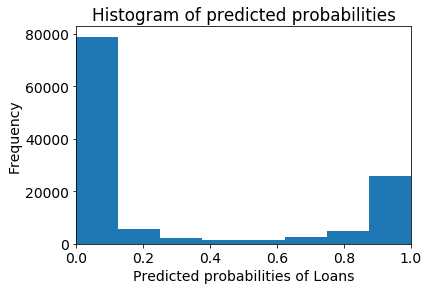

In [318]:
# histogram of predicted probabilities
plt.hist(y_pred_rf_nb2_threshold,bins = 8)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probabilities of Loans')
plt.ylabel('Frequency')

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


=== roc_curve ===
0.9783129375156311


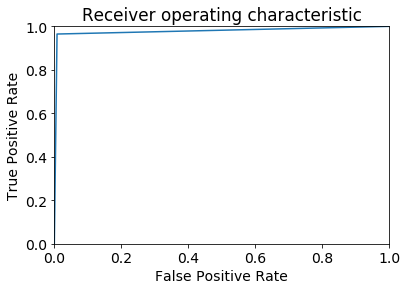

In [319]:
# roc auc  
from sklearn.preprocessing import binarize
y_pred_rf_nb2 = rfclassifier_nb.predict_proba(X_test_nb)[:,1]
y_pred_rf_nb2 = np.array(y_pred_rf_nb2).reshape((len(y_pred_rf_nb2), 1))
y_pred_rf_nb3 = binarize(y_pred_rf_nb2,thresholds[ix])

'''change the treshold. Predict loan if predict probability is greater than 0.2'''

result = []
y_pred_rf_nb3 = [result.append(p) for p in y_pred_rf_nb3 ]
print("=== roc_curve ===")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,result)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,result))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

logistic regresion normalized balanced validation


=== Confusion Matrix ===
[[38576   305]
 [  384   329]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     38881
         1.0       0.52      0.46      0.49       713

    accuracy                           0.98     39594
   macro avg       0.75      0.73      0.74     39594
weighted avg       0.98      0.98      0.98     39594

=== accuracy_score ===
0.9825983734909329


C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


=== roc_curve ===
0.7267930632949036


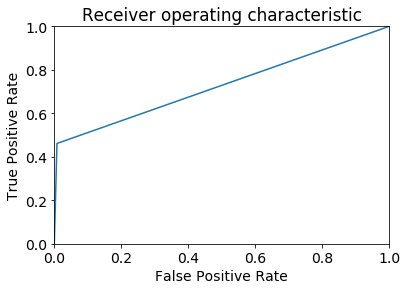

In [320]:
#validation
y_pred_rf_nb_val = rfclassifier_nb.predict(X_val_n)
y_pred_rf_nb_val2=(y_pred_rf_nb_val,thresholds[ix])[0]

print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_n,y_pred_rf_nb_val2))
print("=== classification_report ===")
print(classification_report(y_val_n,y_pred_rf_nb_val2))
print("=== accuracy_score ===")
print(accuracy_score(y_val_n,y_pred_rf_nb_val2))

# roc auc  validation dataset

y_pred_rf_nb_val2 = rfclassifier_nb.predict_proba(X_val_n)[:,1]
y_pred_rf_nb_val2 = np.array(y_pred_rf_nb_val2).reshape((len(y_pred_rf_nb_val2), 1))
y_pred_rf_nb_val3 = binarize(y_pred_rf_nb_val2,thresholds[ix])

'''change the treshold. Predict loan if predict probability is greater than 0.2'''
# y_pred_rf_nb3 = [p[1] for p in y_pred_rf_nb3 ]
result = []
y_pred_rf_nb_val3 = [result.append(p) for p in y_pred_rf_nb_val3 ]
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_n,result)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_n,result))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

feature importance

In [321]:
# important features and visualize them using Seaborn

# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = Xnb.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = rfclassifier_b.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

variable  importance
16         months_since_loan    0.210865
20            previous_loans    0.210484
17                 car_years    0.109088
25               work_type_A    0.060088
18               House_years    0.052033
..                       ...         ...
7                     acc_0m    0.016760
0                        age    0.016544
3   aveg_amount_cred_card_0m    0.011037
31                mortgage_N    0.009591
28               work_type_P    0.007273

[20 rows x 2 columns]

### d.4 XGBBoost

### d.4.1 XGB non normalized

In [322]:
model_xgb = XGBClassifier()

model_xgb.fit(X_train,y_train)

model_xgb_predict = model_xgb.predict(X_test)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

model_xgb_cv_score = cross_val_score(model_xgb,  X, y, cv=10)

print(model_xgb_cv_score)

'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, model_xgb_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, model_xgb_predict))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score.mean())

[20:16:06] ======== Monitor: Learner ========
[20:16:06] ======== Monitor: GBTree ========


C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0.98636172 0.98709134 0.98678266 0.98762418 0.9874558  0.98695067
 0.98720323 0.98728742 0.98711904 0.98815738]
XGBoost


=== Confusion Matrix ===
[[87335   211]
 [  950   590]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     87546
           1       0.74      0.38      0.50      1540

    accuracy                           0.99     89086
   macro avg       0.86      0.69      0.75     89086
weighted avg       0.98      0.99      0.98     89086



=== All AUC Scores ===
[0.98636172 0.98709134 0.98678266 0.98762418 0.9874558  0.98695067
 0.98720323 0.98728742 0.98711904 0.98815738]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.987203344458317


### d.4.2 XGB non normalized- balanced

[0.90615818 0.99336829 0.99185831 0.99332748 0.99310303 0.99230722
 0.9922052  0.99328667 0.99249087 0.99334789]
XGBoost


=== Confusion Matrix ===
[[87290   264]
 [ 1556 33408]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     87554
           1       0.99      0.96      0.97     34964

    accuracy                           0.99    122518
   macro avg       0.99      0.98      0.98    122518
weighted avg       0.99      0.99      0.99    122518



=== All AUC Scores ===
[0.90615818 0.99336829 0.99185831 0.99332748 0.99310303 0.99230722
 0.9922052  0.99328667 0.99249087 0.99334789]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9841453136119774
=== roc_curve ===
0.9974169076839674


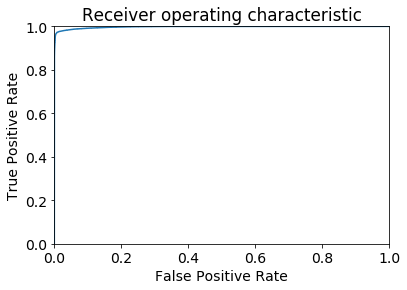

In [323]:
# balanced
model_xgb_b = XGBClassifier(n_estimators=100,random_state=42)

model_xgb_b.fit(X_train_b,y_train_b)

model_xgb_predict_b = model_xgb_b.predict(X_test_b)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

model_xgb_cv_score_b = cross_val_score(model_xgb_b,  Xb_resampled, yb_resampled, cv=10)

print(model_xgb_cv_score_b)


'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b, model_xgb_predict_b))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_b, model_xgb_predict_b))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_b)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_b.mean())

# roc auc  
y_pred_xgb__b2 = model_xgb_b.predict_proba(X_test_b)
y_pred_xgb__b2 = [p[1] for p in y_pred_xgb__b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_xgb__b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_xgb__b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


XGBBoost non normalized balanced validation


=== Confusion Matrix ===
[[38787    94]
 [  447   266]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     38881
           1       0.74      0.37      0.50       713

    accuracy                           0.99     39594
   macro avg       0.86      0.69      0.74     39594
weighted avg       0.98      0.99      0.98     39594

=== accuracy_score ===
0.9863363135828661
=== roc_curve ===
0.9522872736471804


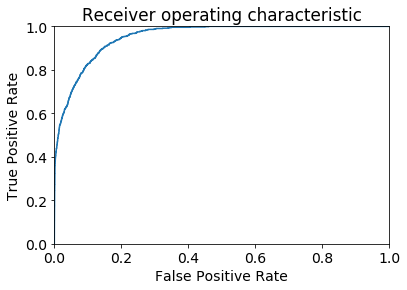

In [324]:
# we need to transform it to matrix to avoid feature mismatch
X_val_xgb = X_val.copy()
y_val_xgb = y_val.copy()
X_val_xgb = X_val_xgb.as_matrix()
y_val_xgb = y_val_xgb.as_matrix()


#validation
y_pred_xgb_b_val = model_xgb_b.predict(X_val_xgb)


print("XGBBoost non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_xgb,y_pred_xgb_b_val))
print("=== classification_report ===")
print(classification_report(y_val_xgb,y_pred_xgb_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val_xgb,y_pred_xgb_b_val))

# roc auc  

y_pred_xgb_b_val2 = model_xgb_b.predict_proba(X_val_xgb)
y_pred_xgb_b_val2 = [p[1] for p in y_pred_xgb_b_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_xgb,y_pred_xgb_b_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_xgb,y_pred_xgb_b_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### d.4.3 XGB normalized

In [325]:
model_xgb_n = XGBClassifier(n_estimators=100,random_state=42)
model_xgb_n.fit(X_train_n,y_train_n)
model_xgb_predict_n = model_xgb_n.predict(X_test_n)


model_xgb_cv_score_n = cross_val_score(model_xgb_n,  X_n, y_n, cv=5)

print(model_xgb_cv_score_n)

'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_n, model_xgb_predict_n))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_n, model_xgb_predict_n))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_n)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_n.mean())

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0.98668425 0.98727357 0.98716132 0.98704889 0.98755402]
XGBoost


=== Confusion Matrix ===
[[87335   211]
 [  950   590]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     87546
         1.0       0.74      0.38      0.50      1540

    accuracy                           0.99     89086
   macro avg       0.86      0.69      0.75     89086
weighted avg       0.98      0.99      0.98     89086



=== All AUC Scores ===
[0.98668425 0.98727357 0.98716132 0.98704889 0.98755402]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9871444094989613


### d.4.4 XGB normalized- balanced

=== roc_curve ===
0.9954181616249971


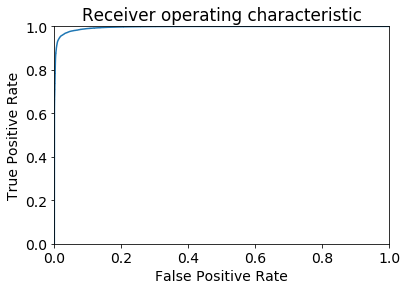

[0.94677345 0.97918665 0.97803375 0.97812557 0.97829902]
XGBoost


=== Confusion Matrix ===
[[86709   845]
 [ 2462 32502]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     87554
         1.0       0.97      0.93      0.95     34964

    accuracy                           0.97    122518
   macro avg       0.97      0.96      0.97    122518
weighted avg       0.97      0.97      0.97    122518



=== All AUC Scores ===
[0.94677345 0.97918665 0.97803375 0.97812557 0.97829902]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9720836885068398
=== roc_curve ===
0.9954181616249971


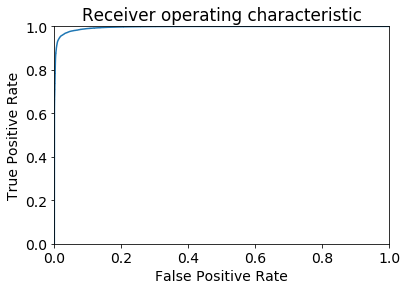

In [326]:
model_xgb_nb = XGBClassifier(n_estimators=100,random_state=42)
model_xgb_nb.fit(X_train_nb,y_train_nb)
model_xgb_predict_nb = model_xgb_nb.predict(X_test_nb)


model_xgb_cv_score_nb = cross_val_score(model_xgb_nb,  Xnb_resampled, ynb_resampled, cv=5)
# roc auc  

model_xgb_predict_nb2 = model_xgb_nb.predict_proba(X_test_nb)
model_xgb_predict_nb2 = [p[1] for p in model_xgb_predict_nb2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,model_xgb_predict_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,model_xgb_predict_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
print(model_xgb_cv_score_nb)

'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_nb, model_xgb_predict_nb))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_nb, model_xgb_predict_nb))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_nb)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_nb.mean())

# roc auc  

model_xgb_predict_nb2 = model_xgb_nb.predict_proba(X_test_nb)
model_xgb_predict_nb2 = [p[1] for p in model_xgb_predict_nb2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,model_xgb_predict_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,model_xgb_predict_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


XGBoost normalized balanced validation


=== Confusion Matrix ===
[[38529   352]
 [  362   351]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     38881
         1.0       0.50      0.49      0.50       713

    accuracy                           0.98     39594
   macro avg       0.74      0.74      0.74     39594
weighted avg       0.98      0.98      0.98     39594

=== accuracy_score ===
0.9819669646916199
=== roc_auc_score ===
=== roc_curve ===
0.9552914053969762


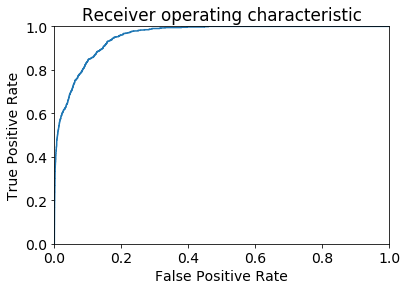

In [327]:
# we need to transform it to matrix to avoid feature mismatch
X_val_xgb_n = X_val_n.copy()
y_val_xgb_n = y_val_n.copy()
X_val_xgb_n = X_val_xgb_n.as_matrix()
y_val_xgb_n = y_val_xgb_n.as_matrix()

#validation
y_pred_b_val_n = model_xgb_nb.predict(X_val_xgb_n)


print("XGBoost normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_xgb_n,y_pred_b_val_n))
print("=== classification_report ===")
print(classification_report(y_val_xgb_n,y_pred_b_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val_xgb_n,y_pred_b_val_n))
print("=== roc_auc_score ===")

# roc auc  

y_pred_b_val_n = model_xgb_nb.predict_proba(X_val_xgb_n)
y_pred_b_val_n = [p[1] for p in y_pred_b_val_n ]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_xgb_n,y_pred_b_val_n)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_xgb_n,y_pred_b_val_n))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [328]:
# important features and visualize them using Seaborn

# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = Xb.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = model_xgb_b.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

variable  importance
20            previous_loans    0.217097
25               work_type_A    0.098935
21                  gender_V    0.083373
23                 studies_2    0.078899
8                  mobile_0m    0.054391
..                       ...         ...
2          num_cred_cards_0m    0.018370
3   aveg_amount_cred_card_0m    0.014952
16         months_since_loan    0.013968
0                        age    0.012151
27               work_type_O    0.011953

[20 rows x 2 columns]

# nuevos modelos 

# fine tunning

In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection



In [330]:
# XBBoosting


model_xgb_ft = XGBClassifier(silent=False,   
                             scale_pos_weight = 1, # count negative examples/ positivs examples
                             learning_rate = 0.1, # between 0.1 and 0.01 the lower the higher the number of trees and the time
                             colsample_bytree = 0.4, # number of columns for each tree. 0 to 0.8 if you have a lot of columns and 
                                                 #0.8 to 1 if you have few. To avoid one column take a lot of credit of the model.
                             sumsample = 0.3, # percentage of rows taken to build the tree. More than 1 will reduce the performance
                             objective = 'binary:logistic',
                             n_estimator = 100, # for higher dataset size we would use 100 a 1000 for lower
                             reg_alpha= 0.2,
                             max_depth = 4,
                             gamma =10,
                             verbosity = 3,
                             eval_metric = "logloss",
                              early_stop_round = 10) # regularizarion parameter
model_xgb_ft.fit(X_train_b,y_train_b)


model_xgb_predict_bft = model_xgb_ft.predict(X_test_b)

[20:43:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[20:43:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20:43:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20:43:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[20:43:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:43:52] INFO: src/tree/updater_prune.cc:74: tree prun

[20:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[20:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[20:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:44:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:44:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[20:44:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[20:44:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[20:44:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:44:19] INFO: src/tree/updater_prune.cc:74: tree pr

In [331]:

model_xgb_cv_score_bft = cross_val_score(model_xgb_ft,  Xb_resampled, yb_resampled, cv=5)

print(model_xgb_cv_score_bft)

[20:44:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[20:44:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20:44:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:44:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20:44:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[20:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[20:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:44:32] INFO: src/tree/updater_prune.cc:74: tree prun

[20:44:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[20:44:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[20:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[20:44:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[20:44:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[20:45:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[20:45:00] INFO: src/tree/updater_prune.cc:74: tree pr

[20:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[20:45:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:45:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20:45:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20:45:27] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20:45:27] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20:45:27] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[20:45:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[20:45:28] INFO: src/tree/updater_prune.cc:74: tree prun

[20:45:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[20:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:45:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[20:45:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[20:45:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20:45:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[20:45:54] INFO: src/tree/updater_prune.cc:74: tree prun

[20:46:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[20:46:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[20:46:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[20:46:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:46:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:46:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[20:46:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:46:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[20:46:20] INFO: src/tree/updater_prune.cc:74: tree pru

[20:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[20:46:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[20:46:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:46:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:46:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:46:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:46:46] INFO: src/tree/updater_prune.cc:74: tree prun

[20:47:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[20:47:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[20:47:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20:47:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[20:47:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[20:47:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[20:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[20:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[20:47:11] INFO: src/tree/updater_prune.cc:74: tree prun

[20:47:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[20:47:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[20:47:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[20:47:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[20:47:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[20:47:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[20:47:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[20:47:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[20:47:37] INFO: src/tree/updater_prune.cc:74: tree

In [332]:
'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b, model_xgb_predict_bft))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_b, model_xgb_predict_bft))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_bft)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_bft.mean())


XGBoost


=== Confusion Matrix ===
[[87321   233]
 [ 1273 33691]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     87554
           1       0.99      0.96      0.98     34964

    accuracy                           0.99    122518
   macro avg       0.99      0.98      0.98    122518
weighted avg       0.99      0.99      0.99    122518



=== All AUC Scores ===
[0.94829363 0.99488849 0.99488849 0.99517416 0.9949293 ]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9856348107543239


=== roc_curve ===
0.9978960017541346


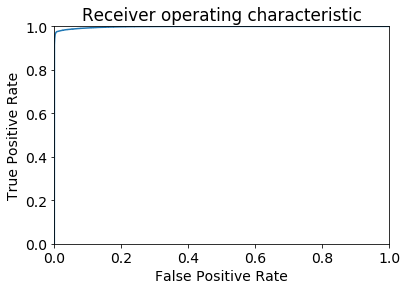

In [333]:
# roc auc  

model_xgb_predict_b_ft = model_xgb_ft.predict_proba(X_test_b)
model_xgb_predict_b_ft = [p[1] for p in model_xgb_predict_b_ft ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,model_xgb_predict_b_ft)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,model_xgb_predict_b_ft))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [334]:
# we need to transform it to matrix to avoid feature mismatch
X_val_xgb_ft = X_val.copy()
y_val_xgb_ft = y_val.copy()
X_val_xgb_ft = X_val_xgb_ft.as_matrix()
y_val_xgb_ft = y_val_xgb_ft.as_matrix()

C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [335]:
#validation
y_pred_b_val_ft_cm = model_xgb_ft.predict(X_val_xgb_ft)

print("XGBoost normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_xgb_ft,y_pred_b_val_ft_cm))
print("=== classification_report ===")
print(classification_report(y_val_xgb_ft,y_pred_b_val_ft_cm))
print("=== accuracy_score ===")
print(accuracy_score(y_val_xgb_ft,y_pred_b_val_ft_cm))


XGBoost normalized balanced validation


=== Confusion Matrix ===
[[38801    80]
 [  459   254]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     38881
           1       0.76      0.36      0.49       713

    accuracy                           0.99     39594
   macro avg       0.87      0.68      0.74     39594
weighted avg       0.98      0.99      0.98     39594

=== accuracy_score ===
0.9863868262868112


=== roc_curve ===
0.9571998069558305


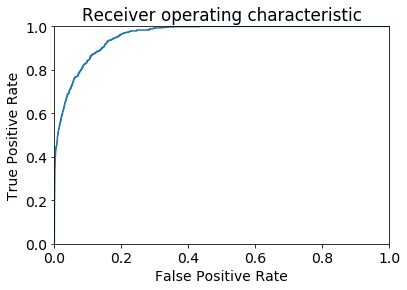

In [336]:
# roc auc  

y_pred_b_val_ft = model_xgb_ft.predict_proba(X_val_xgb_ft)
y_pred_b_val_ft = [p[1] for p in y_pred_b_val_ft ]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_xgb_ft,y_pred_b_val_ft)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_xgb_ft,y_pred_b_val_ft))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [337]:
# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = Xnb.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = model_xgb_ft.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

variable  importance
16         months_since_loan    0.244122
20            previous_loans    0.149158
8                  mobile_0m    0.094958
25               work_type_A    0.087406
23                 studies_2    0.053782
..                       ...         ...
22                 studies_1    0.013428
7                     acc_0m    0.013029
0                        age    0.011557
12                web_par_0m    0.009599
3   aveg_amount_cred_card_0m    0.009063

[20 rows x 2 columns]

# SVC

### non normalized

In [338]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
confusion_matrix(y_test, y_pred_svc)
svc_cv_score = cross_val_score(svc,  X, y, cv=5)
print(svc_cv_score)
'''SVC'''
print("SVC")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_svc))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_svc))
print('\n')
print("=== All AUC Scores ===")
print(y_pred_svc)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - SVC: ", svc_cv_score.mean())


C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataCo

[0.87021005 0.97548724 0.96899073 0.97712859 0.98206769]
SVC


=== Confusion Matrix ===
[[43183 44363]
 [  808   732]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.49      0.66     87546
           1       0.02      0.48      0.03      1540

    accuracy                           0.49     89086
   macro avg       0.50      0.48      0.34     89086
weighted avg       0.96      0.49      0.65     89086



=== All AUC Scores ===
[1 1 0 ... 0 1 1]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9547768572486586


### non normalized balanced

In [339]:
from sklearn.svm import LinearSVC
svc_b = LinearSVC()
svc_b.fit(X_train_b, y_train_b)
y_pred_svc_b = svc_b.predict(X_test_b)
confusion_matrix(y_test_b, y_pred_svc_b)
svc_cv_score_b = cross_val_score(svc_b,  Xb_resampled, yb_resampled, cv=5)
print(svc_cv_score_b)
'''SVC'''
print("SVC")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b, y_pred_svc_b))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_b, y_pred_svc_b))
print('\n')
print("=== All AUC Scores ===")
print(y_pred_svc_b)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", svc_cv_score_b.mean())


C:\Users\N58645\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

[0.54304953 0.72347828 0.57360173 0.73400739 0.54308568]
SVC


=== Confusion Matrix ===
[[70762 16792]
 [26954  8010]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.81      0.76     87554
           1       0.32      0.23      0.27     34964

    accuracy                           0.64    122518
   macro avg       0.52      0.52      0.52    122518
weighted avg       0.61      0.64      0.62    122518



=== All AUC Scores ===
[0 0 1 ... 1 0 0]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.6234445221100389


=== roc_curve ===
0.5291344615261304


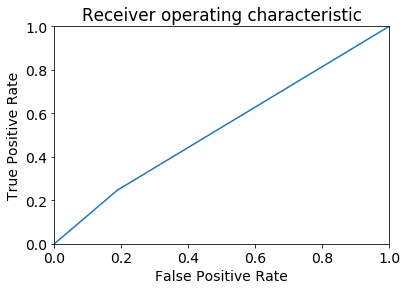

In [340]:
# roc auc  

y_pred_b_val_svc = svc_b.predict(X_val)
# y_pred_b_val_svc = [p[1] for p in y_pred_b_val_svc]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_b_val_svc)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_b_val_svc))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### normalized

In [341]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_n, y_train_n)
y_pred_svc = svc.predict(X_test_n)
confusion_matrix(y_test_n, y_pred_svc)
svc_cv_score_n = cross_val_score(svc,  X_n, y_n, cv=5)
print(svc_cv_score_n)
'''SVC'''
print("SVC")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_n, y_pred_svc))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_n, y_pred_svc))
print('\n')
print("=== All AUC Scores ===")
print(y_pred_svc)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", svc_cv_score_n.mean())


C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

[0.98234857 0.98233454 0.98233454 0.98234832 0.98232026]
SVC


=== Confusion Matrix ===
[[87546     0]
 [ 1537     3]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     87546
         1.0       1.00      0.00      0.00      1540

    accuracy                           0.98     89086
   macro avg       0.99      0.50      0.50     89086
weighted avg       0.98      0.98      0.97     89086



=== All AUC Scores ===
[0. 0. 0. ... 0. 0. 0.]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9823372424716916


### normalized-balanced

In [342]:
from sklearn.svm import LinearSVC
svc_nb = LinearSVC()
svc_nb.fit(X_train_nb, y_train_nb)
y_pred_svc = svc_nb.predict(X_test_nb)
confusion_matrix(y_test_nb, y_pred_svc)
svc_cv_score_nb = cross_val_score(svc,  Xnb_resampled, ynb_resampled, cv=5)
print(svc_cv_score_nb)
'''SVC'''
print("SVC")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_nb, y_pred_svc))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_nb, y_pred_svc))
print('\n')
print("=== All AUC Scores ===")
print(y_pred_svc)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", svc_cv_score_nb.mean())


[0.83939193 0.83675801 0.83768645 0.83795172 0.83927806]
SVC


=== Confusion Matrix ===
[[83655  3899]
 [15865 19099]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89     87554
         1.0       0.83      0.55      0.66     34964

    accuracy                           0.84    122518
   macro avg       0.84      0.75      0.78    122518
weighted avg       0.84      0.84      0.83    122518



=== All AUC Scores ===
[1. 0. 0. ... 0. 0. 1.]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.838213236084784


=== roc_curve ===
0.500598384259693


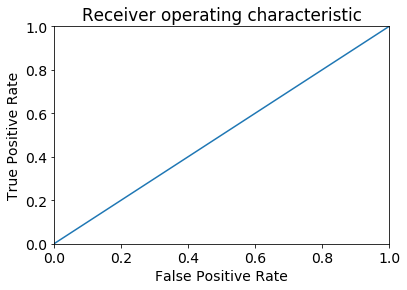

In [343]:
# roc auc  

y_pred_nb_val_svc = svc_b.predict(X_val_n)
# y_pred_nb_val_svc = [p[1] for p in y_pred_nb_val_svc]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_n,y_pred_nb_val_svc)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_n,y_pred_nb_val_svc))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

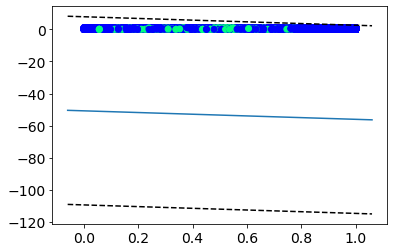

In [344]:
plt.scatter(X_train_nb[:, 0], X_train_nb[:, 1], c=y_train_nb, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')


# Stacking Models

In [345]:
import mlens

# import pip
# C:\\Users\\N58645\\AppData\\Roaming\\Microsoft\\Windows\\Start Menu\\Programs\\Anaconda3 (64-bit)\\Scripts>pip3.exe install mlens

In [346]:
# https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de

from itertools import combinations
from sklearn.linear_model import LogisticRegression 
from mlens.ensemble import SuperLearner

In [347]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_nb, y_train_nb)

LinearSVC()

In [372]:
# Create classifiers

clf_array = [rfclassifier_b,model_xgb_b,model_logreg_b]  


In [373]:

names = ['Random Forest','XGBBoost','LG']

def zip_stacked_classifiers(*args):
    to_zip = []
    for arg in args:
        combined_items = sum([list(map(list, combinations(arg, i))) for i in range(len(arg) + 1)], [])
#         combined_items = sum([map(list, combinations(arg, i)) for i in range(len(arg) + 1)], [])
        combined_items = filter(lambda x: len(x) > 0, combined_items)
        to_zip.append(combined_items)
    
    return zip(to_zip[0], to_zip[1])
stacked_clf_list = zip_stacked_classifiers(clf_array, names)
best_combination = [0.00, ""]
for clf in stacked_clf_list:
    
    ensemble = SuperLearner(scorer = accuracy_score, 
                            random_state = 42, 
                            folds = 10)
    ensemble.add(clf[0])
    ensemble.add_meta(dt_clients_file_num_b) 
  
    ensemble.fit(X_train_b, y_train_b)
    preds_stack = ensemble.predict(X_test_b)
    accuracy = accuracy_score(preds_stack, y_test_b)
    
    if accuracy > best_combination[0]:
        best_combination[0] = accuracy
        best_combination[1] = clf[1]
    
print(("Accuracy score: {:.3f} {}").format(accuracy, clf[1]))
print(("\nBest stacking model is {} with accuracy of: {:.3f}").format(best_combination[1], best_combination[0]))

[16:59:59] ======== Monitor: Learner ========
[16:59:59] GetGradient: 4.0491s, 100 calls @ 40490us
[16:59:59] PredictRaw: 0.0918361s, 100 calls @ 918us
[16:59:59] UpdateOneIter: 70.0242s, 100 calls @ 700242us
[16:59:59] ======== Monitor: GBTree ========
[16:59:59] BoostNewTrees: 58.9197s, 100 calls @ 589197us
[16:59:59] CommitModel: 6.96356s, 100 calls @ 69635us
[16:59:59] ======== Monitor: Learner ========
[16:59:59] GetGradient: 3.23987s, 100 calls @ 32398us
[16:59:59] PredictRaw: 0.0868548s, 100 calls @ 868us
[16:59:59] UpdateOneIter: 54.0582s, 100 calls @ 540582us
[16:59:59] ======== Monitor: GBTree ========
[16:59:59] BoostNewTrees: 45.0122s, 100 calls @ 450122us
[16:59:59] CommitModel: 5.71829s, 100 calls @ 57182us
[16:59:59] ======== Monitor: Learner ========
[16:59:59] GetGradient: 3.3509s, 100 calls @ 33508us
[16:59:59] PredictRaw: 0.0868684s, 100 calls @ 868us
[16:59:59] UpdateOneIter: 59.9454s, 100 calls @ 599454us
[16:59:59] ======== Monitor: GBTree ========
[16:59:59] Boos

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\N58645\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Accuracy score: 0.989 ['Random Forest', 'XGBBoost', 'LG']

Best stacking model is ['Random Forest', 'XGBBoost'] with accuracy of: 0.989


Stack model normalized balanced


=== Confusion Matrix ===
[[87263   291]
 [ 1048 33916]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     87554
           1       0.99      0.97      0.98     34964

    accuracy                           0.99    122518
   macro avg       0.99      0.98      0.99    122518
weighted avg       0.99      0.99      0.99    122518

=== accuracy_score ===
0.9890709936499127
=== roc_curve ===
0.9833513248340462


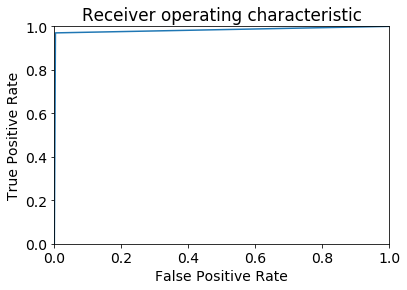

In [374]:
# test
print("Stack model normalized balanced")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b,preds_stack))
print("=== classification_report ===")
print(classification_report(y_test_b,preds_stack))
print("=== accuracy_score ===")
print(accuracy_score(y_test_b,preds_stack))

# roc auc  

# we need to transform it to matrix to avoid feature mismatch

y_pred_b_stack = ensemble.predict_proba(X_test_b)
# y_pred_b_stack = [p[1] for p in y_pred_b_stack]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_b_stack)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_b_stack))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Stack balanced validation


=== Confusion Matrinstack,y_pred_b_val_stack
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     38881
           1       0.72      0.38      0.50       713

    accuracy                           0.99     39594
   macro avg       0.85      0.69      0.75     39594
weighted avg       0.98      0.99      0.98     39594

=== accuracy_score ===
0.9861595191190584
=== roc_curve ===
0.6886789420720678


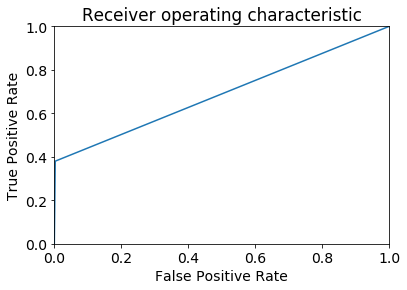

In [375]:
# validation

# we need to transform it to matrix to avoid feature mismatch
X_val_stack = X_val.copy()
y_val_stack = y_val.copy()
X_val_stack = X_val_stack.as_matrix()
y_val_stack = y_val_stack.as_matrix()

y_pred_b_val_stack= ensemble.predict_proba(X_val_stack)

print("Stack balanced validation")
print('\n')
print("=== Confusion Matrinstack,y_pred_b_val_stack")
print("=== classification_report ===")
print(classification_report(y_val_stack,y_pred_b_val_stack))
print("=== accuracy_score ===")
print(accuracy_score(y_val_stack,y_pred_b_val_stack))

# roc auc  

# we need to transform it to matrix to avoid feature mismatch

y_pred_b_stack = ensemble.predict_proba(X_val_stack)
# y_pred_b_stack = [p[1] for p in y_pred_b_stack]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_stack,y_pred_b_val_stack)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_stack,y_pred_b_val_stack))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

# Implementing LIME to generate local interpretations of black-box 
Locally Interpretable Model-Agnostic Explanations

In [376]:
# !pip install lime

# import Explainer function from lime_tabular module of lime library
from lime.lime_tabular import LimeTabularExplainer

In [377]:
X_train_b2=  pd.DataFrame(X_train_b,columns =X_train.columns)
y_train_b2=  pd.DataFrame(y_train_b,columns =y_train.columns)
X_test_b2=  pd.DataFrame(X_test_b,columns =X_test.columns)
y_test_b2=  pd.DataFrame(y_test_b,columns =y_test.columns)

In [378]:
# installing lime library

# training the random forest model
# rf_model = RandomForestRegressor(n_estimators=200,max_depth=4, min_samples_leaf=100,n_jobs=-1, random_state=10)
# rf_model.fit(X_train_nb2, y_train_nb2)

# creating the explainer function
explainer = LimeTabularExplainer(X_train_b2.values, mode="classification", feature_names=X_train_b2.columns)

In [379]:
# storing a new observation
i = X_test_b2.index.get_loc(37167)
X_observation = X_test_b2.iloc[[i], :]

# RF_prediction: {rf_model.predict(X_observation)[0]}
    
X_observation

age  population_cmun  num_cred_cards_0m  aveg_amount_cred_card_0m  \
37167  41.0          77151.0                0.0                       0.0   

       amount_cards_0m  amount_total_cards_0m  num_stocks_0m  acc_0m  \
37167        723.29841              997.28658            0.0    50.0   

       mobile_0m  pc_0m  tablet_0m  app_par_0m  web_par_0m  amount_rec_0m  \
37167       0.72   0.28        0.0        34.0        16.0       81.59379   

       num_rec_0m  aved_amount_postpone_payment_3t4t_delta  months_since_loan  \
37167         2.0                                      0.0                0.0   

       car_years  House_years  cprovper  previous_loans  gender_V  studies_1  \
37167        8.0          9.0      28.0             0.0       1.0        1.0   

       studies_2  studies_3  work_type_A  work_type_J  work_type_O  \
37167        0.0        0.0          0.0          0.0          1.0   

       work_type_P  codseg_PB  codseg_PI  mortgage_N  
37167          0.0        0.0        0.0         1.0

In [380]:
# total_clients_mod_[(total_clients_mod_['months_since_loan']==0) & (total_clients_mod_['car_years']==10) & (total_clients_mod_['House_years']==1)& (total_clients_mod_['aveg_amount_cred_card_0m']==903.57)]

In [381]:
pd.set_option('display.max_columns', 61)
index_called = 37167     

real_data = Total_clients_ini.loc[ index_called , : ].to_frame().T
real_data

cod1   cod2 gender age nat_country resi_country studies work_type  \
37167    C  21354      V  57          ES           ES       6         A   

      branch marital_status codseg  cpper cprovper clocaper autonper country  \
37167   4185              C     PI  30008       29       17        1      ES   

      codine population_cmun disporent_cmun num_cred_cards_0m  \
37167  28115          569002          20980                 1   

      aveg_amount_cred_card_0m num_current_acc_0m aveg_amount_current_acc_0m  \
37167                        0                  1                     -10.98   

      num_invest_funds_0m aveg_amount_invest_funds_0m mortgage num_stocks_0m  \
37167                   0                           0        S             0   

      aveg_amount_stocks_0m acc_0m mobile_0m pc_0m tablet_0m  \
37167                     0      0         0     0         0   

      national_transfers_0m transfers_0m app_par_0m web_par_0m  \
37167                     0            0          0          0   

      amount_cards_0m amount_trfr_0m amount_salarypenr_0m amount_rec_0m  \
37167       163,21078     2914,95008           2629,28308     850,52151   

      amount_total_cards_0m num_trfr_0m num_trfe_0m num_rec_0m  \
37167             225,03564           2           3         11   

      num_card_postpone_payment_3t4t_delta  \
37167                                    0   

      aved_amount_postpone_payment_3t4t_delta previous_loans  \
37167                                       0              0   

      months_since_loan car_years House_years got_loan  
37167               NaN         8          10        0

In [382]:
X_observation.values[0]# Explanations using LIME  with the random forest model

explanation = explainer.explain_instance(X_observation.values[0], rfclassifier_b.predict_proba)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.36265463449295277


In [383]:
explanation.as_list()

[('House_years <= 9.33', -0.13868144091448725),
 ('work_type_A <= 0.00', -0.11379863342305319),
 ('months_since_loan <= 0.00', -0.11185145820029821),
 ('previous_loans <= 0.00', -0.09490877831030894),
 ('studies_2 <= 0.00', -0.0634962370583124),
 ('studies_3 <= 0.00', -0.06096603039053951),
 ('work_type_J <= 0.00', -0.057933387819812),
 ('0.00 < gender_V <= 1.00', 0.05137927208326299),
 ('tablet_0m <= 0.00', 0.026953032240483867),
 ('app_par_0m > 14.00', 0.024314685303789205)]

In [384]:
# Explanations using LIME  with the XGB model

explanation_xgb = explainer.explain_instance(X_observation.values[0], model_xgb_b.predict_proba)
explanation_xgb.show_in_notebook(show_table=True, show_all=False)
print(explanation_xgb.score)

0.2972914117258376


In [385]:
explanation_xgb.as_list()# Explanations using LIME  with the stacking model

explanation_stack = explainer.explain_instance(X_observation.values[0], svc.predict_proba)
explanation_stack.show_in_notebook(show_table=True, show_all=False)
print(explanation_stack.score)

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [ ]:
# Explanations using LIME  with the stacking model

explanation_stack = explainer.explain_instance(X_observation.values[0], model_xgb_ft.predict_proba)
explanation_stack.show_in_notebook(show_table=True, show_all=False)
print(explanation_stack.score)